In [ ]:
# tensorflow==2.2.0rc2, Keras==2.2.4
# !pip install -q pandas scikit-learn tensorflow transformers matplotlib

In [ ]:
# ! pip install ipywidgets -q

In [ ]:
# !pip install -q tf-keras

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import os
os.environ['TF_KERAS'] = '1'

In [ ]:
# !pip install -q nltk
# !pip install -q  seaborn
# !pip install -q  torch

In [ ]:
# Librerías estándar de Python
import gzip
import re
import string
from collections import Counter
from string import punctuation
from typing import Tuple, Dict


# Librerías de terceros
import matplotlib.pyplot as plt
import nltk
import numpy as np
import json
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Configuración de pandas
pd.set_option("display.max_colwidth", 120)

# Seteamos la semilla
seed = 14
torch.manual_seed(seed)
np.random.seed(seed)
# Si utilizas CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
!pip install pandarallel
from pandarallel import pandarallel

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.9 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=c50f01d6392f4ce6eceb6b30a6a3dc4e197f8e443cfa482b9809845b2742d38e
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
nltk.download("stopwords") # Descargamos las stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Carga de dataset
with open('Sarcasm_Headlines_Dataset.json', 'r') as file:
    data = [json.loads(line) for line in file]

# Convert to DataFrame
df_sarcasm_src = pd.DataFrame(data)

df_sarcasm_src.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


In [ ]:
# Carga de dataset
data = []
with open('Sarcasm_Headlines_Dataset.json', 'r') as file:
    for line in file:
        try:
            data.append(json.loads(line)) # Loads each line as a separate JSON object
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in line: {line}") # Prints the problematic line for debugging
            print(f"Error message: {e}")

# Convert to DataFrame
df_sarcasm_src = pd.DataFrame(data)

df_sarcasm_src.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


# EDA y Limpieza

In [ ]:
df_sarcasm_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
# find duplicates
duplicates = df_sarcasm_src[df_sarcasm_src.duplicated(subset=['headline'], keep=False)]
df_sarcasm_src['duplicated'] = df_sarcasm_src.duplicated(subset=['headline'], keep=False)

sorted_duplicates = duplicates.sort_values(by='headline')
sorted_duplicates.head(50).tail(10)


,article_link,headline,is_sarcastic
13003,https://www.theonion.com/data-entry-clerk-reapplies-carmex-at-17-minute-interval-1819587724,data-entry clerk reapplies carmex at 17-minute intervals,1
25995,https://www.theonion.com/data-entry-clerk-reapplies-carmex-at-17-minute-interval-1819586637,data-entry clerk reapplies carmex at 17-minute intervals,1
17868,https://www.theonion.com/exxonmobil-swears-its-going-to-start-taxes-early-this-y-1819568223,exxonmobil swears it's going to start taxes early this year,1
16246,https://www.theonion.com/exxonmobil-swears-its-going-to-start-taxes-early-this-y-1819567267,exxonmobil swears it's going to start taxes early this year,1
15121,https://www.theonion.com/fruit-of-islam-cause-man-to-soil-fruit-of-looms-1819586741,fruit of islam cause man to soil fruit of looms,1
7038,https://www.theonion.com/fruit-of-islam-cause-man-to-soil-fruit-of-looms-1819587736,fruit of islam cause man to soil fruit of looms,1
17437,https://www.huffingtonpost.com/entry/funniest-parenting-tweets_us_563bd0f2e4b0b24aee4992d1,funniest parenting tweets: what moms and dads said on twitter this week,0
12895,https://www.huffingtonpost.com/entry/funniest-parenting-tweets_us_5633708fe4b0c66bae5c0020,funniest parenting tweets: what moms and dads said on twitter this week,0
13431,https://www.theonion.com/gay-gene-isolated-ostracized-1819564685,"gay gene isolated, ostracized",1
10005,https://www.theonion.com/gay-gene-isolated-ostracized-1819564276,"gay gene isolated, ostracized",1


Se verifico en varios casos que los headlines duplicados pertnenece al mismo articulo de origen.
Adicionalmente, como se va a considerar solo el headline para el analisis, tomaremos uno solo de los registros.

**Pregunta:**
- Deberíamos considerar los duplicados sobre el texto original o sobre el texto limpio?

In [ ]:
df_sarcasm_src['duplicated_nf'] = df_sarcasm_src.duplicated(subset=['headline'], keep='first')

#count the number of duplicates_nf
duplicates_nf = df_sarcasm_src['duplicated_nf'].value_counts()
print(f'Total duplicates to remove: {duplicates_nf[True]} ({(duplicates_nf[True]/len(df_sarcasm_src)*100):.2f}%)')

# Delete all duplicates_nf
df_sarcasm_src = df_sarcasm_src[~df_sarcasm_src['duplicated_nf']]

Total duplicates to remove: 107 (0.40%)


Total Non Sarcastic: 14951 (56.20%)
Total Sarcastic: 11651 (43.80%)


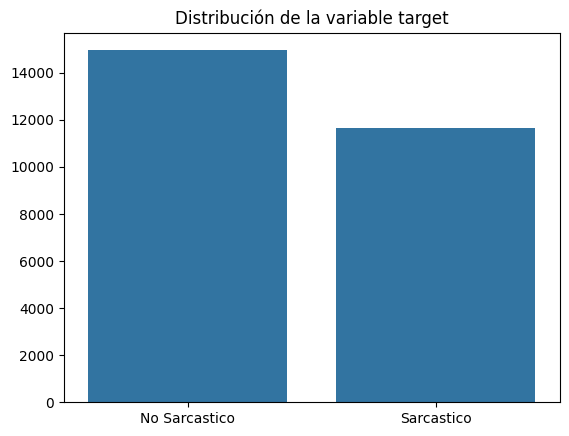

In [ ]:
# count is_sarcastic values
target_total = df_sarcasm_src['is_sarcastic'].value_counts()

# generate a dictionary with target_total
target_total_dict = dict(target_total)

total_sarcastic = target_total_dict[1]
total_non_sarcastic = target_total_dict[0]

# print totals and percentage
print(f'Total Non Sarcastic: {total_non_sarcastic} ({(total_non_sarcastic/len(df_sarcasm_src)*100):.2f}%)')
print(f'Total Sarcastic: {total_sarcastic} ({(total_sarcastic/len(df_sarcasm_src)*100):.2f}%)')

# Bar plot of total sarcastic and non sarcastic
# target_dist = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['No Sarcastico', 'Sarcastico']),y=[total_non_sarcastic, total_sarcastic])
plt.title('Distribución de la variable target')
plt.show()


Observamos que hay un número ligeramente mayor de registros en la clase "No Sarcástico" comparado con la clase "Sarcástico". Este desbalance no parece ser muy grande, pero sigue siendo relevante.

In [ ]:
# ! pip install beautifulsoup4 -q
# ! pip install emoji -q

In [ ]:
from bs4 import BeautifulSoup

def contains_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return bool(soup.find())  # Returns True if there are any HTML tags

In [ ]:
# Check if threre are any html tags in the headlines use beautifulsoup

# df_sarcasm_src['html_tags'] = df_sarcasm_src['headline'].parallel_apply(contains_html_tags)
df_sarcasm_src['html_tags'] = df_sarcasm_src['headline'].apply(contains_html_tags)




<ipython-input-13-cea8f44f81fd>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
!pip install emoji
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def count_emojis(text):
    return emoji.emoji_count(text)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Check if there are anu emojis in the headlines
#emoji.replace_emoji(text, '') # remove emojis
df_sarcasm_src['emojis'] = df_sarcasm_src['headline'].apply(count_emojis)

df_sarcasm_src['headline_clean'] = df_sarcasm_src['headline'].apply(remove_emojis)


In [ ]:
# filter where html tags are present and emojis are present
flt = (df_sarcasm_src['html_tags'] == True) | (df_sarcasm_src['emojis'] > 0)
filtered = df_sarcasm_src[flt]

# loop at the filtered data
for index, row in filtered.iterrows():
    print(f'Index: {index} - Headline: {row["headline"]} - Emojis: {row["emojis"]}')
    print(f'Index: {index} - Headline: {row["headline_clean"]}')
    print('----------------------------------------')



Index: 11690 - Headline: 7 seattle themed filters to live by © michelle moore - Emojis: 1
Index: 11690 - Headline: 7 seattle themed filters to live by  michelle moore
----------------------------------------
Index: 17106 - Headline: a definitive history of trump steaks™ - Emojis: 1
Index: 17106 - Headline: a definitive history of trump steaks
----------------------------------------


In [ ]:
!pip install unidecode
from unidecode import unidecode
df_sarcasm_src['headline_clean'] = df_sarcasm_src['headline_clean'].apply(lambda x: unidecode(x))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import string

df_sarcasm_src['headline_clean'] = df_sarcasm_src['headline_clean'].str.lower()

# remove special characters string.punctuation
def remove_special_characters(text):
    puntuation_list = string.punctuation
    puntuation_list = puntuation_list + '¿¡—”¯―–…“'
    trans_str = ' '*len(puntuation_list)
    puntuation_list = puntuation_list + 'áéíóúàèìòùäëïöüãõøû×'
    trans_str = trans_str + 'aeiou'*3 + 'aooux'
    # print(len(puntuation_list), len(trans_str))
    # print(puntuation_list)
    # print(trans_str)
    return text.translate(str.maketrans(puntuation_list, trans_str))

remove_special_characters('not—she')



'not she'

In [ ]:
df_sarcasm_src['headline_clean'] = df_sarcasm_src['headline_clean'].apply(remove_special_characters)

In [ ]:
# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_sarcasm_src['headline_clean'] = df_sarcasm_src['headline_clean'].apply(remove_stop_words)



In [ ]:
# Add a column check for duplicates in the headline_clean
df_sarcasm_src['duplicated_clean'] = df_sarcasm_src.duplicated(subset=['headline_clean'], keep=False)

# filter by duplicated_clean
tmp_duplicated_clean = df_sarcasm_src[df_sarcasm_src['duplicated_clean'] == True]

# tmp_duplicated_clean group by headline_clean, count rows and distinct is_sarcastic
tmp_duplicated_clean_grouped = tmp_duplicated_clean.groupby(['headline_clean']).agg({'is_sarcastic': ['count', 'nunique']})
# reset index
tmp_duplicated_clean_grouped = tmp_duplicated_clean_grouped.reset_index()
# rename columns
tmp_duplicated_clean_grouped.columns = ['headline_clean', 'count', 'is_sarcastic']

# filter by is_sarcastic count > 1
dup_inconsitent = tmp_duplicated_clean_grouped[tmp_duplicated_clean_grouped['is_sarcastic'] > 1]

print("Number of inconsistent duplicates: ", len(dup_inconsitent))

Number of inconsistent duplicates:  0


No hay duplicados del mensaje limpio con diferentes valoraciones de sarcasmo.
Se podrían remover esos duplicados, dado que el analisis se hará con esa columna

In [ ]:
df_sarcasm_src['duplicated_clean_nf'] = df_sarcasm_src.duplicated(subset=['headline_clean'], keep='first')

# contar los duplicados a remover
duplicates_nf = df_sarcasm_src['duplicated_clean_nf'].value_counts()
print(f'Total duplicates to remove: {duplicates_nf[True]} ({(duplicates_nf[True]/len(df_sarcasm_src)*100):.2f}%)')

# remove duplicates
df_sarcasm_src = df_sarcasm_src[~df_sarcasm_src['duplicated_clean_nf']]


Total duplicates to remove: 4 (0.02%)


In [ ]:
# filter for headlines with length == 0
df_sarcasm_src['words_clean'] = df_sarcasm_src['headline_clean'].apply(lambda x: len(x.split()))

# filter for headlines with length == 0
flt = df_sarcasm_src['words_clean'] == 0
# print the number headlines with length == 0
print(f'Number of headlines with length == 0: {len(df_sarcasm_src[flt])}')

filtered

Number of headlines with length == 0: 1


,article_link,headline,is_sarcastic,duplicated,duplicated_nf,html_tags,emojis,headline_clean
11690,https://www.huffingtonpost.com/entry/7-seattle-themed-filters_b_9280362.html,7 seattle themed filters to live by © michelle moore,0,False,False,False,1,7 seattle themed filters to live by michelle moore
17106,https://www.huffingtonpost.comhttp://thinkprogress.org/politics/2016/03/04/3756135/trump-steaks-a-definitive-history/,a definitive history of trump steaks™,0,False,False,False,1,a definitive history of trump steaks


In [ ]:
# Filter out headlines with length == 0
df_sarcasm_src = df_sarcasm_src[~flt]


# Conjuntos de entrenamiento, test y validación

In [ ]:
# Division de datos
df = df_sarcasm_src.copy()

df[['headline', 'headline_clean', 'is_sarcastic']].to_csv('sarcasm_headlines_clean.csv', index=False)

X = df['headline_clean'].values
y = df['is_sarcastic'].values

# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y test
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

print(f'Cantidad de datos en train: {X_train.shape[0]}')
print(f'Cantidad de datos en validación: {X_val.shape[0]}')
print(f'Cantidad de datos en test: {X_test.shape[0]}')

Cantidad de datos en train: 18617
Cantidad de datos en validación: 3990
Cantidad de datos en test: 3990


Utilizar *stratify* al dividir el data set en entrenamiento, validación y test puede ayudar a manejar el desbalance de clases. Al hacer esto, nos aseguramos que la proporción de clases en el conjunto de entrenamiento y en el conjunto de validación y test sea similar a la proporción de clases en el conjunto original.

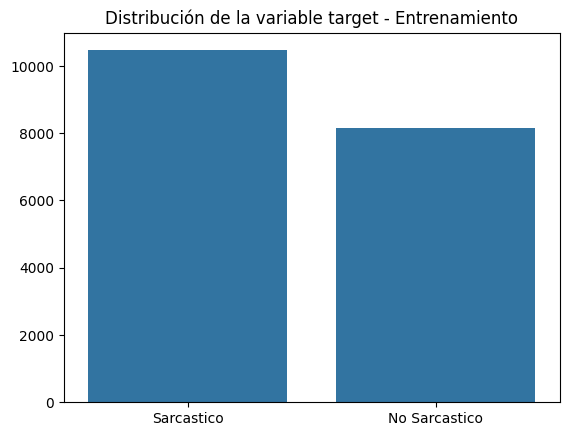

In [ ]:
target_dist = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['Sarcastico','No Sarcastico']),y=target_dist.values)
plt.title('Distribución de la variable target - Entrenamiento')
plt.show()

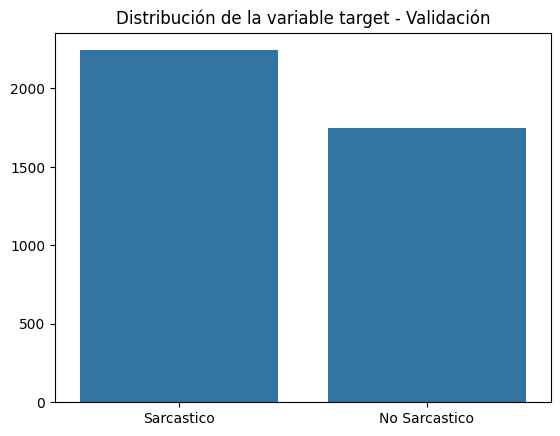

In [ ]:
target_dist = pd.Series(y_val).value_counts()
sns.barplot(x=np.array(['Sarcastico','No Sarcastico']),y=target_dist.values)
plt.title('Distribución de la variable target - Validación')
plt.show()

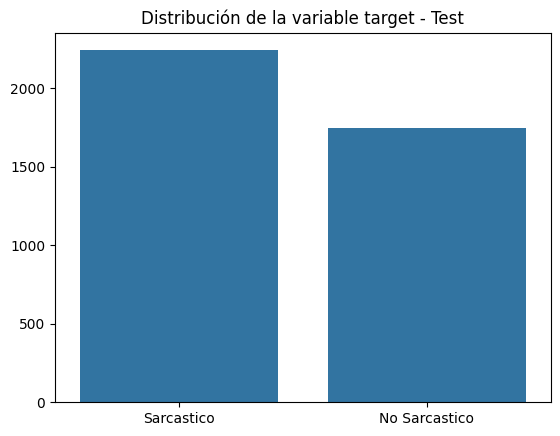

In [ ]:
target_dist = pd.Series(y_test).value_counts()
sns.barplot(x=np.array(['Sarcastico','No Sarcastico']),y=target_dist.values)
plt.title('Distribución de la variable target - Test')
plt.show()

## Generamos el vocabulario y transformarmos los datos de entrada en enteros

In [ ]:
#from utils import cleaning_text_data

# clean_sentences, words_list = cleaning_text_data(X_train) #Observar que solo vamos a necesitar la lista de palabras del dataset de entrenamiento
# clean_sentences_val, words_val = cleaning_text_data(X_val)
# clean_sentences_test, words_test = cleaning_text_data(X_test)

In [ ]:
# get a set of words from X_train array of words
words_list = set(' '.join(X_train).split(' '))
words_val = set(' '.join(X_val).split(' '))
words_test = set(' '.join(X_test).split(' '))

In [ ]:
# Get the list of words in words_val not in words_list
diff_val = set(words_val) - set(words_list)
diff_test = set(words_test) - set(words_list)
# print number and percetage of words in validation and test set that are not in the training set
print(f'Validation not in training: {len(diff_val)} - {len(diff_val)/len(words_val)*100:.2f}%')
print(f'Test not in training: {len(diff_test)} - {len(diff_test)/len(words_test)*100:.2f}%')

Validation not in training: 1952 - 20.48%
Test not in training: 2060 - 21.22%


In [ ]:
print(list(diff_val)[:10])
print(list(diff_test)[:10])


['brutalized', 'chatroom', 'ineptly', 'om', 'undetectable', 'fundraiser', 'reasonably', 'managers', 'lg', 'browsed']
['beachgoers', 'zales', 'reuther', 'fundraiser', 'giudice', 'observational', 'lynche', 'unregistered', 'tunisia', 'scholar']


**Pregunta:**
- Como afectan las palabras fuera del copus a la calidad de la detección?
- Hay un porcentaje recomendado?

In [ ]:
def build_dictionary(words: list) -> Dict:
  """
  This function takes a list of words and generates a dictionary where is word is counted
  according its ocurrence.
  Examples:
  - Input: [house, dad, dog, house]
  - Output: {'dad': 1, 'dog':1 , 'house': 2}
  """
  ## Build a dictionary that maps words to integers
  #contar la frecuencia de cada palabra en la lista words.
  counts = Counter(words)
  #Ordena las palabras en counts en función de sus frecuencias, de mayor a menor.
  vocab = sorted(counts, key=counts.get, reverse=True)
  #This dictionary comprehension creates a dictionary that maps each word in vocab to its position in the list, starting from 1.
  vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
  return vocab_to_int


In [ ]:
mapping_word_to_int_dict = build_dictionary(words_list)

**Pregunta:**
- Como afecta que varias palabras puedan tener el mismo numero de ocurrencias?


In [ ]:
print(mapping_word_to_int_dict['one'])
print(mapping_word_to_int_dict['dad'])
try:
  print(mapping_word_to_int_dict['non-existent-word'])
except KeyError as e:
    print(f'Error: {e}')



18560
2475
Error: 'non-existent-word'


Transformación de los headlines a lista de enteros

In [ ]:
def mapping_reviews_to_int(clean_sentences, words_mapping):
  """
  This function takes a list of list of sentences with text
  and a dictionary mapping words to integers as a input
  and generarates the integers version of that text
  """
  reviews_int = []
  for sentence in clean_sentences:
    reviews_int.append([words_mapping.get(word,0) for word in sentence.split() if word in mapping_word_to_int_dict.keys()])
  return reviews_int

In [ ]:
headline_int = mapping_reviews_to_int(X_train, mapping_word_to_int_dict)
print(headline_int[0])
print(len(headline_int[0]))

[5005, 11921, 492, 5027, 6065, 19135, 6051, 12851, 6902, 14260]
10


In [ ]:
headline_int_val = mapping_reviews_to_int(X_val, mapping_word_to_int_dict)
headline_int_test = mapping_reviews_to_int(X_test, mapping_word_to_int_dict)


#### Headlines de longitud cero

Dado que el lenguaje esta determinado por el set de training.
Puede pasar que algunos de los elementos de los conjuntos de validación o test terminen con longitud cero, por lo que se puede utilizar y es necesario removerlos.

In [ ]:
def remove_zero_length(reviews_int, label_array):
  """
  This function removes sentences having zero-length.
  """
  # get indices of any reviews with length 0
  non_zero_idx = [ii for ii, review in enumerate(reviews_int) if len(review) != 0]
  # remove 0-length reviews and their labels
  reviews_int_clean = [reviews_int[ii] for ii in non_zero_idx]
  label_array_clean = np.array([label_array[ii] for ii in non_zero_idx])
  return reviews_int_clean, label_array_clean

In [ ]:
headline_int_clean, label_array_clean = remove_zero_length(headline_int, y_train)
print('Number of reviews before removing outliers: ', len(headline_int))
print('Number of reviews before removing outliers: ', len(headline_int_clean))



Number of reviews before removing outliers:  18617
Number of reviews before removing outliers:  18617


In [ ]:
headline_int_val_clean, label_array_val_clean = remove_zero_length(headline_int_val, y_val)
print('Number of reviews before removing outliers: ', len(headline_int_val))
print('Number of reviews before removing outliers: ', len(headline_int_val_clean))


Number of reviews before removing outliers:  3990
Number of reviews before removing outliers:  3989


In [ ]:
headline_int_test_clean, label_array_test_clean = remove_zero_length(headline_int_test, y_test)
print('Number of reviews before removing outliers: ', len(headline_int_test))
print('Number of reviews before removing outliers: ', len(headline_int_test_clean))

Number of reviews before removing outliers:  3990
Number of reviews before removing outliers:  3986


#### Padding de las reseñas

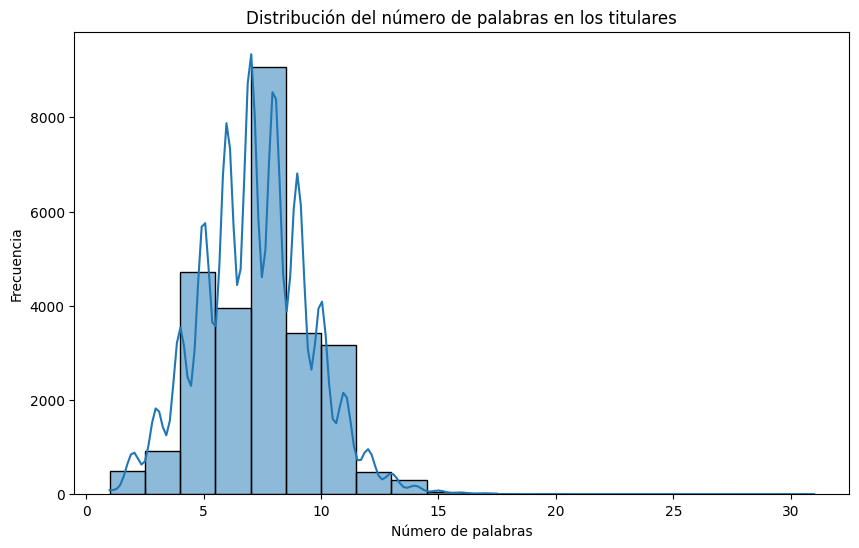

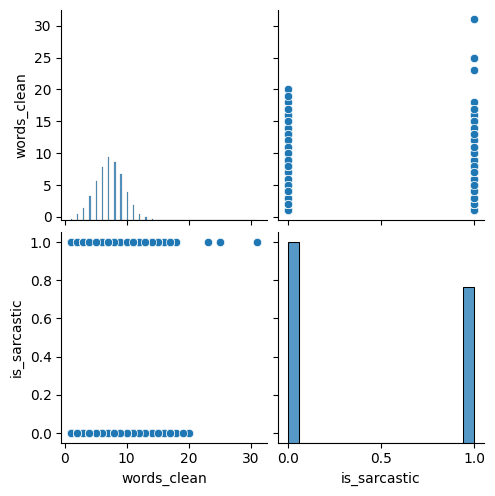

In [ ]:
# calcaulate the number of words in the headlines
df_sarcasm_src['words_clean'] = df_sarcasm_src['headline_clean'].apply(lambda x: len(x.split()))

# plot the distribution of the number of words
plt.figure(figsize=(10, 6))
sns.histplot(df_sarcasm_src['words_clean'], bins=20, kde=True)
plt.title('Distribución del número de palabras en los titulares')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()
# pairplot de las palabras y el target
sns.pairplot(df_sarcasm_src[['words_clean', 'is_sarcastic']])


In [ ]:
# calculate the percentil 90 of the number of words
def percentile_words(x):
    percentile = df_sarcasm_src['words_clean'].quantile(x)
    print(f'Percentil No Palabras {x*100:0.0f}: {percentile}')
    print(f'Palabras Headlines - Regitros  percentil > {x*100}: {len(df_sarcasm_src[df_sarcasm_src["words_clean"] > percentile])}')
    print()
    return percentile

p75 = percentile_words(0.75)
p90 = percentile_words(0.90)
p95 = percentile_words(0.95)



Percentil No Palabras 75: 9.0
Palabras Headlines - Regitros  percentil > 75.0: 4021

Percentil No Palabras 90: 10.0
Palabras Headlines - Regitros  percentil > 90.0: 1950

Percentil No Palabras 95: 11.0
Palabras Headlines - Regitros  percentil > 95.0: 863



In [ ]:
def pad_features(data_ints, seq_length):
    '''
    Return features of review_ints, where each review is padded with 0's
    or truncated to the input seq_length.
    '''
    # Creamos una matriz de ceros de tamaño (len(reviews_ints), seq_length)
    features = np.zeros((len(data_ints), seq_length), dtype=int)

    # Tomamos cada review, si la secuencia es más larga que seq_length cortamos ahi
    # En caso contrario, se completa con ceros al principio
    # En el siguiente loop vamos a completar la matriz, fila por fila
    for i, row in enumerate(data_ints):
        try:
            features[i, -len(row):] = np.array(row)[:seq_length]
        except:
            print(i, row)
            raise
    return features

In [ ]:
# headline_int[1]
TEST =[
    [1, 2, 3, 4, 5],
    [6, 8, 9],
    [1, 2, 3, 4, 6, 8]
]
pad_features(TEST, 5)

array([[1, 2, 3, 4, 5],
       [0, 0, 6, 8, 9],
       [1, 2, 3, 4, 6]])

In [ ]:
# Tomamos el percentil 95 como seq_length
seq_length = p95.astype(int)

features = pad_features(headline_int_clean, seq_length=seq_length)
features_val = pad_features(headline_int_val_clean, seq_length=seq_length)
features_test = pad_features(headline_int_test_clean, seq_length=seq_length)

# Dataloaders

In [ ]:
# dataloaders
batch_size = 32 # Esto afecta al error? En que afecta?
# RuntimeError: Expected hidden[0] size (1, 17, 256), got [1, 50, 256]


# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(features), torch.from_numpy(label_array_clean))
valid_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(label_array_val_clean))
test_data = TensorDataset(torch.from_numpy(features_test), torch.from_numpy(label_array_test_clean))

# DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True) #validation and test should always have shuffle in False
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

# Modelo de detección de sarcasmo


In [ ]:
class SarcasmRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self,
                 vocab_size,
                 output_size,
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 bidirectional=False,
                 dropout_lstm=0,
                 dropout_layer = 0):
        """
        Initialize the model by setting up the layers.
        """
        super(SarcasmRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.n_inputs = 2
        else:
            self.n_inputs = 1

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout_lstm, batch_first=True, bidirectional=self.bidirectional) #Solo se aplica dropout cuando n_layers>1
        # batch_first= True hace que la forma esperada de los inputs sea (batch_size, sequence_length, input_size)

        # dropout layer
        self.dropout = nn.Dropout(dropout_layer)

        # linear and sigmoid layers
        # print(f'Hidden Dim: {hidden_dim}')
        # print(f'Output Size: {output_size}')

        self.linear = nn.Linear(hidden_dim * self.n_inputs, output_size )
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """

        # print(f'#### DEBUG ####')
        # print(f'Forward - x: {x.shape}')
        # print(f'Forward - hidden 0: {hidden[0].shape}')
        # print(f'Forward - hidden 1: {hidden[1].shape}')


        batch_size = x.size(0) #Se utiliza para obtener el tamaño del batch y se usa en conjunto con batch_first=True
        # print(f'Forward - batch_size: {batch_size}')

        # embeddings and lstm_out
        x = x.long() # La capa de embedding requieren que las entradas sean de tipo long
        embeds = self.embedding(x)
        # print(f'Embeds: {embeds.shape}')

        # print(f'Hidden 0: {hidden[0].shape}')
        # print(f'Hidden 1: {hidden[1].shape}')

        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)

        # print(f'Out: {out.shape}')

        out = self.linear(out)
        # sigmoid function
        sig_out = self.sigmoid(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden


    # Por que el batch_size no es un parametro?
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''

        # print(f'Init Hidden - batch_size: {batch_size}')
        # device tambien debería ser un parametro
        use_cuda = torch.cuda.is_available()
        device = torch.device('cuda') if use_cuda else torch.device('cpu')
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,



        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers*self.n_inputs, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers*self.n_inputs, batch_size, self.hidden_dim)).to(device)

        hidden = (h0,c0)

        return hidden


## Libs

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

### Accuracy function



In [ ]:
# function to predict accuracy
def acc(pred,label):
  """
  Cuenta el número total de predicciones correctas comparando las etiquetas predichas con las etiquetas reales.
  Args:
      pred (torch.Tensor): Tensor que contiene las predicciones del modelo. Se espera que sea un tensor de probabilidades que se redondeará para obtener valores binarios (0 o 1).
      label (torch.Tensor): Tensor que contiene las etiquetas reales correspondientes a los datos.
  Returns:
      int: Número total de predicciones correctas.
    """
  #Nos aseguramos que tanto pred como label tengan las mismas dimensiones
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()  # Contar predicciones correctas


In [ ]:
def precision(pred, label):
    """
    Calcula la precisión de las predicciones comparando las etiquetas predichas con las etiquetas reales.
    Args:
        pred (torch.Tensor): Tensor que contiene las predicciones del modelo.
        label (torch.Tensor): Tensor que contiene las etiquetas reales.
    Returns:
        float: Precisión de las predicciones (TP / (TP + FP)).
    """
    pred = torch.round(pred.squeeze())
    true_positives = torch.sum((pred == 1) & (label == 1)).item()
    predicted_positives = torch.sum(pred == 1).item()

    if predicted_positives == 0:
        return 0.0  # Avoid division by zero

    return true_positives / predicted_positives


def recall(pred, label):
    """
    Calcula el recall (sensibilidad) de las predicciones.
    Args:
        pred (torch.Tensor): Tensor que contiene las predicciones del modelo.
        label (torch.Tensor): Tensor que contiene las etiquetas reales.
    Returns:
        float: Recall de las predicciones (TP / (TP + FN)).
    """
    pred = torch.round(pred.squeeze())
    true_positives = torch.sum((pred == 1) & (label == 1)).item()
    actual_positives = torch.sum(label == 1).item()

    if actual_positives == 0:
        return 0.0  # Avoid division by zero

    return true_positives / actual_positives


def f1_score(pred, label):
    """
    Calcula el F1-score de las predicciones.
    Args:
        pred (torch.Tensor): Tensor que contiene las predicciones del modelo.
        label (torch.Tensor): Tensor que contiene las etiquetas reales.
    Returns:
        float: F1-Score de las predicciones (2 * (precision * recall) / (precision + recall)).
    """
    p = precision(pred, label)
    r = recall(pred, label)

    if p + r == 0:
        return 0.0  # Avoid division by zero

    return 2 * (p * r) / (p + r)


In [ ]:
class Logger:
    def __init__(self, level='info'):
        self.level = level

    def debug(self, message):
        if self.level == 'debug':
            print(message)

    def info(self, message):
        if self.level in ['info', 'debug']:
            print(message)

### Learning curves plot function

In [ ]:
def learning_curves_plot(epoch_tr_acc,
                         epoch_vl_acc,
                         epoch_tr_loss,
                         epoch_vl_loss,
                         dict_params):
    ## Get the values of hyperparameters from dict_params
    hidden_size = dict_params['hidden_size']
    emb_dim = dict_params['emb_dim']
    lr = dict_params['lr']
    epochs = dict_params['epochs']
    dropout_lstm = dict_params.get('dropout_lstm',0)
    dropout_layer = dict_params.get('dropout_layer',0)
    weight_decay = dict_params.get('weight_decay',0)
    lstm_layers = dict_params['lstm_layers']
    early_stopping = dict_params.get('early_stopping',False)
    bidirectional = dict_params.get('bidirectional',False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot accuracy
    ax1.plot(epoch_tr_acc, label='Train Acc',marker='o')
    ax1.plot(epoch_vl_acc, label='Validation Acc',marker='o')
    ax1.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax1.set_title("Accuracy")
    ax1.legend()
    ax1.grid()

    # Plot loss
    ax2.plot(epoch_tr_loss, label='Train Loss', marker='o')
    ax2.plot(epoch_vl_loss, label='Validation Loss',marker='o')
    ax2.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax2.set_title("Loss")
    ax2.legend()
    ax2.grid()
    plt.suptitle(f'Hiperparametros:\n hidden_size={hidden_size} \n  emb_dim={emb_dim} \n lr={lr} \n epochs={epochs}\n'
                 f'dropout_lstm={dropout_lstm} \n dropout_layer={dropout_layer}\n  lstm_layers={lstm_layers},\n  early_stopping={early_stopping},\n  weight_decay={weight_decay}'
                 f'\n early_stopping={early_stopping} \n bidirectional={bidirectional}',
                 fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Acomodar automáticamente los gráficos y el título
    plt.show()
    return None


### Training model function

In [ ]:
def training_model(model,
                  train_loader,
                  valid_loader,
                  n_epochs,
                  criterion,
                  acc,
                  batch_size,
                  optimizer,
                  gradient_clip= None,
                  early_stopping: bool = False,
                  debug_level='info'):

      logger = Logger(level=debug_level)
      clip = gradient_clip
      epochs = n_epochs
      valid_loss_min = np.Inf

      # epochs acc and loss
      epoch_tr_loss = []
      epoch_vl_loss = []
      epoch_tr_acc = []
      epoch_vl_acc = []

      # Early stopping
      if early_stopping:
        patience = 5  # Número de épocas hasta la deteccion
        epochs_count = 0

      for epoch in range(epochs):
        # Entrenamiento del modelo en una epoca
        model.train()
        logger.debug(f'Entrenamiento Epoch: {epoch+1}')
        train_losses = []
        train_acc = 0.0
        # initialize hidden state in zero
        hidden = model.init_hidden(batch_size)

        logger.debug(f'Procesando los datos del loader Training -  Epoch: {epoch+1}')
        for inputs, labels in tqdm(train_loader):
            # device should be a parameter
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad() #Limpiamos los gradientes

            #Realizamos un paso hacia adelante
            hidden = tuple([each.data for each in hidden])
            output,hidden = model(inputs,hidden)

            # #Calculamos la loss
            loss = criterion(output.squeeze(), labels.float()) # El loss se usa para ver si el modelo mejora
            loss.backward()

            train_losses.append(loss.item())

            # Calcular accuracy
            accuracy = acc(output, labels)
            train_acc  +=accuracy

            if clip is not None:
              nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # Aca es donde se actualizan los pesos

        model.eval()
        logger.debug(f'Evaluacion Epoch: {epoch+1}')
        with torch.no_grad():
            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0
            logger.debug(f'Procesando los datos del loader Evaluacion -  Epoch: {epoch+1}')
            for inputs, labels in valid_loader:
                    val_h = tuple([each.data for each in val_h])
                    inputs, labels =  inputs.to(device), labels.to(device)
                    output, val_h = model(inputs, val_h)
                    # Como funciona esto del criterio?
                    val_loss = criterion(output.squeeze(), labels.float())
                    val_losses.append(val_loss.item())
                    # Calcular accuracy
                    accuracy = acc(output, labels)
                    val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_train_acc = train_acc / len(train_loader.dataset)
        epoch_val_acc = val_acc / len(valid_loader.dataset)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)

        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        logger.debug(f'Epoch {epoch+1}')
        logger.debug(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        logger.debug(f'train_accuracy : {epoch_train_acc} val_accuracy : {epoch_val_acc}')
        # print(25*'==')
        # print(f'Training   Loss list: {train_losses}')
        # print(f'Validation Loss list: {val_losses}')

        # if epoch_val_loss <= valid_loss_min:
        if epoch_val_loss < valid_loss_min:
            torch.save(model.state_dict(), 'state_dict.pt')
            logger.info('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
            if early_stopping:
              epochs_count = 0  # Reiniciar si el modelo mejora
              logger.debug(f'epochs_count: {epochs_count}')
        elif early_stopping:
            epochs_count += 1  # Incrementar si el modelo no mejora
            logger.debug(f'epochs_count: {epochs_count}')
        if early_stopping==True:
          if epochs_count >= patience:
            logger.info(f'epochs_count: {epochs_count}')
            logger.info(f'Early stopping triggered after {epochs_count} epochs.')
            break
        print(25*'==')

      return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss

## BASE MODEL


In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(mapping_word_to_int_dict)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = int(vocab_size ** (1/4)) # De donde sale?
hidden_dim = 128    # De donde sale? - Son los features que aparecen abajo Linear(in_features...
n_layers = 1
epochs = 10
gradient_clip= None
bidirectional = True
# loss and optimization functions
lr=0.001
base_model = SarcasmRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional)



# moving to gpu
base_model.to(device)

# imbalance_ratio = total_sarcastic / total_non_sarcastic
# class_weights = torch.tensor([1.0, imbalance_ratio]).to(device)
# criterion = nn.BCELoss(weight=class_weights).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)

print(base_model)

SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
num_params = count_parameters(base_model)
print(f'Número total de parámetros entrenables: {num_params}')

Número total de parámetros entrenables: 402309


In [ ]:
basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss = training_model(base_model,
                     train_loader,
                     valid_loader,
                     n_epochs=epochs,
                     criterion=criterion,
                     acc=acc,
                     batch_size=batch_size,
                     optimizer=optimizer
                     )

  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.655890).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.655890 --> 0.602865).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.602865 --> 0.574894).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.574894 --> 0.552817).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.552817 --> 0.539585).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

In [ ]:
dict_params = {}
dict_params['hidden_size'] = hidden_dim
dict_params['emb_dim']= embedding_dim
dict_params['bidirectional']= bidirectional
dict_params['lr'] = lr
dict_params['epochs'] = epochs
dict_params['dropout_lstm'] =0
dict_params['dropout_layer'] =0
dict_params['lstm_layers'] = n_layers

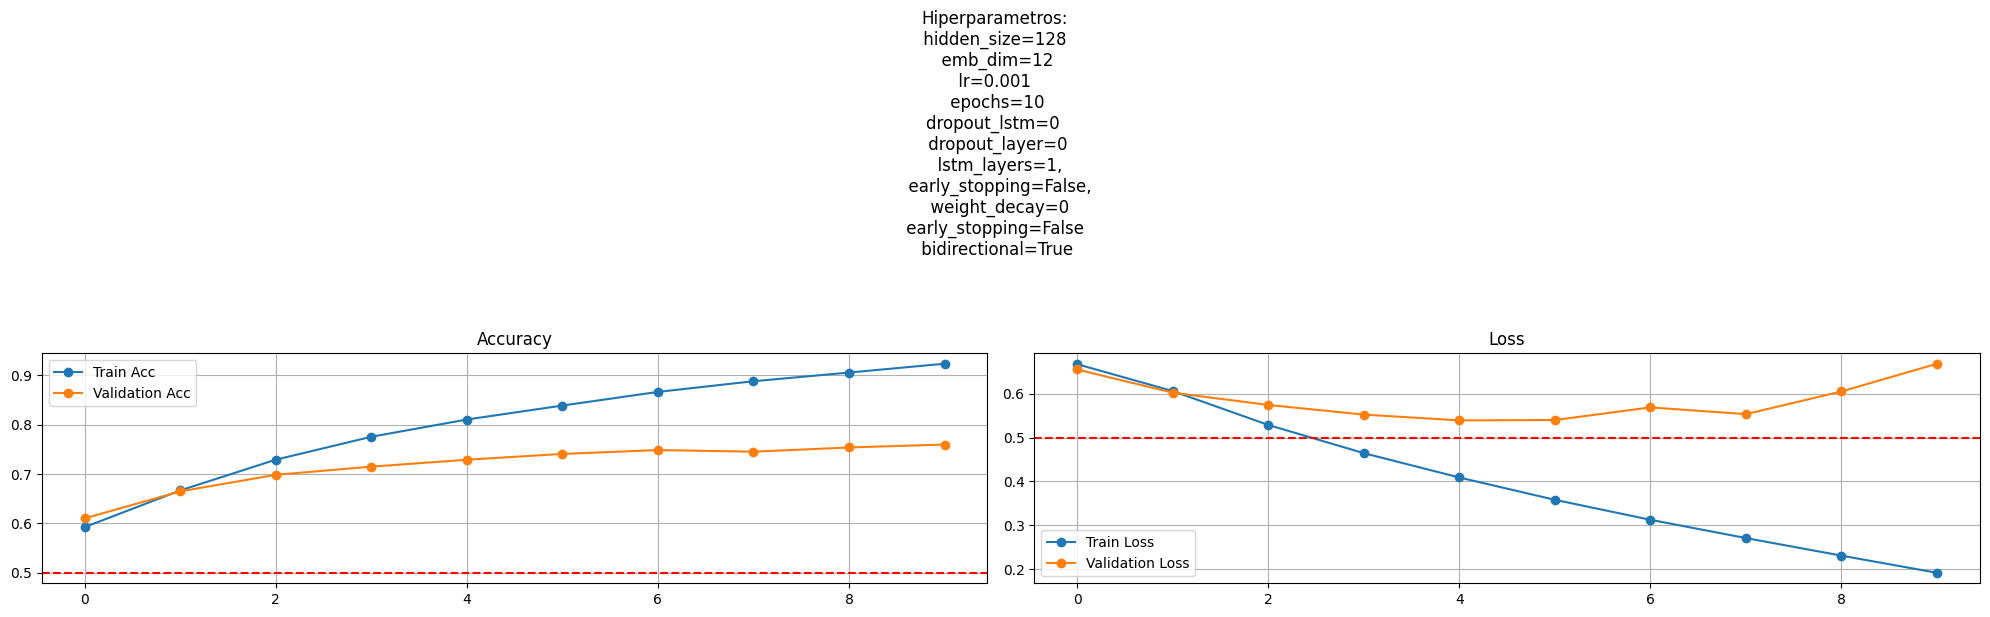

In [ ]:
learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)

In [ ]:
[basem_epoch_tr_acc]

[[0.5926303915775903,
  0.6670247623140141,
  0.7293334049524628,
  0.7757963151957888,
  0.810764355159263,
  0.8390718160820755,
  0.8667347048396626,
  0.8883815867218134,
  0.9059461782242036,
  0.9238867701563087]]

In [ ]:
[basem_epoch_vl_acc]

[[0.6104286788668839,
  0.6650789671596892,
  0.6986713462020556,
  0.7152168463274003,
  0.7292554524943595,
  0.7410378540987717,
  0.7488092253697669,
  0.7455502632238656,
  0.7540737026823765,
  0.7600902481825019]]

En el entrenamiento el accuracy es bastante alto (0.92 aproximadamente) y aumenta consistentemente a lo largo de las épocas. Mientras que, en el conjunto de validación el accuracy es mucho menor (0.76) y parece estacarse luego de algunas épocas. Este comportamiento suguiere que el modelo puede estar sobreajustando.

En el gráfico de loss, en el conjunto de entrenamiento la loss disminuye constantemente a medida que aumentan las épocas. En constraste, vemos que en validación la loss disminuye inicialmente pero luego comienza a aumentar. Esto también es un indicador de sobreajuste.

# Using Tokenization libs



In [ ]:
# ! pip install tensorflow -q

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

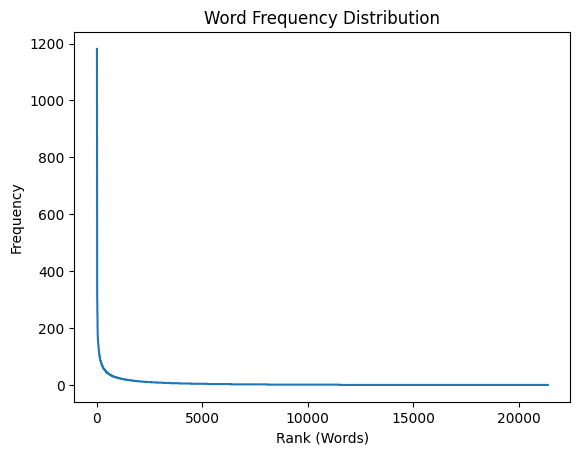

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Fit the tokenizer only on the training set
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Get the word counts
word_counts = tokenizer.word_counts
word_freqs = sorted(word_counts.values(), reverse=True)

# Plot the word frequency distribution
plt.plot(word_freqs)
plt.title('Word Frequency Distribution')
plt.xlabel('Rank (Words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
total_word_count = sum(word_counts.values())
cumulative_coverage = 0
max_vocab_size = 0
desired_coverage = 95  # Desired coverage percentage (e.g., 95%)

# Calculate how many words to keep for the desired coverage
for count in word_freqs:
    cumulative_coverage += count / total_word_count
    max_vocab_size += 1
    if cumulative_coverage >= desired_coverage:
        break

print(f"Vocabulary size to cover {desired_coverage * 100}% of the text: {max_vocab_size}")


Vocabulary size to cover 9500% of the text: 21386


In [ ]:
# max_vocab_size = 10000  # Vocabulary size
# print seq_length
print(f"Sequence length: {seq_length}")
print(f'Max Vocabulary size: {max_vocab_size}')

# Tokenize and convert text to sequences
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences   = tokenizer.texts_to_sequences(X_train)
X_val_sequences     = tokenizer.texts_to_sequences(X_val)
X_test_sequences    = tokenizer.texts_to_sequences(X_test)


X_train_padded = pad_sequences(X_train_sequences, maxlen=seq_length, padding='pre', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=seq_length, padding='pre', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=seq_length, padding='pre', truncating='post')



Sequence length: 11
Max Vocabulary size: 21386


In [ ]:
# features[0:10]
label_array_clean[0:10]

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 0])

In [ ]:
# train_data = TensorDataset(torch.from_numpy(features), torch.from_numpy(label_array_clean))
#, label_array_clean[0:10]
# X_train_padded[0:10]
y_train[0:10]

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 0])

In [ ]:
# print df_sarcasm_src size
print(f'df_sarcasm_src size: {df_sarcasm_src.shape}')
# count headline_clean with length <=11
print(f'Headlines with length <= 11: {len(df_sarcasm_src[df_sarcasm_src["words_clean"] <= 11])}')

# print x_train size
print(f'X_train size: {len(X_train)}')
print(f'X_train size: {len(X_val)}')
print(f'X_train size: {len(X_test)}')
print(f'X_train_padded size: {X_train_padded.shape}')



df_sarcasm_src size: (26597, 11)
Headlines with length <= 11: 25734
X_train size: 18617
X_train size: 3990
X_train size: 3990
X_train_padded size: (18617, 11)


In [ ]:
print(f"Batch size: {batch_size}")
# create Tensor datasets
train_data2 = TensorDataset(torch.from_numpy(X_train_padded), torch.from_numpy(y_train))
valid_data2 = TensorDataset(torch.from_numpy(X_val_padded), torch.from_numpy(y_val))
test_data2 = TensorDataset(torch.from_numpy(X_test_padded), torch.from_numpy(y_test))

# DataLoaders
train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader2 = DataLoader(valid_data2, shuffle=False, batch_size=batch_size, drop_last=True) #validation and test should always have shuffle in False
test_loader2 = DataLoader(test_data2, shuffle=False, batch_size=batch_size, drop_last=True)

Batch size: 32


In [ ]:
vocab_size = len(mapping_word_to_int_dict)+1  #max_vocab_size # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = int(vocab_size ** (1/4))
hidden_dim = 128    # De donde sale? - Son los features que aparecen abajo Linear(in_features...
n_layers = 1
epochs = 10
gradient_clip = None
bidirectional = True
# dropout_lstm = 0.5
# dropout_layer = 0.5
# loss and optimization functions

vocab_size, output_size, embedding_dim, hidden_dim, n_layers
base_model2 = SarcasmRNN(
    vocab_size=vocab_size,
    output_size=output_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    bidirectional=bidirectional
    # dropout_lstm=dropout_lstm,
    # dropout_layer = dropout_layer
    )

# #moving to gpu
base_model2.to(device)
# imbalance_ratio = total_sarcastic / total_non_sarcastic
# class_weights = torch.tensor([1.0, imbalance_ratio]).to(device)
# criterion = nn.BCELoss(weight=class_weights)
criterion = nn.BCELoss()

lr=0.001
optimizer = torch.optim.Adam(base_model2.parameters(), lr=lr)

print(base_model2.parameters())
print("Vocabulario: ", vocab_size)
print("Salida: ", output_size)
print("Dimension de embedding: ", embedding_dim)
print("Dimension de hidden: ", hidden_dim)
print("Numero de capas: ", n_layers)
print("Epochs: ", epochs)
print("Learning rate: ", lr)
print("Batch size: ", batch_size)
print("Gradient clip: ", gradient_clip)

num_params = count_parameters(base_model2)
print(f'Número total de parámetros entrenables: {num_params}')

print(base_model2)

<generator object Module.parameters at 0x7d5b5c001070>
Vocabulario:  21387
Salida:  1
Dimension de embedding:  12
Dimension de hidden:  128
Numero de capas:  1
Epochs:  10
Learning rate:  0.001
Batch size:  32
Gradient clip:  None
Número total de parámetros entrenables: 402309
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss = training_model(base_model2,
                     train_loader2,
                     valid_loader2,
                     n_epochs=epochs,
                     criterion=criterion,
                     acc=acc,
                     batch_size=batch_size,
                     optimizer=optimizer,
                     gradient_clip= None,
                     early_stopping=True
                     )

  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.659437).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.659437 --> 0.612330).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

Validation loss decreased (0.612330 --> 0.597583).  Saving model ...


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/581 [00:00<?, ?it/s]

epochs_count: 5
Early stopping triggered after 5 epochs.


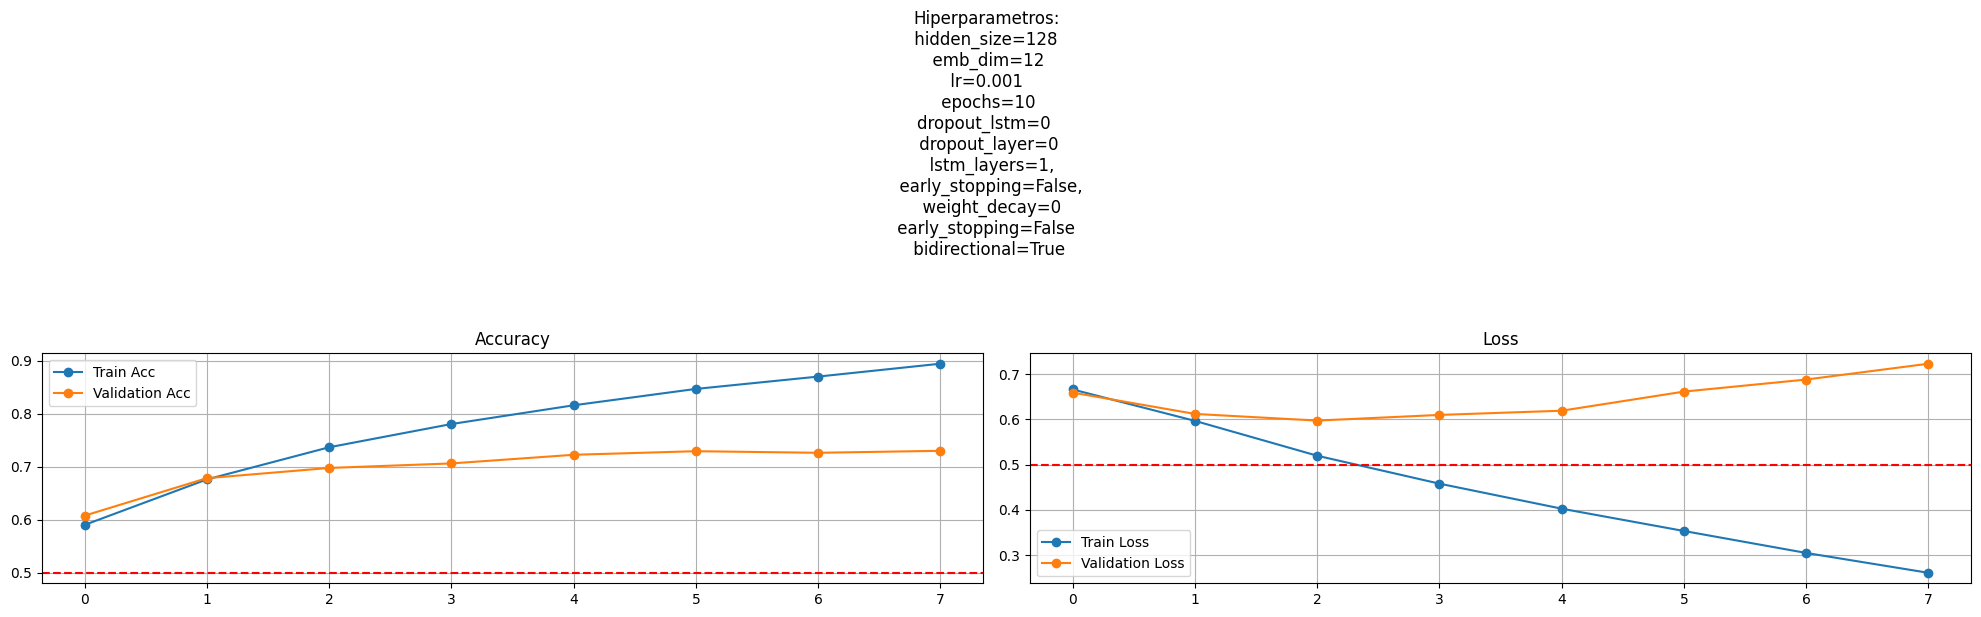

In [ ]:
learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)

In [ ]:
[basem_epoch_tr_acc]

[[0.5902669603050975,
  0.6760487726271687,
  0.736692270505452,
  0.7805231777407745,
  0.8158672181339636,
  0.8467529677176774,
  0.8700112800128914,
  0.8942901649030456]]

In [ ]:
[basem_epoch_vl_acc]

[[0.6077694235588973,
  0.6784461152882205,
  0.6977443609022557,
  0.706265664160401,
  0.7225563909774436,
  0.7293233082706767,
  0.7263157894736842,
  0.7300751879699248]]

Este modelo es similar al anterior pero en este caso la tokenización de los datos se hizo de otra manera, utilizando Tokenizer. En general, los tokenizadores suelen ser más efectivos para tokenizar y no tendríamos problemas si hubiesen palabras que presentan el mismo número de registros. Sin embargo, vemos que el modelo tiene un perfomance peor al anterior (accuracy de 0.89 para entrenamiento y 0.73 para validación). La disminución en el accuracy de validación en relación al accuracy de entrenamiento persiste y algo similar sucede para loss, ya que tiende a aumentar en validación. Esta tendencia indican, al igual que en el modelo base, sobreajuste.

# Otro modelo


In [ ]:
import torch
import torch.nn as nn

class SarcasmGRU(nn.Module):
    """
    The GRU model for sentiment analysis.
    """

    def __init__(self,
                 vocab_size,
                 output_size,
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout_gru=0,
                 dropout_layer=0,
                 bidirectional=True):
        """
        Initialize the model by setting up the layers.
        """
        super(SarcasmGRU, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=dropout_gru,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_layer)

        # Linear and sigmoid layers
        self.linear = nn.Linear(hidden_dim * self.num_directions, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # Embedding and GRU layers
        x = x.long()  # Embedding layer requires inputs to be of type long
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)

        # Get the last time step output for both directions
        gru_out = gru_out[:, -1, :]

        # Dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.linear(out)

        # Sigmoid function
        sig_out = self.sigmoid(out)

        # Return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        use_cuda = torch.cuda.is_available()
        device = torch.device('cuda') if use_cuda else torch.device('cpu')

        # Adjust hidden dimensions for bidirectionality
        h0 = torch.zeros((self.n_layers * self.num_directions, batch_size, self.hidden_dim)).to(device)
        return h0


In [ ]:
import numpy as np
from tqdm import trange, tqdm
import torch


def training_gru_model(model,
                  train_loader,
                  valid_loader,
                  n_epochs,
                  criterion,
                  acc,
                  batch_size,
                  optimizer,
                  gradient_clip=None,
                  early_stopping: bool = False,
                  device='cpu',
                  debug_level='info'):

    logger = Logger(level=debug_level)

    clip = gradient_clip
    epochs = n_epochs
    valid_loss_min = np.Inf

    # Track epoch-wise training and validation metrics
    epoch_tr_loss = []
    epoch_vl_loss = []
    epoch_tr_acc = []
    epoch_vl_acc = []

    # Early stopping setup
    if early_stopping:
        patience = 5
        epochs_count = 0

    for epoch in trange(epochs, desc='Epoc in Progress', disable=False):
        # Training phase
        model.train()
        logger.debug(f'Training Epoch: {epoch + 1}')
        train_losses = []
        train_acc = 0.0
        hidden = model.init_hidden(batch_size).to(device)

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()  # Clear gradients

            # Forward pass
            hidden = hidden.data  # Reset hidden state for each batch
            output, hidden = model(inputs, hidden)

            # Compute loss and perform backpropagation
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

            # Calculate accuracy
            accuracy = acc(output, labels)
            train_acc += accuracy

            # Gradient clipping (if specified)
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()  # Update weights

        # Validation phase
        model.eval()
        logger.debug(f'Validation Epoch: {epoch + 1}')
        with torch.no_grad():
            val_hidden = model.init_hidden(batch_size).to(device)
            val_losses = []
            val_acc = 0.0
            for inputs, labels in valid_loader:
                val_hidden = val_hidden.data
                inputs, labels = inputs.to(device), labels.to(device)
                output, val_hidden = model(inputs, val_hidden)

                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

                accuracy = acc(output, labels)
                val_acc += accuracy

        # Calculate average losses and accuracies for the epoch
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc / len(train_loader.dataset)
        epoch_val_acc = val_acc / len(valid_loader.dataset)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        logger.debug(f'Epoch {epoch + 1}')
        logger.debug(f'train_loss: {epoch_train_loss} val_loss : {epoch_val_loss}')
        logger.debug(f'train_accuracy : {epoch_train_acc} val_accuracy : {epoch_val_acc}')

        # Model saving and early stopping
        if epoch_val_loss < valid_loss_min:
            torch.save(model.state_dict(), 'state_dict.pt')
            logger.debug('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
            valid_loss_min = epoch_val_loss
            if early_stopping:
                epochs_count = 0
        elif early_stopping:
            epochs_count += 1
            if epochs_count >= patience:
                logger.debug(f'Early stopping triggered after {epochs_count} epochs.')
                break
        # print('=' * 50)

    return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss


In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(mapping_word_to_int_dict)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = int(vocab_size ** (1/4)) # De donde sale?
hidden_dim = 128    # De donde sale? - Son los features que aparecen abajo Linear(in_features...
n_layers = 3
epochs = 10
gradient_clip= None
bidirectional = True
# loss and optimization functions
lr=0.001
base_model_gru = SarcasmGRU(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model_gru.parameters(), lr=lr)

# moving to gpu
base_model_gru.to(device)


SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss = training_gru_model(base_model_gru,
                     train_loader,
                     valid_loader,
                     n_epochs=epochs,
                     criterion=criterion,
                     acc=acc,
                     batch_size=batch_size,
                     optimizer=optimizer
                     )

100%|██████████| 581/581 [00:50<00:00, 11.54it/s]


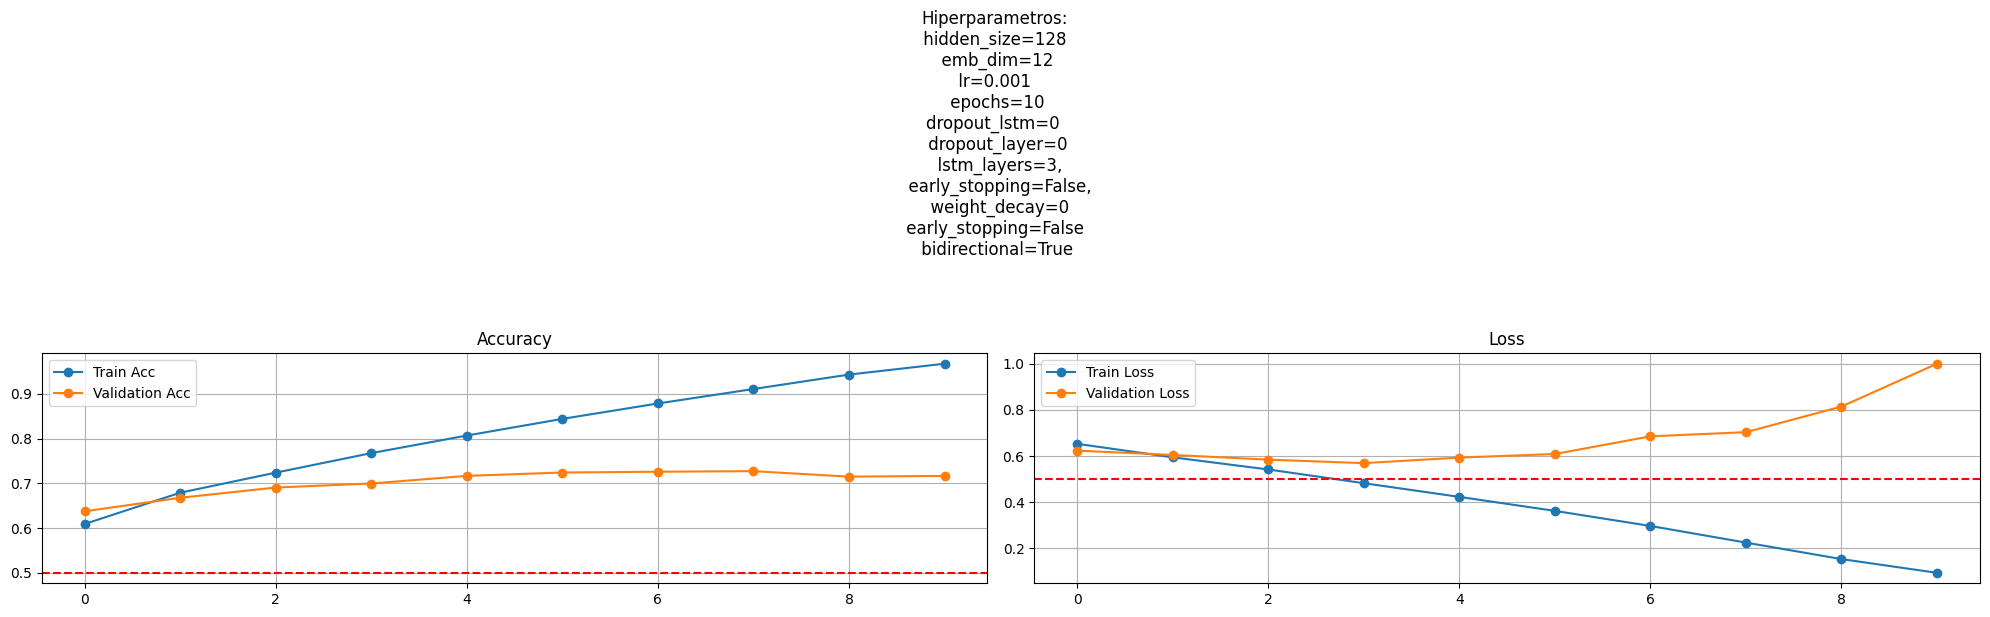

In [ ]:
dict_params = {}
dict_params['hidden_size'] = hidden_dim
dict_params['emb_dim']= embedding_dim
dict_params['bidirectional']= bidirectional
dict_params['lr'] = lr
dict_params['epochs'] = epochs
dict_params['dropout_lstm'] =0
dict_params['dropout_layer'] =0
dict_params['lstm_layers'] = n_layers
learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)


In [ ]:
[basem_epoch_tr_acc]

[[0.6092281248321426,
  0.679110490411989,
  0.7239619702422517,
  0.7675780200891659,
  0.8068969221679111,
  0.8441209647096739,
  0.8785518612021271,
  0.9108878981575979,
  0.9431165064188645,
  0.9674491056561207]]

In [ ]:
[basem_epoch_vl_acc]

[[0.637503133617448,
  0.6678365505139132,
  0.6906492855352219,
  0.6996741037854098,
  0.7167209827024317,
  0.7242416645775883,
  0.7259964903484583,
  0.7272499373276511,
  0.7149661569315618,
  0.7167209827024317]]

En este caso cambiamos la arquitectura del modelo, en vez de utilizar RNN utilizamos GRU. Básicamente esta arquitectura permite que el modelo retenga por mas tiempo la información de las salidas anteriores. Vemos que en terminos generales el modelo se comporta de manera similar a los dos anteriores. El accuracy en train es bastante alto (0.96) y disminuye sustancialmente en validación (0.71), indicando sobreajuste. En loss, también se repite las tendencias de los modelos anteriores, loss en entrenamiento tiende a disminuir, mientras que en validación aumenta.  

# Busqueda de Parametros

Creamos una funcion para generar conbinaciones de parametros y con esa lista más los parametros de entrenamiento procederemos probar los modelos con una funcion que los procesa en forma consecutiva.

In [ ]:
from itertools import product
import json

def generate_combinations(params):

    normalized_params = {k: v if isinstance(v, list) else [v] for k, v in params.items()}

    keys = normalized_params.keys()
    values = normalized_params.values()


    combinations = [{'params': dict(zip(keys, combo))} for combo in product(*values)]

    return combinations

In [ ]:
training_params = {
    'train_loader': train_loader,
    'valid_loader': valid_loader,
    'n_epochs': 10,
    # 'criterion': criterion,
    'acc': acc,
    'batch_size': batch_size,
    # 'device': 'cpu'
    'early_stopping': True
}
# params_options = {
#     'vocab_size': len(mapping_word_to_int_dict)+1, # +1 for the 0 padding + our word tokens
#     'output_size': 1,
#     'embedding_dim': [int(vocab_size ** (1/4))],
#     'hidden_dim': [128],
#     'n_layers': [1],
#     'bidirectional': [True],
#     'lr': [0.001],
#     'criterion': [nn.BCELoss()]
# }

params_options = {
    'vocab_size': len(mapping_word_to_int_dict)+1, # +1 for the 0 padding + our word tokens
    'output_size': 1,
    'embedding_dim': [int(vocab_size ** (1/4))],
    'hidden_dim': [64, 128],
    'n_layers': [3, 5],
    'bidirectional': [True, False],
    'lr': [0.001, 0.01],
    'criterion': [nn.BCELoss(), nn.MSELoss() ] # vamos a jugar con esto
}

params_models = generate_combinations(params_options)

In [ ]:
def eval_models(models_list, model_class, training_func, training_params, print_plots='disabled'):
    best_metric = -1
    result = []
    print(f'Total models to evaluate: {len(models_list)}')
    model_idx = -1
    for model in models_list:
        model_idx += 1
        print(f'Processing model {model_idx + 1} of {len(models_list)}')
        rst_params = model['params'].copy()
        lr=rst_params['lr']

        model_params = rst_params.copy()
        model_params.pop('lr')
        criterion = model_params.pop('criterion')

        print(model_params)
        model_instance = model_class(**model_params)
        optimizer = torch.optim.Adam(model_instance.parameters(), lr=lr)
        print(model_instance)

        training_params['model'] = model_instance
        training_params['optimizer'] = optimizer
        training_params['criterion'] = criterion
        basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss = training_func(**training_params)
        # print(model_instance)
        # metric, loss = training_gru_model(model_instance, **params_tr, **data_loaders)
        print( basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss)
        # get last validation accuracy

        dict_params = {}
        dict_params['hidden_size'] = rst_params['hidden_dim']
        dict_params['emb_dim']= rst_params['embedding_dim']
        dict_params['bidirectional']= rst_params['bidirectional']
        dict_params['lr'] = rst_params['lr']
        dict_params['lstm_layers'] = rst_params['n_layers']
        dict_params['epochs'] = training_params['n_epochs']
        dict_params['dropout_lstm'] =0 # donde esta este parametro?
        dict_params['dropout_layer'] =0
        if print_plots == 'all':
            learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)

        model_rst = {
            'params': rst_params,
            'model': model_instance,
            'best_epoch_tr_acc': basem_epoch_tr_acc,
            'best_epoch_vl_acc': basem_epoch_vl_acc,
            'best_epoch_tr_loss': basem_epoch_tr_loss,
            'best_epoch_vl_loss': basem_epoch_vl_loss
        }

        result.append(model_rst)
        if basem_epoch_vl_acc[-1] > best_metric:
            best_metric = basem_epoch_vl_acc[-1]
            best_model = model_rst
            if print_plots == 'best_model':
                learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)

    return best_model, result



In [ ]:
len(params_models)

32

In [ ]:
# Dividivmos los modelos en dos grupos para ejecitarlos en forma separada
# asi evitamos el problema de limite de output en el notebook
# Tambien se redujo el numero de prints para evitar el mismo problema
params_models_g1 = params_models[0:16]
params_models_g2 = params_models[16:32]

## Modelo LSTM

Total models to evaluate: 16
Processing model 1 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:11<00:00, 51.02it/s]


Validation loss decreased (inf --> 0.642063).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 48.06it/s]


Validation loss decreased (0.642063 --> 0.605847).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 55.16it/s]


Validation loss decreased (0.605847 --> 0.572452).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 49.08it/s]


Validation loss decreased (0.572452 --> 0.546210).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 49.72it/s]


100%|██████████| 581/581 [00:12<00:00, 47.52it/s]


100%|██████████| 581/581 [00:12<00:00, 45.81it/s]


Validation loss decreased (0.546210 --> 0.544802).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 48.58it/s]


100%|██████████| 581/581 [00:15<00:00, 37.64it/s]


100%|██████████| 581/581 [00:14<00:00, 39.93it/s]


[0.5990761132298437, 0.6712144813879787, 0.728957404522748, 0.7747757426008487, 0.8096363538701187, 0.8410592469248537, 0.8632969866251275, 0.887737014556588, 0.9057313208357952, 0.9252833431809636] [0.6302331411381299, 0.6695913762847832, 0.7076961644522437, 0.7242416645775883, 0.7352719979944848, 0.7440461268488343, 0.7475557783905741, 0.7560792178490849, 0.7570819754324392, 0.7540737026823765] [0.6638674540076527, 0.6032728589750609, 0.5354008874671594, 0.4711814090840377, 0.41246135017342495, 0.35954678733151874, 0.3135993425283908, 0.2677834839808551, 0.22623318205499404, 0.18508286408682492] [0.6420634629264954, 0.6058467604940937, 0.5724522942496885, 0.546210297653752, 0.5568179456937697, 0.5605976627238335, 0.5448015185613786, 0.6459905120634264, 0.6820724337331711, 0.6530122677645376]


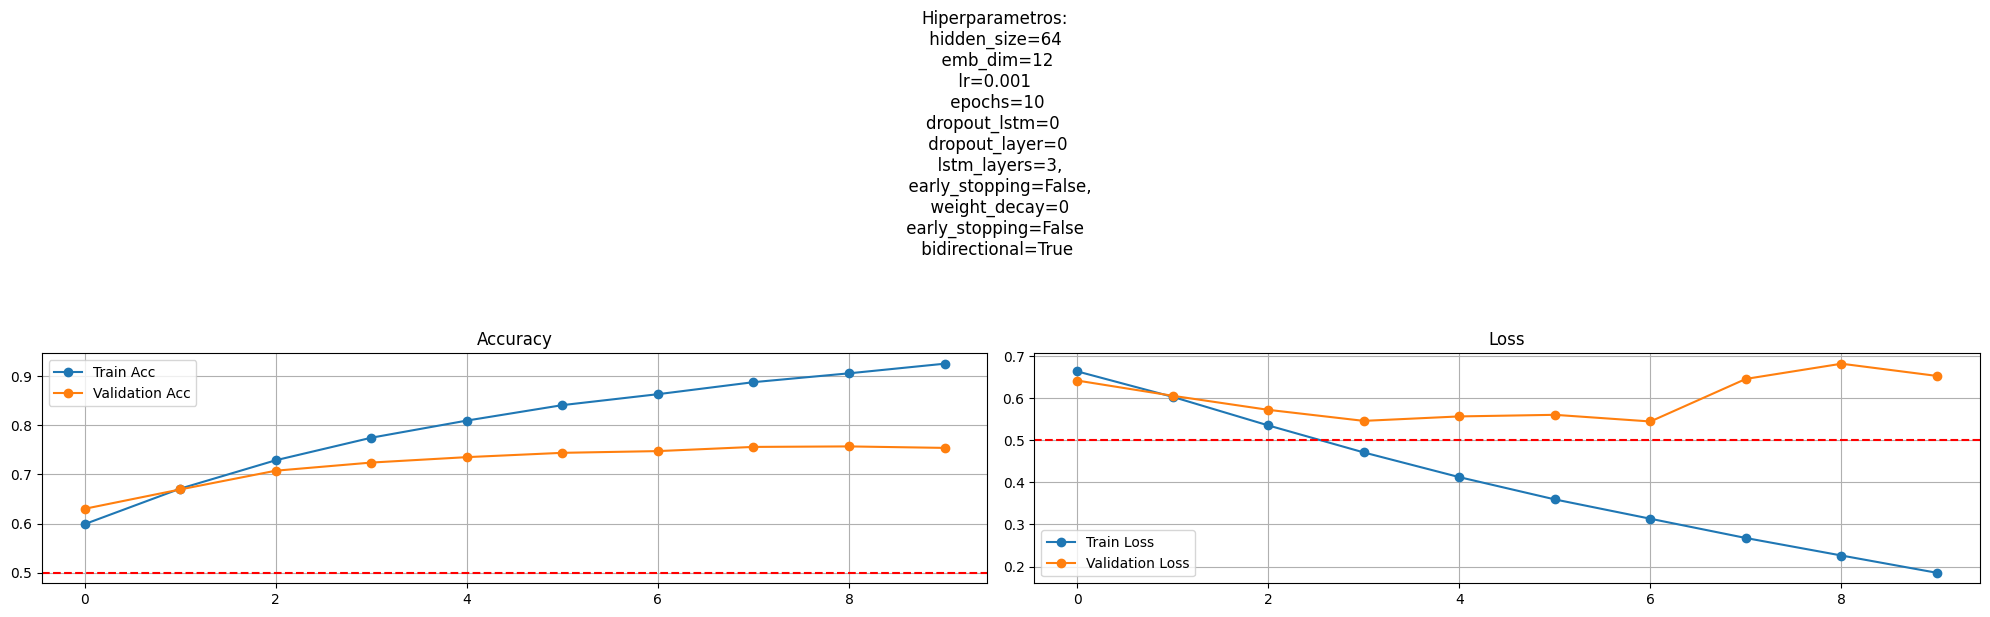

Processing model 2 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:13<00:00, 44.12it/s]


Validation loss decreased (inf --> 0.225462).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 51.69it/s]


Validation loss decreased (0.225462 --> 0.206059).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 49.63it/s]


Validation loss decreased (0.206059 --> 0.194073).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 46.19it/s]


Validation loss decreased (0.194073 --> 0.186704).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 47.44it/s]


Validation loss decreased (0.186704 --> 0.182469).  Saving model ...


100%|██████████| 581/581 [00:13<00:00, 44.40it/s]


Validation loss decreased (0.182469 --> 0.180940).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 48.65it/s]


100%|██████████| 581/581 [00:12<00:00, 46.04it/s]


100%|██████████| 581/581 [00:13<00:00, 42.68it/s]


100%|██████████| 581/581 [00:14<00:00, 41.15it/s]


[0.5915561046355482, 0.6776064886931299, 0.7404522748025998, 0.7779986034269754, 0.8116237847128969, 0.8399849599828114, 0.867862706128807, 0.8877907289036902, 0.9077724660256754, 0.9227587688671645] [0.6242165956380045, 0.6738530960140386, 0.7039358235146653, 0.7217347706192028, 0.7325144146402607, 0.7447981950363499, 0.735773376786162, 0.7442968162446728, 0.7523188769115067, 0.7450488844321885] [0.23634988297796494, 0.20532860311963266, 0.17592790810048273, 0.15280061657580574, 0.1330937070262309, 0.11634049043315824, 0.10014553008706865, 0.08656373326049512, 0.07403213030172964, 0.06369953287810266] [0.22546183017473068, 0.20605897603015746, 0.19407303895681136, 0.18670381395326507, 0.1824687285529029, 0.18093964643776417, 0.18780697623808537, 0.18735937068178768, 0.19131302397938504, 0.20204401460866775]
Processing model 3 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(2

100%|██████████| 581/581 [00:14<00:00, 40.26it/s]


Validation loss decreased (inf --> 0.685818).  Saving model ...


100%|██████████| 581/581 [00:14<00:00, 40.25it/s]


100%|██████████| 581/581 [00:14<00:00, 40.24it/s]


Validation loss decreased (0.685818 --> 0.567942).  Saving model ...


100%|██████████| 581/581 [00:14<00:00, 39.28it/s]


Validation loss decreased (0.567942 --> 0.531838).  Saving model ...


100%|██████████| 581/581 [00:15<00:00, 37.89it/s]


100%|██████████| 581/581 [00:15<00:00, 37.81it/s]


100%|██████████| 581/581 [00:17<00:00, 34.08it/s]


100%|██████████| 581/581 [00:16<00:00, 34.79it/s]


100%|██████████| 581/581 [00:18<00:00, 31.80it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5590052102916689, 0.5655046462910244, 0.7136488155986463, 0.8420261051726916, 0.8994467422248482, 0.9331256378578718, 0.9529462319385508, 0.9631519578879518, 0.9717462534242897] [0.5582852845324643, 0.559538731511657, 0.7262471797442969, 0.7498119829531211, 0.7483078465780898, 0.7560792178490849, 0.7711205815993983, 0.758335422411632, 0.7615943845575333] [0.6864694330245, 0.6834594084145486, 0.5695802041565079, 0.37961642523640815, 0.2636717329773148, 0.19230742991073202, 0.14704866371183253, 0.11440952640289694, 0.09235886565735002] [0.6858183606978385, 0.6909439318603084, 0.5679421657996793, 0.5318381702226977, 0.5690715630208293, 0.6357705691649068, 0.6331233676643141, 0.7434758056075342, 0.8468683051966852]


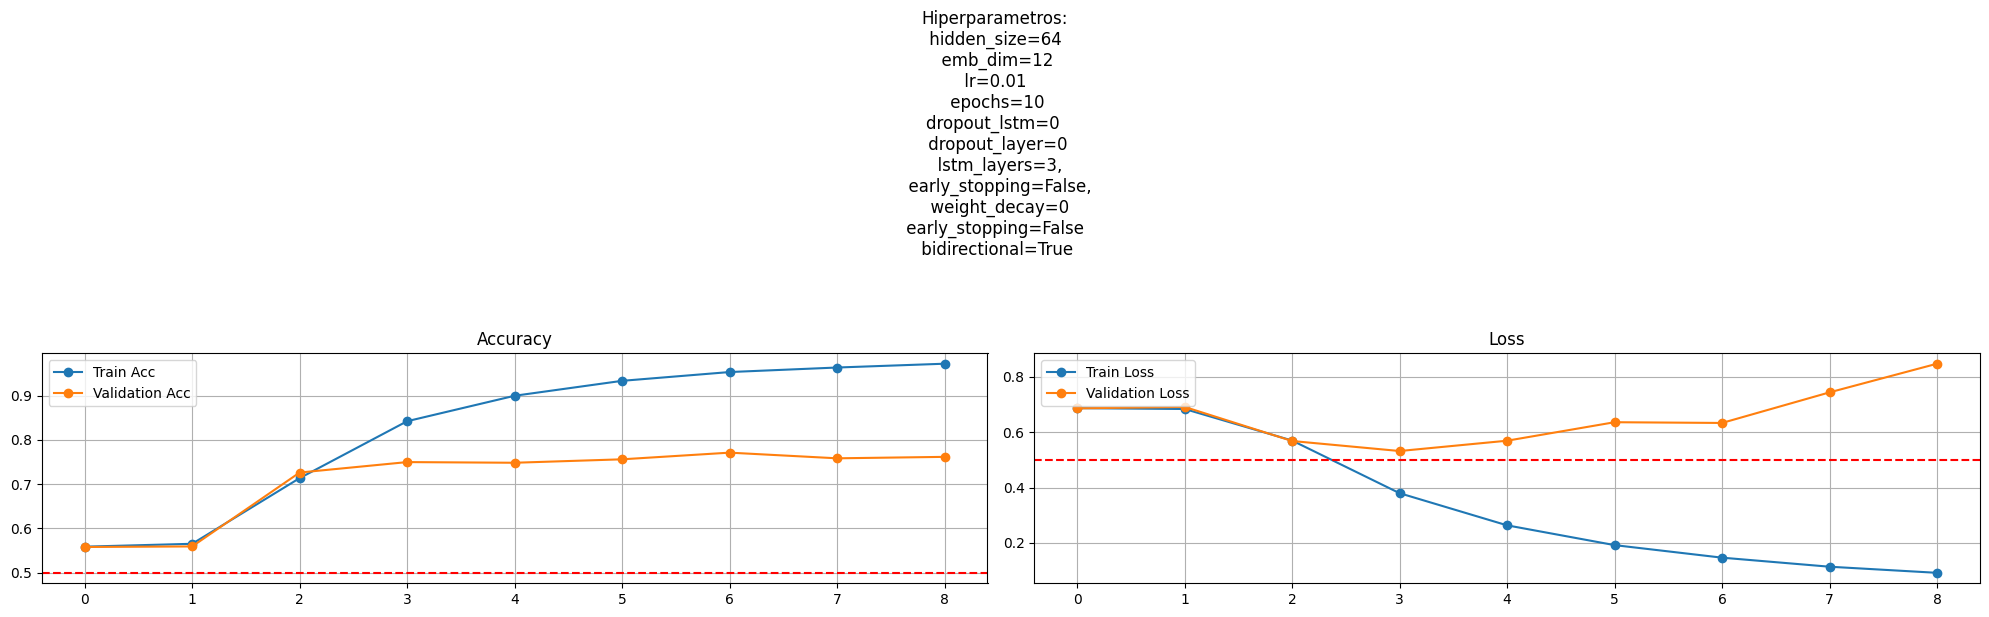

Processing model 4 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:13<00:00, 41.82it/s]


Validation loss decreased (inf --> 0.246351).  Saving model ...


100%|██████████| 581/581 [00:13<00:00, 43.62it/s]


Validation loss decreased (0.246351 --> 0.246257).  Saving model ...


100%|██████████| 581/581 [00:13<00:00, 44.39it/s]


Validation loss decreased (0.246257 --> 0.246251).  Saving model ...


100%|██████████| 581/581 [00:13<00:00, 41.60it/s]


Validation loss decreased (0.246251 --> 0.246162).  Saving model ...


100%|██████████| 581/581 [00:14<00:00, 39.20it/s]


100%|██████████| 581/581 [00:15<00:00, 36.80it/s]


100%|██████████| 581/581 [00:15<00:00, 37.50it/s]


100%|██████████| 581/581 [00:17<00:00, 33.34it/s]


100%|██████████| 581/581 [00:16<00:00, 34.58it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5583606381264435, 0.560992641134447, 0.5613149272170597, 0.5611537841757533, 0.5610463554815491, 0.5610463554815491, 0.5613149272170597, 0.5611537841757533, 0.5612074985228555] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24703724974711871, 0.24666324681033366, 0.2462877639394619, 0.24631791670843575, 0.24632862038435913, 0.24626893882291861, 0.2462112985153822, 0.2463472258306001, 0.24627692620438266] [0.24635064289454492, 0.2462573959942787, 0.24625087637574442, 0.2461617105910855, 0.24627195322705853, 0.24632240038725636, 0.24631167587734037, 0.24652062861188764, 0.24639393869907625]
Processing model 5 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(1

100%|██████████| 581/581 [00:07<00:00, 72.70it/s]


Validation loss decreased (inf --> 0.635197).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 78.89it/s]


Validation loss decreased (0.635197 --> 0.577111).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 72.20it/s]


Validation loss decreased (0.577111 --> 0.548951).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 70.90it/s]


Validation loss decreased (0.548951 --> 0.537255).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 67.56it/s]


100%|██████████| 581/581 [00:07<00:00, 75.28it/s]


100%|██████████| 581/581 [00:08<00:00, 68.95it/s]


100%|██████████| 581/581 [00:08<00:00, 69.64it/s]


100%|██████████| 581/581 [00:08<00:00, 67.11it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.6055755492291991, 0.6836762099156685, 0.7376054144061879, 0.7791803190632218, 0.8144169307622066, 0.8419186764784874, 0.863995273137455, 0.8853735832840952, 0.9055164634473868] [0.6410127851591878, 0.6914013537227375, 0.7104537478064678, 0.7390323389320632, 0.747054399598897, 0.749310604161444, 0.7641012785159188, 0.7545750814740536, 0.7623464527450489] [0.6600887890321663, 0.5934081906500864, 0.5237451115183904, 0.46232882606285575, 0.40647610393633327, 0.3562672339674733, 0.31165369546197985, 0.27098165785897005, 0.2293655285595719] [0.6351968694117761, 0.5771113576427582, 0.5489514446066271, 0.5372548285991915, 0.5414916663881271, 0.555586872321944, 0.5532952484584623, 0.5495986549123641, 0.5992879182580979]


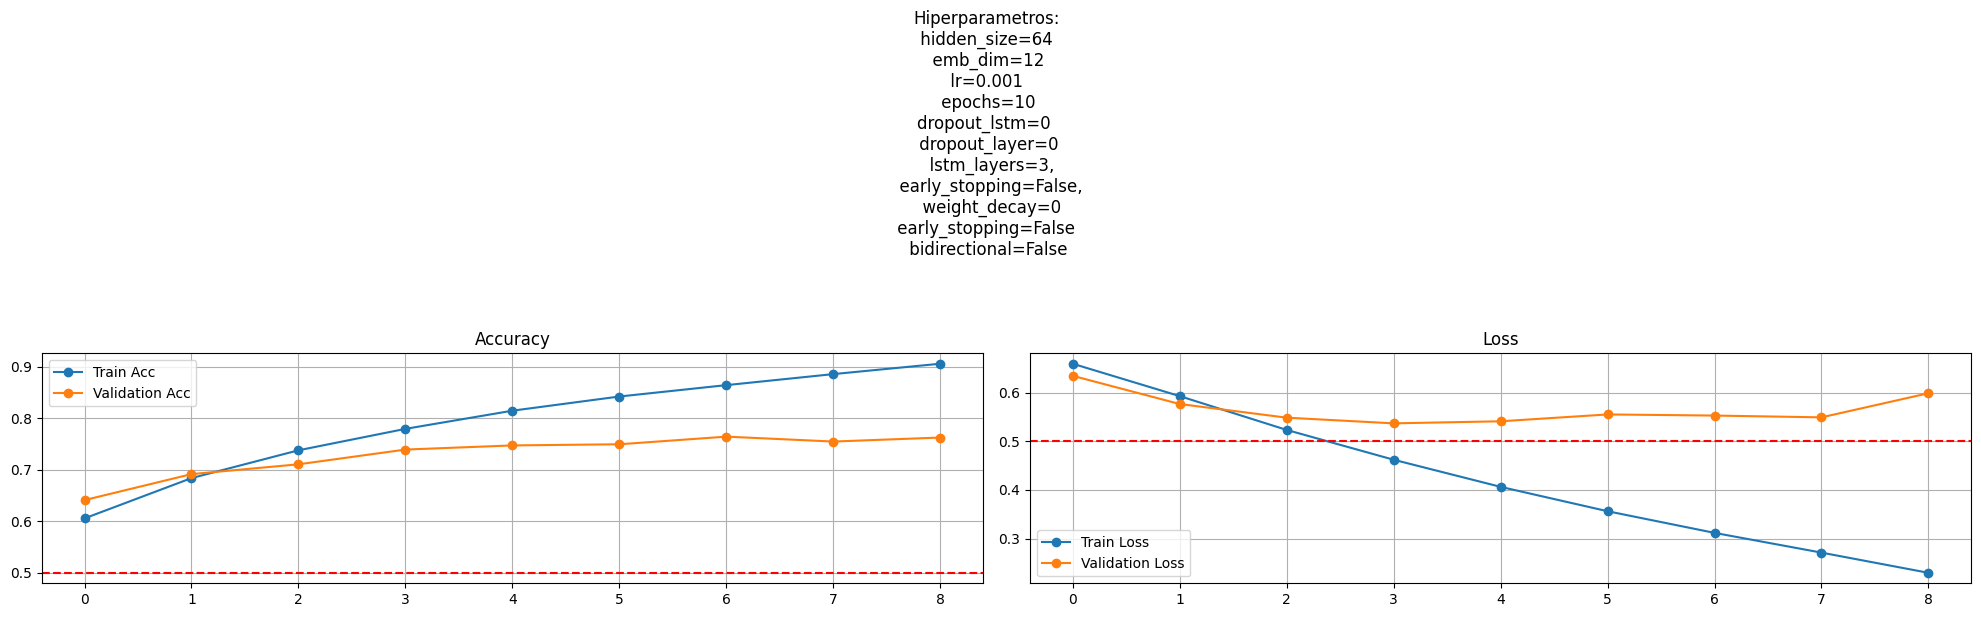

Processing model 6 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:08<00:00, 68.99it/s]


Validation loss decreased (inf --> 0.225623).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 75.11it/s]


Validation loss decreased (0.225623 --> 0.204354).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 74.21it/s]


Validation loss decreased (0.204354 --> 0.191731).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 79.96it/s]


Validation loss decreased (0.191731 --> 0.185242).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 72.73it/s]


100%|██████████| 581/581 [00:07<00:00, 75.66it/s]


Validation loss decreased (0.185242 --> 0.176507).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 66.46it/s]


100%|██████████| 581/581 [00:07<00:00, 74.79it/s]


100%|██████████| 581/581 [00:08<00:00, 72.13it/s]


100%|██████████| 581/581 [00:08<00:00, 70.57it/s]


[0.5973572541225761, 0.6789493473706827, 0.7365848418112478, 0.7785357468979964, 0.814148359026696, 0.8440672503625718, 0.868829564376645, 0.8882741580276092, 0.9069130364720417, 0.9234033410323897] [0.6259714214088744, 0.6680872399097518, 0.7051892704938582, 0.7149661569315618, 0.7325144146402607, 0.7488092253697669, 0.7518174981198296, 0.7518174981198296, 0.7540737026823765, 0.7513161193281525] [0.23596016667693495, 0.2063525197787047, 0.17596406245960017, 0.15244471538241267, 0.13284979605479824, 0.11550904175975134, 0.10005594772990414, 0.08740549802574972, 0.07477796736386526, 0.06404533551399966] [0.2256225049495697, 0.20435373064491055, 0.19173058050294076, 0.18524218476828067, 0.18586664580770076, 0.17650695649846906, 0.17918016737507236, 0.18441170042440777, 0.19119867685461236, 0.1932333304937328]
Processing model 7 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(2

100%|██████████| 581/581 [00:07<00:00, 73.28it/s]


Validation loss decreased (inf --> 0.537448).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 65.65it/s]


Validation loss decreased (0.537448 --> 0.482802).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 69.80it/s]


100%|██████████| 581/581 [00:08<00:00, 71.98it/s]


100%|██████████| 581/581 [00:08<00:00, 70.67it/s]


100%|██████████| 581/581 [00:08<00:00, 64.66it/s]


100%|██████████| 581/581 [00:08<00:00, 65.56it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.6469355964978246, 0.824783799752914, 0.8987484557125208, 0.9377987860557555, 0.9574582370951281, 0.9713702529945748, 0.9782456894236451] [0.738029581348709, 0.7721233391827526, 0.7756329907244923, 0.7761343695161694, 0.7733767861619454, 0.7746302331411381, 0.7718726497869141] [0.6255407536501728, 0.4060941883803645, 0.2603625752313925, 0.17636125735784663, 0.1289343490760626, 0.09258202732285796, 0.07378689815865737] [0.5374483720910165, 0.48280163565951006, 0.5124488034315647, 0.6270888351625011, 0.664284051185654, 0.6809330189660672, 0.7796358898762734]


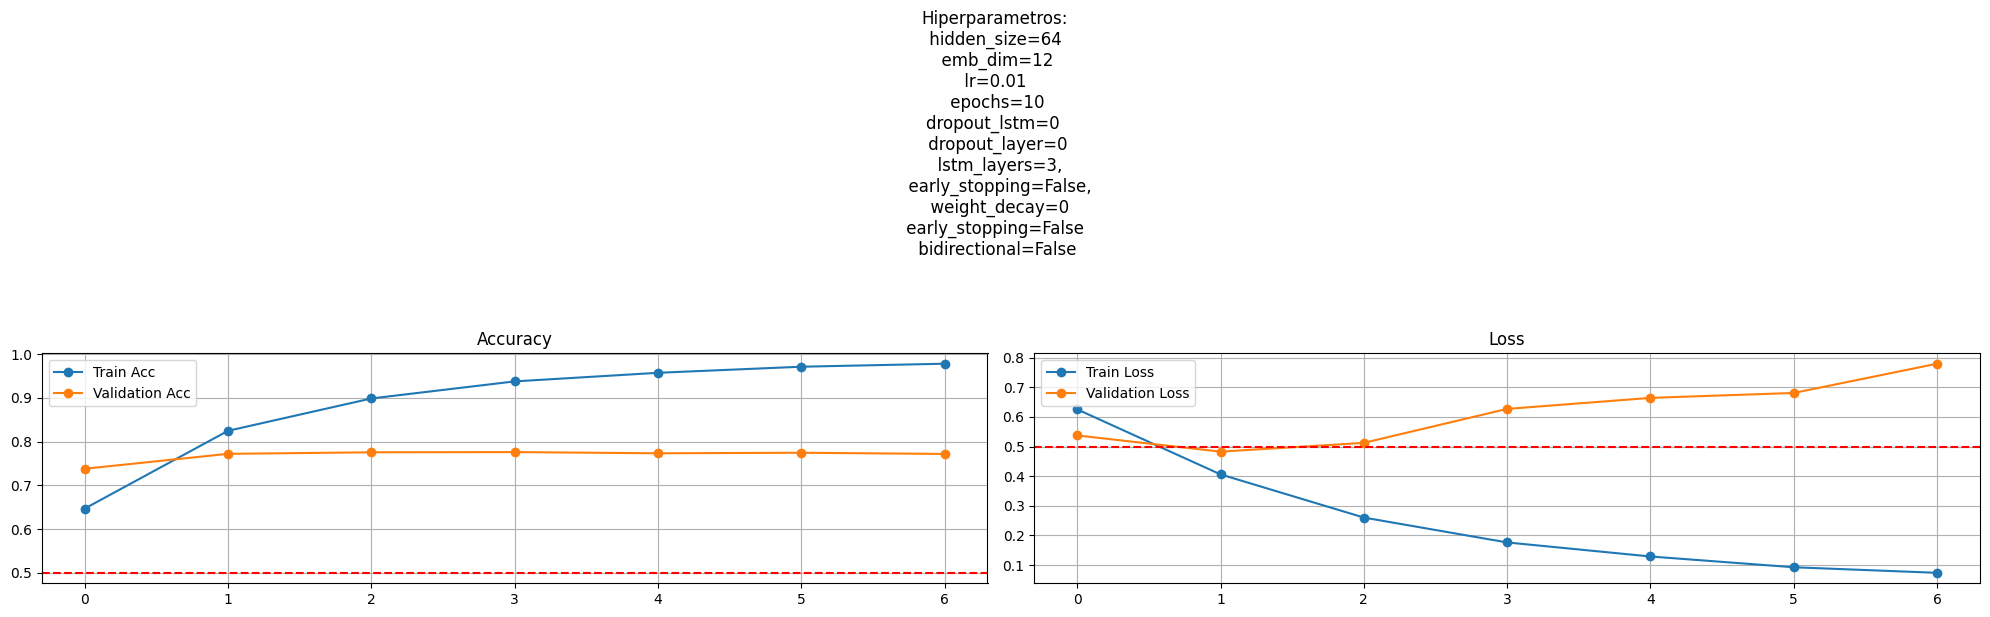

Processing model 8 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:07<00:00, 79.98it/s]


Validation loss decreased (inf --> 0.246237).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 75.96it/s]


Validation loss decreased (0.246237 --> 0.245957).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 79.76it/s]


100%|██████████| 581/581 [00:07<00:00, 78.67it/s]


Validation loss decreased (0.245957 --> 0.175515).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 78.67it/s]


Validation loss decreased (0.175515 --> 0.159420).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 76.34it/s]


100%|██████████| 581/581 [00:07<00:00, 72.77it/s]


100%|██████████| 581/581 [00:07<00:00, 80.58it/s]


100%|██████████| 581/581 [00:07<00:00, 74.01it/s]


100%|██████████| 581/581 [00:07<00:00, 77.59it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5620132137293872, 0.5612612128699576, 0.561476070258366, 0.6920556480635978, 0.8571198367083848, 0.9153461889670731, 0.9400547886340441, 0.9528388032443466, 0.9627759574582371, 0.9684159639039588] [0.5582852845324643, 0.5582852845324643, 0.5520180496365004, 0.7430433692654801, 0.7758836801203309, 0.7688643770368513, 0.7801453998495863, 0.7738781649536225, 0.7646026573075959, 0.7658561042867886] [0.2471886467502778, 0.24633152257144553, 0.24620279744139226, 0.1997140468244093, 0.10698037841413395, 0.06700794707756111, 0.04850770076510389, 0.03873810040016727, 0.03152607584194033, 0.02651820329229629] [0.24623667665066257, 0.24595719696052612, 0.24920669402326306, 0.17551501053235224, 0.15941969425447525, 0.18175807979799086, 0.1788907831294402, 0.18683233286344236, 0.19290067309573775, 0.19378394254994008]
Processing model 9 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bid

100%|██████████| 581/581 [00:27<00:00, 21.40it/s]


Validation loss decreased (inf --> 0.671461).  Saving model ...


100%|██████████| 581/581 [00:27<00:00, 20.87it/s]


Validation loss decreased (0.671461 --> 0.652117).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.69it/s]


Validation loss decreased (0.652117 --> 0.568063).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 19.30it/s]


Validation loss decreased (0.568063 --> 0.544870).  Saving model ...


100%|██████████| 581/581 [00:27<00:00, 21.51it/s]


Validation loss decreased (0.544870 --> 0.540760).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.87it/s]


100%|██████████| 581/581 [00:29<00:00, 20.00it/s]


100%|██████████| 581/581 [00:32<00:00, 18.07it/s]


100%|██████████| 581/581 [00:34<00:00, 16.61it/s]


100%|██████████| 581/581 [00:22<00:00, 25.37it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.6017618305849493, 0.6754042004619434, 0.7335768383735296, 0.775850029542891, 0.8088843530106892, 0.8377289574045228, 0.8629209861954128, 0.8849975828543805, 0.9069667508191438, 0.9239404845034108] [0.623965906242166, 0.6615693156179494, 0.7031837553271496, 0.726748558535974, 0.7352719979944848, 0.7460516420155427, 0.7543243920782151, 0.7620957633492104, 0.7585861118074706, 0.7676109300576586] [0.6663729299161192, 0.6087516917624285, 0.5377579917698432, 0.4763544602463865, 0.41896746203739343, 0.3671602788613708, 0.32262268173869013, 0.2747525318738926, 0.23407426809254078, 0.1961328243218016] [0.671460754688709, 0.6521167947400001, 0.5680629868180521, 0.5448699283503717, 0.5407596867411367, 0.5462077932973062, 0.5473376315447592, 0.6010825302331678, 0.655667008651841, 0.6825665074490732]
Processing model 10 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True

100%|██████████| 581/581 [00:20<00:00, 28.87it/s]


Validation loss decreased (inf --> 0.223423).  Saving model ...


100%|██████████| 581/581 [00:17<00:00, 32.52it/s]


Validation loss decreased (0.223423 --> 0.209830).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 29.33it/s]


Validation loss decreased (0.209830 --> 0.196810).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 29.70it/s]


Validation loss decreased (0.196810 --> 0.191268).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.09it/s]


Validation loss decreased (0.191268 --> 0.183064).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 26.81it/s]


100%|██████████| 581/581 [00:19<00:00, 29.58it/s]


100%|██████████| 581/581 [00:19<00:00, 29.28it/s]


100%|██████████| 581/581 [00:19<00:00, 30.24it/s]


100%|██████████| 581/581 [00:19<00:00, 29.60it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.6086372670140194, 0.6859859268410593, 0.7341139818445507, 0.7766020304023205, 0.8077026373744427, 0.8413815330074663, 0.8658752752860289, 0.8884353010689156, 0.9059461782242036, 0.920663909330182] [0.6390072699924794, 0.6688393080972674, 0.6984206568062171, 0.7074454750564051, 0.724993732765104, 0.7315116570569065, 0.7385309601403861, 0.7307595888693909, 0.7488092253697669, 0.7478064677864127] [0.2327500824366092, 0.20217950708792254, 0.17656669445117862, 0.15385652311697678, 0.13504023428063794, 0.11636292036436818, 0.10024642521473812, 0.08626792377835579, 0.07480117397642536, 0.06452478564435715] [0.22342296257134406, 0.20982965610681042, 0.19681043328056413, 0.19126841756364993, 0.18306445889174938, 0.1917785766023782, 0.1886211484670639, 0.19566481674630795, 0.19461741890277592, 0.20115703740908253]
Processing model 11 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bid

100%|██████████| 581/581 [00:18<00:00, 31.50it/s]


Validation loss decreased (inf --> 0.686094).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 30.16it/s]


Validation loss decreased (0.686094 --> 0.685719).  Saving model ...


100%|██████████| 581/581 [00:20<00:00, 28.56it/s]


Validation loss decreased (0.685719 --> 0.685628).  Saving model ...


100%|██████████| 581/581 [00:22<00:00, 26.19it/s]


100%|██████████| 581/581 [00:18<00:00, 31.03it/s]


100%|██████████| 581/581 [00:19<00:00, 30.29it/s]


100%|██████████| 581/581 [00:18<00:00, 30.75it/s]


100%|██████████| 581/581 [00:19<00:00, 30.00it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.560455497663426, 0.5610463554815491, 0.5613149272170597, 0.5613686415641618, 0.5611000698286512, 0.5612074985228555, 0.5613149272170597, 0.5611537841757533] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6865778229938316, 0.6856634208544602, 0.6857109895671707, 0.685620878936912, 0.6858651483120484, 0.6856099144521967, 0.6855957695826401, 0.6855544006762939] [0.6860943412588488, 0.6857188988116479, 0.6856280151874788, 0.6858424876005419, 0.6859826964716758, 0.6857123283609268, 0.6857212358905423, 0.6857955657666729]
Processing model 12 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 64, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=F

100%|██████████| 581/581 [00:19<00:00, 29.61it/s]


Validation loss decreased (inf --> 0.246368).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 30.20it/s]


Validation loss decreased (0.246368 --> 0.246272).  Saving model ...


100%|██████████| 581/581 [00:18<00:00, 31.08it/s]


100%|██████████| 581/581 [00:19<00:00, 30.42it/s]


Validation loss decreased (0.246272 --> 0.246261).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 29.70it/s]


Validation loss decreased (0.246261 --> 0.246251).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 29.06it/s]


100%|██████████| 581/581 [00:20<00:00, 28.93it/s]


100%|██████████| 581/581 [00:20<00:00, 28.60it/s]


100%|██████████| 581/581 [00:18<00:00, 31.35it/s]


100%|██████████| 581/581 [00:18<00:00, 30.93it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5608852124402428, 0.5612612128699576, 0.5613149272170597, 0.5614223559112639, 0.5614223559112639, 0.5613149272170597, 0.5612612128699576, 0.5612612128699576, 0.5613149272170597, 0.5612612128699576] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24705150449029756, 0.24641476728009276, 0.24642947526478726, 0.24631932683019753, 0.24638139137199946, 0.24631283387362238, 0.24629360968295144, 0.2464321863528168, 0.24640329966959568, 0.2463129853986832] [0.24636829704526933, 0.24627208601563208, 0.24640428106631002, 0.24626088094326756, 0.24625054218115344, 0.24641559273004532, 0.24678407345087297, 0.2470280673475035, 0.24626174004327867, 0.24666176471979387]
Processing model 13 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'b

100%|██████████| 581/581 [00:08<00:00, 69.86it/s]


Validation loss decreased (inf --> 0.637220).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 69.56it/s]


Validation loss decreased (0.637220 --> 0.598973).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 66.38it/s]


Validation loss decreased (0.598973 --> 0.560625).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 71.66it/s]


Validation loss decreased (0.560625 --> 0.545444).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 67.97it/s]


Validation loss decreased (0.545444 --> 0.540538).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 71.09it/s]


100%|██████████| 581/581 [00:09<00:00, 63.97it/s]


Validation loss decreased (0.540538 --> 0.523314).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 69.85it/s]


100%|██████████| 581/581 [00:08<00:00, 69.00it/s]


100%|██████████| 581/581 [00:09<00:00, 62.81it/s]


[0.602137831014664, 0.6757802008916581, 0.7341676961916528, 0.7741848847827255, 0.8074340656389322, 0.838803244346565, 0.8619004136004726, 0.8841381533007466, 0.9023473169683622, 0.9201804802062631] [0.6385058912008023, 0.6680872399097518, 0.706944096264728, 0.7219854600150414, 0.7427926798696415, 0.7445475056405114, 0.7575833542241163, 0.7623464527450489, 0.7580847330157934, 0.7603409375783404] [0.664614606129323, 0.6022889873144344, 0.5334049184740923, 0.4688969289887177, 0.4129958149949778, 0.363576618739742, 0.31785463591758645, 0.2759769254727946, 0.23954349044524453, 0.20198430493474007] [0.6372199491147073, 0.5989732574070653, 0.5606249582863623, 0.545444464010577, 0.5405381283452434, 0.5550700460951175, 0.5233138364649588, 0.5792760208489434, 0.5928881466388702, 0.5922027370862423]
Processing model 14 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm

100%|██████████| 581/581 [00:08<00:00, 70.41it/s]


Validation loss decreased (inf --> 0.231567).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 58.55it/s]


Validation loss decreased (0.231567 --> 0.211606).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 64.76it/s]


Validation loss decreased (0.211606 --> 0.193694).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 72.09it/s]


Validation loss decreased (0.193694 --> 0.191317).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 68.85it/s]


Validation loss decreased (0.191317 --> 0.184565).  Saving model ...


100%|██████████| 581/581 [00:07<00:00, 75.48it/s]


100%|██████████| 581/581 [00:09<00:00, 59.55it/s]


100%|██████████| 581/581 [00:09<00:00, 61.91it/s]


100%|██████████| 581/581 [00:09<00:00, 63.20it/s]


100%|██████████| 581/581 [00:09<00:00, 58.40it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5928989633131009, 0.6719664822474083, 0.7389482730837407, 0.7849277542031476, 0.8186066498361713, 0.8495461137669872, 0.873180426491916, 0.8929473062254928, 0.9095450394800452, 0.9229736262555729] [0.6151917773878165, 0.6638255201804963, 0.6901479067435448, 0.7107044372023064, 0.722737528202557, 0.7345199298069691, 0.7417899222862873, 0.7450488844321885, 0.7437954374529957, 0.742541990473803] [0.23901281245501646, 0.2082298528435103, 0.17560960685837496, 0.1502617633101657, 0.12965960998133005, 0.1121919490557273, 0.09724679314042482, 0.08431737017040357, 0.07269858454134501, 0.06384190262344196] [0.23156731251266696, 0.21160564006816956, 0.19369364878342998, 0.19131674587486253, 0.18456462974990567, 0.18781339365147776, 0.1917259262934808, 0.18846117194381454, 0.19403960624889982, 0.2025602534112911]
Processing model 15 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidire

100%|██████████| 581/581 [00:09<00:00, 60.94it/s]


Validation loss decreased (inf --> 0.687360).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 61.59it/s]


100%|██████████| 581/581 [00:09<00:00, 64.51it/s]


Validation loss decreased (0.687360 --> 0.686293).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 60.70it/s]


Validation loss decreased (0.686293 --> 0.685813).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 71.89it/s]


Validation loss decreased (0.685813 --> 0.685204).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 60.94it/s]


100%|██████████| 581/581 [00:09<00:00, 62.97it/s]


100%|██████████| 581/581 [00:09<00:00, 62.14it/s]


100%|██████████| 581/581 [00:10<00:00, 55.27it/s]


100%|██████████| 581/581 [00:10<00:00, 56.67it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5596497824568942, 0.5609389267873449, 0.5613149272170597, 0.5611000698286512, 0.5613149272170597, 0.5613149272170597, 0.5613686415641618, 0.5614223559112639, 0.5612612128699576, 0.5615297846054681] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6855570403618575, 0.6857588875929788, 0.6857626174485212, 0.6857740228639823, 0.6855903116027583, 0.6854577072721341, 0.6857075429619282, 0.6856216680572693, 0.6854316958461899, 0.6856332910655903] [0.6873604429344977, 0.6873777686588226, 0.6862932453232427, 0.6858127943931087, 0.6852038584409221, 0.6861652654986228, 0.6857715523050677, 0.6859898249949178, 0.6861058377450512, 0.6856630771390854]
Processing model 16 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': Fa

100%|██████████| 581/581 [00:08<00:00, 71.21it/s]


Validation loss decreased (inf --> 0.246270).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 67.55it/s]


Validation loss decreased (0.246270 --> 0.246259).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 68.92it/s]


Validation loss decreased (0.246259 --> 0.246252).  Saving model ...


100%|██████████| 581/581 [00:08<00:00, 69.78it/s]


100%|██████████| 581/581 [00:10<00:00, 55.87it/s]


Validation loss decreased (0.246252 --> 0.246250).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 55.35it/s]


100%|██████████| 581/581 [00:10<00:00, 54.30it/s]


100%|██████████| 581/581 [00:09<00:00, 63.74it/s]


100%|██████████| 581/581 [00:08<00:00, 68.10it/s]


100%|██████████| 581/581 [00:09<00:00, 61.63it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5608314980931407, 0.5612074985228555, 0.5600794972337111, 0.5613149272170597, 0.5612074985228555, 0.5614223559112639, 0.5612612128699576, 0.5615297846054681, 0.561476070258366, 0.5612612128699576] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24652194166347616, 0.24631447105214846, 0.24663659053086825, 0.2462910475808864, 0.2463023154234927, 0.2462815428713718, 0.24625672538493873, 0.24618898232093983, 0.24632861935846162, 0.24627086640737963] [0.24626983882438752, 0.2462591002545049, 0.24625176768149099, 0.24626349994251806, 0.24624968620557938, 0.2462949862162913, 0.24624999816859922, 0.2462761797491581, 0.24626573211243075, 0.24635507574965876]


In [ ]:
# Example params list
best_modelRNN_g1, modelsRNN_g1 = eval_models(params_models_g1, SarcasmRNN, training_model, training_params, print_plots='best_model')

In [ ]:
[best_modelRNN_g1['params'], best_modelRNN_g1['best_epoch_vl_acc']]

[{'vocab_size': 21387,
  'output_size': 1,
  'embedding_dim': 12,
  'hidden_dim': 64,
  'n_layers': 3,
  'bidirectional': False,
  'lr': 0.01,
  'criterion': BCELoss()},
 [0.738029581348709,
  0.7721233391827526,
  0.7756329907244923,
  0.7761343695161694,
  0.7733767861619454,
  0.7746302331411381,
  0.7718726497869141]]

Este es el mejor modelo encontrado a partir de la primer busqueda de hiperparámetros utilizando la funcion que confeccionamos. En relación al modelo RNN base, este presenta 64 hidden_dim en vez de 128 y la dirrecionalidad es unidireccional (directional = False), es decir que los datos se preocesan en una sola dirección. La tasa de aprendizaje lr también cambia y pasa de 0.001 a 0.01 (el modelo aprende mas rapido). Vemos que el accuracy en validation alcanza un 0.77. Este valor es mayor al encontrado por los modelos anteriores, sin embargo, el sobreajuste sigue estando presente. Esto último también lo podemos observar en el gráfico de loss, donde vemos que esta aumenta en el set de validación, mientras disminuye en entrenamiento. Importante mencionar que este modelo se detiene en la época 6 a partir de la cual las métricas no mejoran.

Total models to evaluate: 16
Processing model 1 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


  0%|          | 0/581 [00:00<?, ?it/s]

100%|██████████| 581/581 [00:21<00:00, 27.00it/s]


Validation loss decreased (inf --> 0.661668).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.33it/s]


Validation loss decreased (0.661668 --> 0.612700).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 26.82it/s]


Validation loss decreased (0.612700 --> 0.585355).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 26.44it/s]


Validation loss decreased (0.585355 --> 0.568886).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.09it/s]


Validation loss decreased (0.568886 --> 0.550574).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.12it/s]


100%|██████████| 581/581 [00:22<00:00, 25.80it/s]


100%|██████████| 581/581 [00:21<00:00, 27.18it/s]


100%|██████████| 581/581 [00:20<00:00, 27.71it/s]


100%|██████████| 581/581 [00:21<00:00, 27.54it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5906429607348123, 0.663587044099479, 0.7254122576140087, 0.7700488800558629, 0.8037277756888865, 0.8338615244131707, 0.8599129827576946, 0.8864478702261374, 0.9100284686039641, 0.9319976365687275] [0.6014038606166959, 0.6613186262221108, 0.6959137628478316, 0.7081975432439208, 0.7217347706192028, 0.7275006267234896, 0.7277513161193282, 0.7335171722236149, 0.7325144146402607, 0.7317623464527451] [0.6710513635264411, 0.6111991629132716, 0.5428522471306452, 0.4788618958499058, 0.4235225377312626, 0.37277075144335653, 0.32379624870783696, 0.27410994502178776, 0.22627591391746435, 0.17890106454465968] [0.6616682833240878, 0.6127001962834789, 0.5853551515648442, 0.5688863586514227, 0.5505738801533177, 0.5534500023049693, 0.6132485044579352, 0.5947972199609203, 0.6803485433901509, 0.7614801857740648]


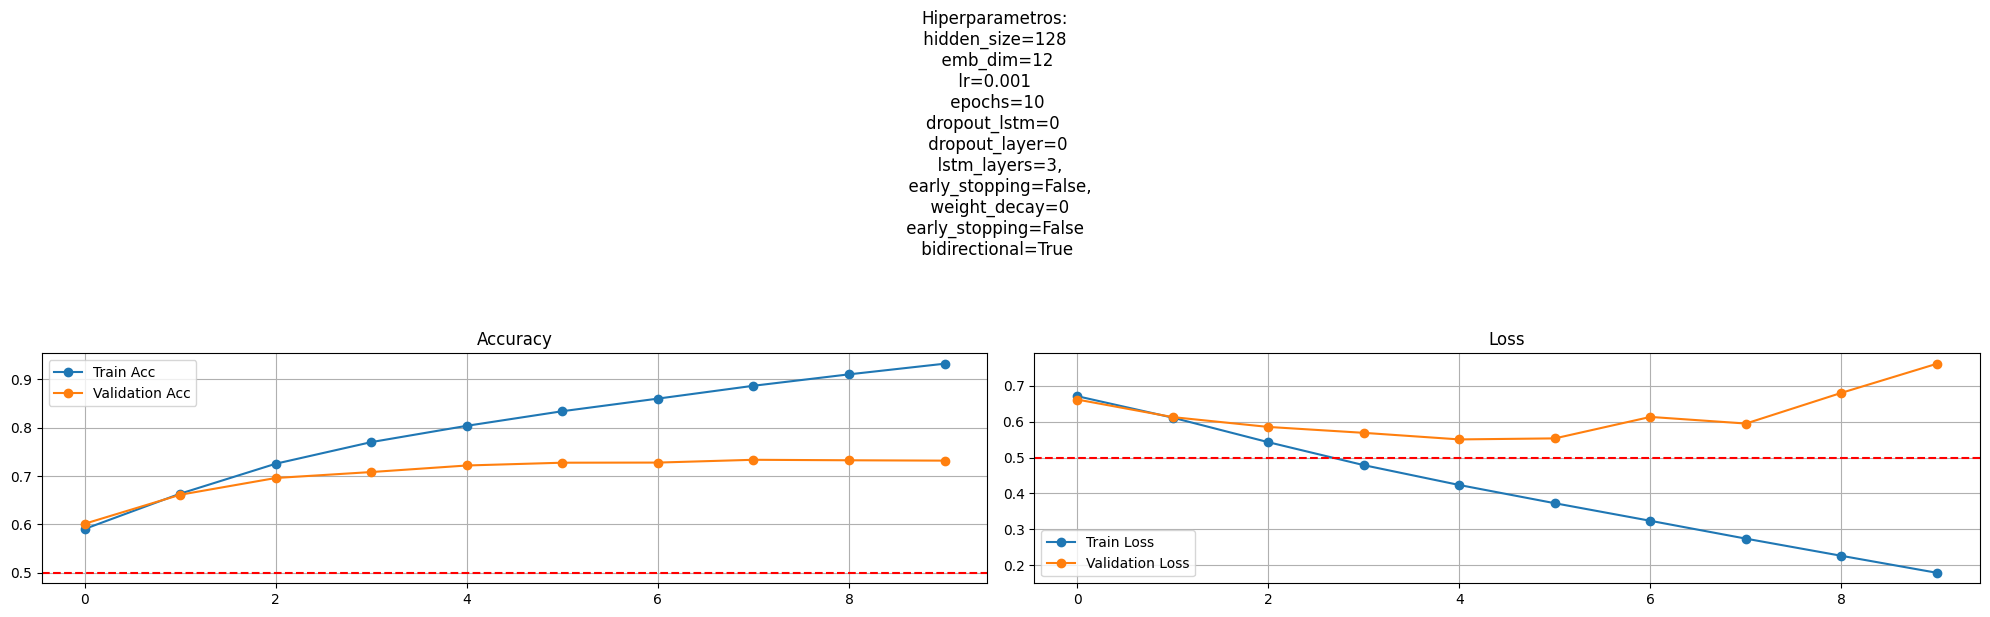

Processing model 2 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:21<00:00, 26.75it/s]


Validation loss decreased (inf --> 0.224106).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.42it/s]


Validation loss decreased (0.224106 --> 0.204310).  Saving model ...


100%|██████████| 581/581 [00:20<00:00, 28.24it/s]


Validation loss decreased (0.204310 --> 0.196769).  Saving model ...


100%|██████████| 581/581 [00:20<00:00, 27.87it/s]


Validation loss decreased (0.196769 --> 0.189823).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 26.79it/s]


Validation loss decreased (0.189823 --> 0.186197).  Saving model ...


100%|██████████| 581/581 [00:21<00:00, 27.26it/s]


100%|██████████| 581/581 [00:21<00:00, 27.29it/s]


100%|██████████| 581/581 [00:21<00:00, 27.23it/s]


100%|██████████| 581/581 [00:21<00:00, 27.06it/s]


100%|██████████| 581/581 [00:20<00:00, 27.84it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5995595423537627, 0.6788956330235806, 0.7332545522909169, 0.7717140248160284, 0.8104420690766504, 0.8411666756190579, 0.8651769887737014, 0.886286727184831, 0.9047644625879573, 0.9193747649997315] [0.6302331411381299, 0.6838806718475808, 0.7016796189521183, 0.72048132364001, 0.7290047630985209, 0.7350213085986462, 0.7362747555778391, 0.740787164702933, 0.735773376786162, 0.740787164702933] [0.2349139340670712, 0.20643581267888697, 0.1803341224763972, 0.15781032384442176, 0.13754836633391102, 0.11938738743750549, 0.10398611856909812, 0.08922695806137769, 0.07626111113038331, 0.06531203228246145] [0.22410636935983935, 0.20431012960691605, 0.19676929652210204, 0.18982340743945492, 0.18619661543878815, 0.19404395128930768, 0.18733215073664342, 0.19102115057889493, 0.20375914721479338, 0.20948229273480753]


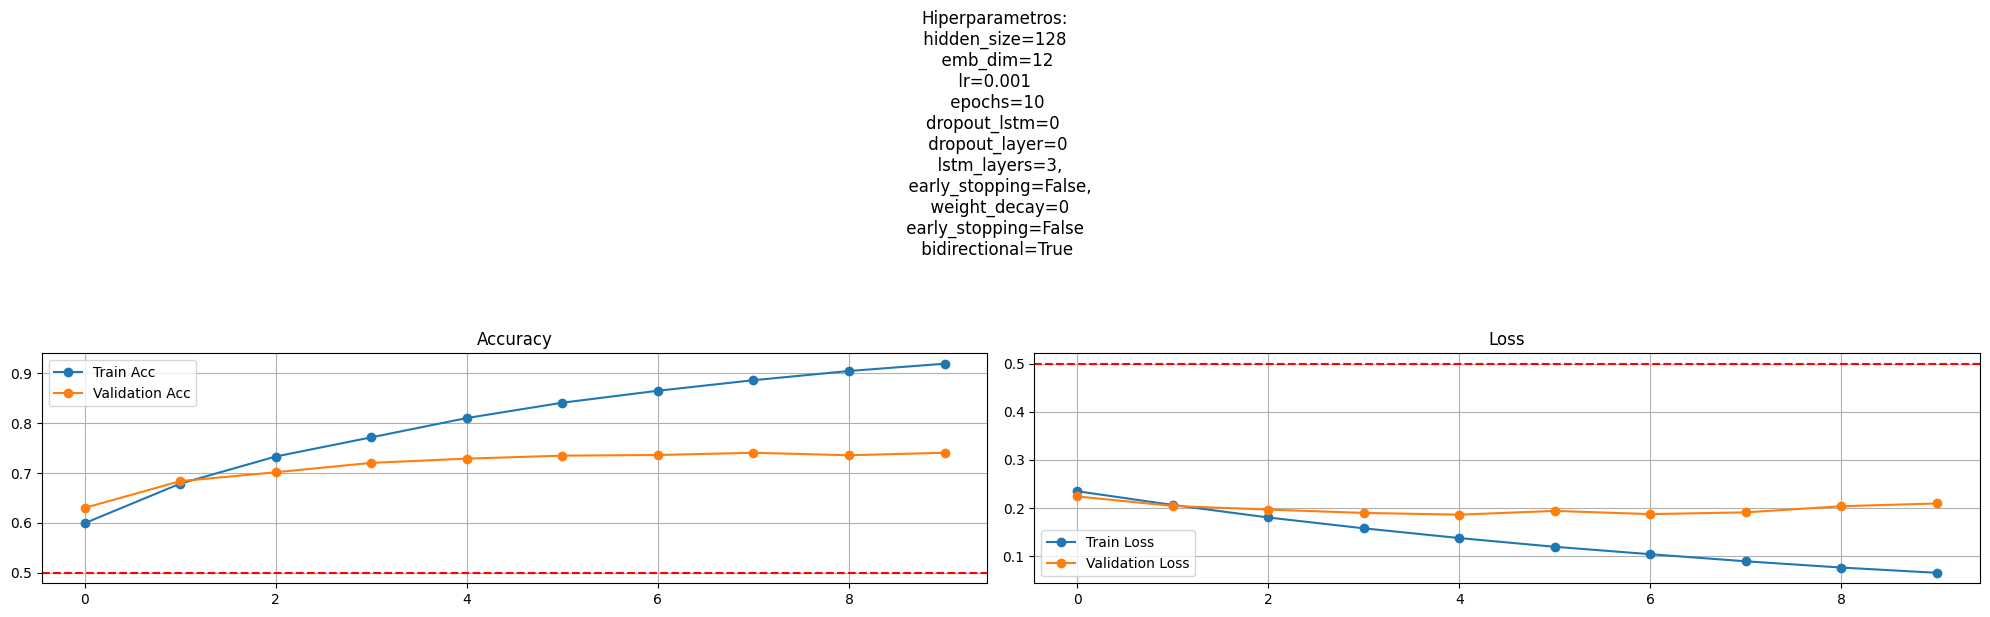

Processing model 3 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:24<00:00, 24.00it/s]


Validation loss decreased (inf --> 0.742208).  Saving model ...


100%|██████████| 581/581 [00:26<00:00, 21.60it/s]


Validation loss decreased (0.742208 --> 0.698322).  Saving model ...


100%|██████████| 581/581 [00:26<00:00, 21.72it/s]


Validation loss decreased (0.698322 --> 0.690893).  Saving model ...


100%|██████████| 581/581 [00:26<00:00, 21.92it/s]


Validation loss decreased (0.690893 --> 0.687889).  Saving model ...


100%|██████████| 581/581 [00:26<00:00, 21.59it/s]


100%|██████████| 581/581 [00:28<00:00, 20.17it/s]


100%|██████████| 581/581 [00:28<00:00, 20.38it/s]


100%|██████████| 581/581 [00:26<00:00, 22.23it/s]


100%|██████████| 581/581 [00:25<00:00, 22.68it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5241445990223988, 0.5235537412042757, 0.5189343073534941, 0.5315571789224902, 0.5334371810710641, 0.5240908846752967, 0.5309663211043669, 0.5296234624268142, 0.5331686093355535] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606] [0.7113689844866833, 0.7140586088938885, 0.7202075930142362, 0.70537643834769, 0.7080635991646378, 0.7074049871267427, 0.7142993489764439, 0.7080559633069523, 0.7048223973756813] [0.7422075622504757, 0.6983224562098903, 0.690892705513585, 0.6878888789684542, 0.7172441674816993, 0.6915389140767436, 0.6931220768920837, 0.6899949451608043, 0.7672295882817237]
Processing model 4 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_la

100%|██████████| 581/581 [00:19<00:00, 29.66it/s]


Validation loss decreased (inf --> 0.246943).  Saving model ...


100%|██████████| 581/581 [00:20<00:00, 28.48it/s]


100%|██████████| 581/581 [00:23<00:00, 25.02it/s]


Validation loss decreased (0.246943 --> 0.246770).  Saving model ...


100%|██████████| 581/581 [00:20<00:00, 28.44it/s]


Validation loss decreased (0.246770 --> 0.246762).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 29.63it/s]


Validation loss decreased (0.246762 --> 0.246273).  Saving model ...


100%|██████████| 581/581 [00:19<00:00, 30.00it/s]


Validation loss decreased (0.246273 --> 0.246255).  Saving model ...


100%|██████████| 581/581 [00:38<00:00, 14.97it/s]


100%|██████████| 581/581 [00:40<00:00, 14.19it/s]


100%|██████████| 581/581 [00:40<00:00, 14.19it/s]


100%|██████████| 581/581 [00:39<00:00, 14.54it/s]


[0.5571789224901972, 0.5613149272170597, 0.5612074985228555, 0.5613149272170597, 0.5613149272170597, 0.5613149272170597, 0.5572326368372993, 0.5600794972337111, 0.557608637267014, 0.5594886394155879] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.2477088671389217, 0.24681352266140935, 0.24653301007160836, 0.24661442883658943, 0.24676695450653102, 0.24675448828740704, 0.24741023989224392, 0.24712177110826292, 0.24667137589388993, 0.24693883742604936] [0.24694337467512778, 0.24710688463622524, 0.24677024829772212, 0.2467615269124508, 0.24627329469207795, 0.24625473433444578, 0.2462840634247949, 0.2466867966276984, 0.24690172520856704, 0.24684816166277854]
Processing model 5 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(

100%|██████████| 581/581 [00:09<00:00, 60.06it/s]


Validation loss decreased (inf --> 0.685551).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 60.21it/s]


Validation loss decreased (0.685551 --> 0.683340).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 62.29it/s]


Validation loss decreased (0.683340 --> 0.602178).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 57.72it/s]


Validation loss decreased (0.602178 --> 0.562488).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 55.34it/s]


Validation loss decreased (0.562488 --> 0.547227).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 61.99it/s]


Validation loss decreased (0.547227 --> 0.532521).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 61.09it/s]


100%|██████████| 581/581 [00:09<00:00, 62.25it/s]


100%|██████████| 581/581 [00:09<00:00, 61.06it/s]


100%|██████████| 581/581 [00:09<00:00, 62.97it/s]


[0.5649675028200032, 0.5623354998119998, 0.643712735671698, 0.7286351184401354, 0.7752054573776656, 0.8094214964817102, 0.8422946769082021, 0.8685609926411344, 0.8903690175645915, 0.9127679003061718] [0.5582852845324643, 0.5590373527199799, 0.6685886187014289, 0.7041865129105039, 0.7269992479318125, 0.7367761343695162, 0.7430433692654801, 0.7460516420155427, 0.747054399598897, 0.7545750814740536] [0.6840310193175088, 0.6849415249955839, 0.6301765667591981, 0.5417796592909375, 0.4708578528102212, 0.41243090343352234, 0.3585270799940096, 0.3094724730016237, 0.2650592402264912, 0.21793100475085173] [0.6855506834483915, 0.6833398539212442, 0.6021782731817614, 0.5624881701604012, 0.5472268459777678, 0.5325207765544614, 0.5386852225469004, 0.560262723555488, 0.581317047077802, 0.6162895351167648]


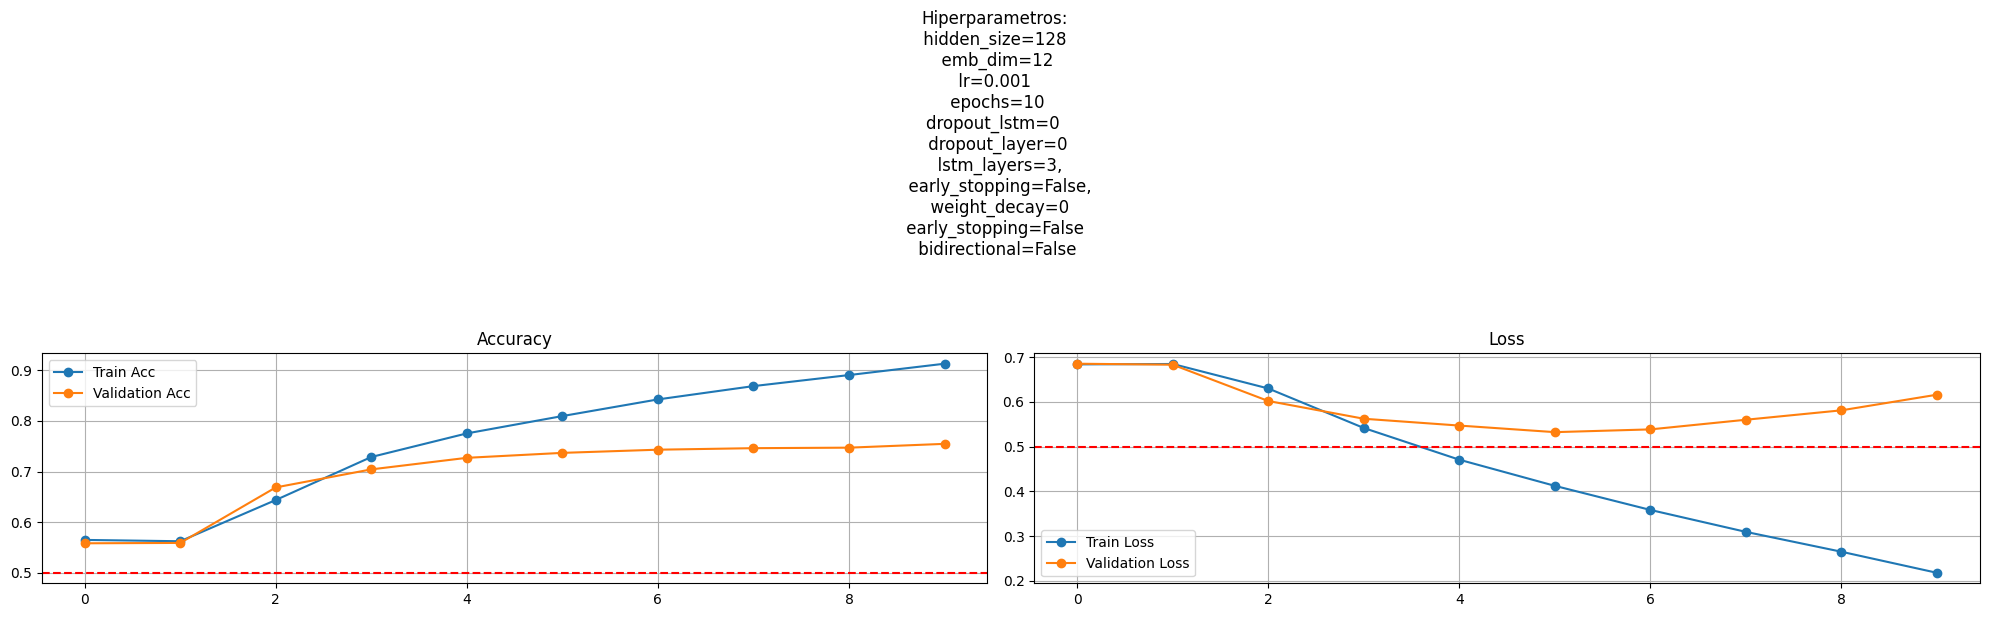

Processing model 6 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:10<00:00, 56.88it/s]


Validation loss decreased (inf --> 0.227209).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 53.93it/s]


Validation loss decreased (0.227209 --> 0.204601).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 50.22it/s]


Validation loss decreased (0.204601 --> 0.191702).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 50.16it/s]


Validation loss decreased (0.191702 --> 0.186508).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 61.96it/s]


Validation loss decreased (0.186508 --> 0.182089).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 59.84it/s]


Validation loss decreased (0.182089 --> 0.180993).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 62.00it/s]


100%|██████████| 581/581 [00:09<00:00, 60.53it/s]


100%|██████████| 581/581 [00:09<00:00, 58.83it/s]


100%|██████████| 581/581 [00:09<00:00, 64.49it/s]


[0.6031584036096042, 0.6823870655852178, 0.7394854165547617, 0.7798248912284471, 0.8158672181339636, 0.8443895364451846, 0.8707095665252189, 0.8924638771015738, 0.9116936133641296, 0.9280227748831713] [0.622211080471296, 0.6788668839308097, 0.7076961644522437, 0.7172223614941088, 0.7275006267234896, 0.7420406116821259, 0.7400350965154174, 0.7458009526197041, 0.7505640511406367, 0.7540737026823765] [0.235332007739507, 0.205090910529721, 0.17586291898138143, 0.15293088851563902, 0.13252946769052446, 0.11464709679559258, 0.0978483574788716, 0.08381145130386079, 0.0713283103576536, 0.05968277477547077] [0.2272086894560245, 0.20460114387735243, 0.19170164635344858, 0.18650847246810312, 0.18208921292135793, 0.18099313932320765, 0.18412057935230194, 0.1878939341873892, 0.1917261763686134, 0.19654984063198488]
Processing model 7 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387

100%|██████████| 581/581 [00:09<00:00, 60.37it/s]


Validation loss decreased (inf --> 0.685895).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 58.18it/s]


Validation loss decreased (0.685895 --> 0.685630).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 64.06it/s]


Validation loss decreased (0.685630 --> 0.685629).  Saving model ...


100%|██████████| 581/581 [00:09<00:00, 59.86it/s]


100%|██████████| 581/581 [00:09<00:00, 60.58it/s]


100%|██████████| 581/581 [00:09<00:00, 63.54it/s]


100%|██████████| 581/581 [00:09<00:00, 60.85it/s]


100%|██████████| 581/581 [00:11<00:00, 51.89it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5586292098619541, 0.5612612128699576, 0.5613686415641618, 0.5611537841757533, 0.561476070258366, 0.5613686415641618, 0.5612074985228555, 0.5612074985228555] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6871204206947615, 0.6856821564101516, 0.6856591660471668, 0.6857773928346814, 0.6854886129472835, 0.6857634388846497, 0.6858603043318205, 0.6857442582946226] [0.6858949815073321, 0.6856299191713333, 0.6856289030082764, 0.6856945921336451, 0.6861666883191755, 0.6857695791029161, 0.6858485691970394, 0.6861554744743532]
Processing model 8 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear):

100%|██████████| 581/581 [00:09<00:00, 64.31it/s]


Validation loss decreased (inf --> 0.246277).  Saving model ...


100%|██████████| 581/581 [00:10<00:00, 56.61it/s]


100%|██████████| 581/581 [00:09<00:00, 62.07it/s]


100%|██████████| 581/581 [00:09<00:00, 63.15it/s]


100%|██████████| 581/581 [00:09<00:00, 61.34it/s]


100%|██████████| 581/581 [00:09<00:00, 62.22it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.560025782886609, 0.5610463554815491, 0.5611000698286512, 0.5611537841757533, 0.5612074985228555, 0.5613149272170597] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24687264454446847, 0.24652727168829225, 0.2465531936046794, 0.24661208543022406, 0.24661563811326806, 0.2467588042638388] [0.24627682494540368, 0.2471852955077925, 0.24679880973792845, 0.24712754701895098, 0.24670061541180457, 0.24630663039222842]
Processing model 9 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:28<00:00, 20.14it/s]


Validation loss decreased (inf --> 0.632953).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 18.88it/s]


Validation loss decreased (0.632953 --> 0.600078).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 19.35it/s]


Validation loss decreased (0.600078 --> 0.561972).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.73it/s]


Validation loss decreased (0.561972 --> 0.548961).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.98it/s]


100%|██████████| 581/581 [00:30<00:00, 19.18it/s]


Validation loss decreased (0.548961 --> 0.539804).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.64it/s]


100%|██████████| 581/581 [00:30<00:00, 19.17it/s]


100%|██████████| 581/581 [00:31<00:00, 18.20it/s]


100%|██████████| 581/581 [00:30<00:00, 18.96it/s]


[0.6078852661545899, 0.67379277004888, 0.7250362571842939, 0.7666648761884299, 0.8031369178707632, 0.8299940914218188, 0.8562066928076489, 0.8816135789869474, 0.9024547456625664, 0.9221141967019391] [0.6367510654299323, 0.6648282777638506, 0.7034344447229882, 0.7199799448483329, 0.731260967661068, 0.7350213085986462, 0.7440461268488343, 0.7485585359739283, 0.7498119829531211, 0.7550764602657307] [0.6623906097190515, 0.6039343515279576, 0.5428130328655243, 0.4832749156707741, 0.4285296051668423, 0.3806657339999269, 0.33356446545833973, 0.2863737978105291, 0.24454100596720094, 0.20314276069017984] [0.6329532506004456, 0.6000778677482759, 0.5619717627283065, 0.5489614752511824, 0.5629020174664836, 0.5398038863655059, 0.5689665504520939, 0.5990125159582784, 0.631688225894205, 0.6489365797850394]


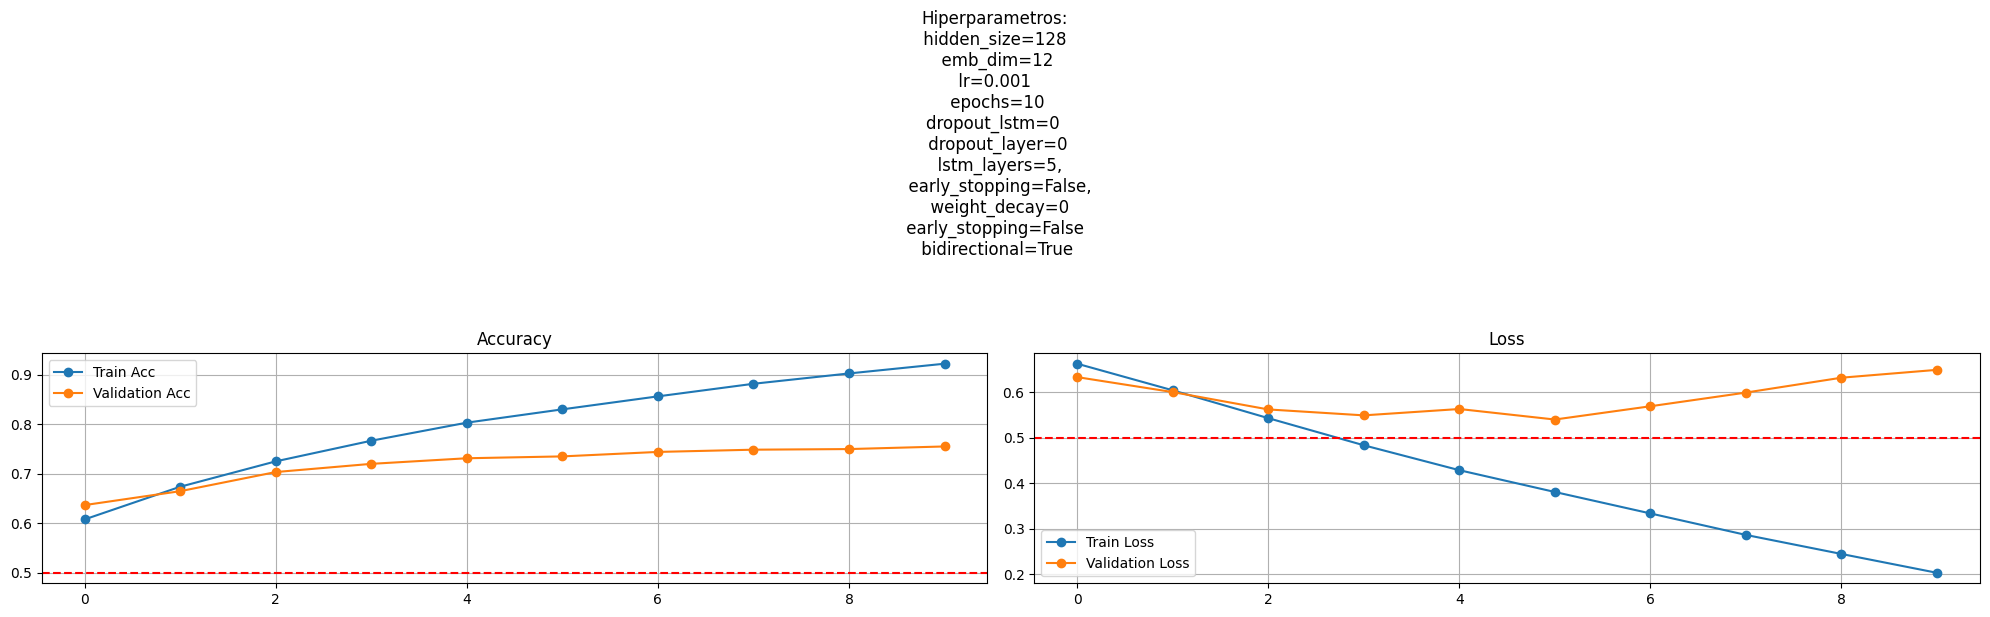

Processing model 10 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:31<00:00, 18.50it/s]


Validation loss decreased (inf --> 0.227030).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 19.18it/s]


Validation loss decreased (0.227030 --> 0.210968).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 18.94it/s]


Validation loss decreased (0.210968 --> 0.197593).  Saving model ...


100%|██████████| 581/581 [00:28<00:00, 20.17it/s]


Validation loss decreased (0.197593 --> 0.186437).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.61it/s]


Validation loss decreased (0.186437 --> 0.181569).  Saving model ...


100%|██████████| 581/581 [00:28<00:00, 20.26it/s]


Validation loss decreased (0.181569 --> 0.178839).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 19.36it/s]


Validation loss decreased (0.178839 --> 0.177255).  Saving model ...


100%|██████████| 581/581 [00:31<00:00, 18.19it/s]


100%|██████████| 581/581 [00:27<00:00, 21.13it/s]


100%|██████████| 581/581 [00:28<00:00, 20.24it/s]


[0.5887629585862384, 0.6598270398023312, 0.7141859590696675, 0.7558682924209056, 0.7938980501692002, 0.8232797980340549, 0.8512649728742547, 0.8752215716817963, 0.8962238813987216, 0.9174410485040554] [0.6277262471797443, 0.6638255201804963, 0.6954123840561545, 0.7149661569315618, 0.7287540737026824, 0.7415392328904488, 0.7488092253697669, 0.7555778390574078, 0.7563299072449235, 0.7478064677864127] [0.23793313884386302, 0.2131246186267078, 0.1884634558258902, 0.16460584431065955, 0.14271520383386727, 0.12516375867050403, 0.10844290406858346, 0.09362797154732395, 0.07969753003379461, 0.06652656873418002] [0.22703010612918484, 0.21096794547573214, 0.19759278894672472, 0.18643693157261418, 0.18156934793918364, 0.17883870173846522, 0.17725547285930765, 0.18199586408633378, 0.1867530082142161, 0.1920447075559247]
Processing model 11 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding

100%|██████████| 581/581 [00:30<00:00, 19.30it/s]


Validation loss decreased (inf --> 0.685716).  Saving model ...


100%|██████████| 581/581 [00:31<00:00, 18.51it/s]


Validation loss decreased (0.685716 --> 0.685661).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.61it/s]


100%|██████████| 581/581 [00:31<00:00, 18.64it/s]


100%|██████████| 581/581 [00:32<00:00, 18.12it/s]


Validation loss decreased (0.685661 --> 0.685653).  Saving model ...


100%|██████████| 581/581 [00:30<00:00, 18.83it/s]


100%|██████████| 581/581 [00:32<00:00, 17.70it/s]


100%|██████████| 581/581 [00:32<00:00, 18.07it/s]


100%|██████████| 581/581 [00:31<00:00, 18.42it/s]


Validation loss decreased (0.685653 --> 0.685653).  Saving model ...


100%|██████████| 581/581 [00:31<00:00, 18.45it/s]


[0.559058924638771, 0.5613149272170597, 0.5612612128699576, 0.5609389267873449, 0.5611537841757533, 0.5611000698286512, 0.5612612128699576, 0.5612612128699576, 0.5612612128699576, 0.5611537841757533] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6875936049397349, 0.6867504718997187, 0.6861275905380971, 0.6862393557102052, 0.6862642331090524, 0.6860536741102419, 0.6864658767508147, 0.6859227709228529, 0.6867643223366926, 0.6861987615616515] [0.6857156710278604, 0.6856606093145186, 0.685968199083882, 0.6865785088269941, 0.6856534721389893, 0.6877800101234067, 0.6860771059028564, 0.6903300054611698, 0.6856527501536954, 0.6864855385595753]
Processing model 12 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lst

100%|██████████| 581/581 [00:27<00:00, 21.04it/s]


Validation loss decreased (inf --> 0.246636).  Saving model ...


100%|██████████| 581/581 [00:29<00:00, 19.74it/s]


Validation loss decreased (0.246636 --> 0.246287).  Saving model ...


100%|██████████| 581/581 [00:42<00:00, 13.65it/s]


100%|██████████| 581/581 [00:46<00:00, 12.47it/s]


Validation loss decreased (0.246287 --> 0.246250).  Saving model ...


100%|██████████| 581/581 [00:47<00:00, 12.20it/s]


100%|██████████| 581/581 [01:15<00:00,  7.67it/s]


100%|██████████| 581/581 [01:17<00:00,  7.51it/s]


100%|██████████| 581/581 [01:17<00:00,  7.45it/s]


100%|██████████| 581/581 [01:18<00:00,  7.39it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5601332115808132, 0.5614223559112639, 0.5612612128699576, 0.560992641134447, 0.5613686415641618, 0.5613149272170597, 0.5610463554815491, 0.5612612128699576, 0.5612612128699576] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24688195964247758, 0.24659005918006274, 0.24665125614599598, 0.2465980980872287, 0.2464816208396639, 0.24654972032610192, 0.2465018247111529, 0.24660776814577295, 0.24660892002348644] [0.24663646507167047, 0.2462873226932941, 0.2475205059013059, 0.24624960472987545, 0.24629805825891032, 0.24625709977361462, 0.24788085972109147, 0.24642510531890777, 0.2462684532567378]
Processing model 13 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(

100%|██████████| 581/581 [00:12<00:00, 47.35it/s]


Validation loss decreased (inf --> 0.643830).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 45.14it/s]


Validation loss decreased (0.643830 --> 0.608504).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 44.95it/s]


Validation loss decreased (0.608504 --> 0.578268).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 48.08it/s]


Validation loss decreased (0.578268 --> 0.563962).  Saving model ...


100%|██████████| 581/581 [00:11<00:00, 49.27it/s]


Validation loss decreased (0.563962 --> 0.546599).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 46.04it/s]


100%|██████████| 581/581 [00:12<00:00, 46.21it/s]


100%|██████████| 581/581 [00:12<00:00, 45.03it/s]


100%|██████████| 581/581 [00:15<00:00, 37.39it/s]


100%|██████████| 581/581 [00:13<00:00, 41.51it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.59440296503196, 0.6726110544126336, 0.7319654079604663, 0.7784820325508943, 0.8144169307622066, 0.8447655368748993, 0.8674867056990923, 0.8903690175645915, 0.9132513294300908, 0.928345060965784] [0.623965906242166, 0.6695913762847832, 0.7006768613687641, 0.7207320130358486, 0.7305088994735522, 0.7455502632238656, 0.7463023314113812, 0.7568312860366007, 0.7550764602657307, 0.7568312860366007] [0.6684536155755672, 0.6041305457047874, 0.5358334443757948, 0.47116749463105984, 0.4150974683578987, 0.36492307704717897, 0.3193430094090058, 0.27301959494664213, 0.2301504913775215, 0.19057054802288081] [0.6438302445796228, 0.608503715405541, 0.5782682100130666, 0.5639618531830849, 0.5465988254835529, 0.5647130761175386, 0.5471672043204308, 0.5710949668240163, 0.6454443644371725, 0.6592852845788002]


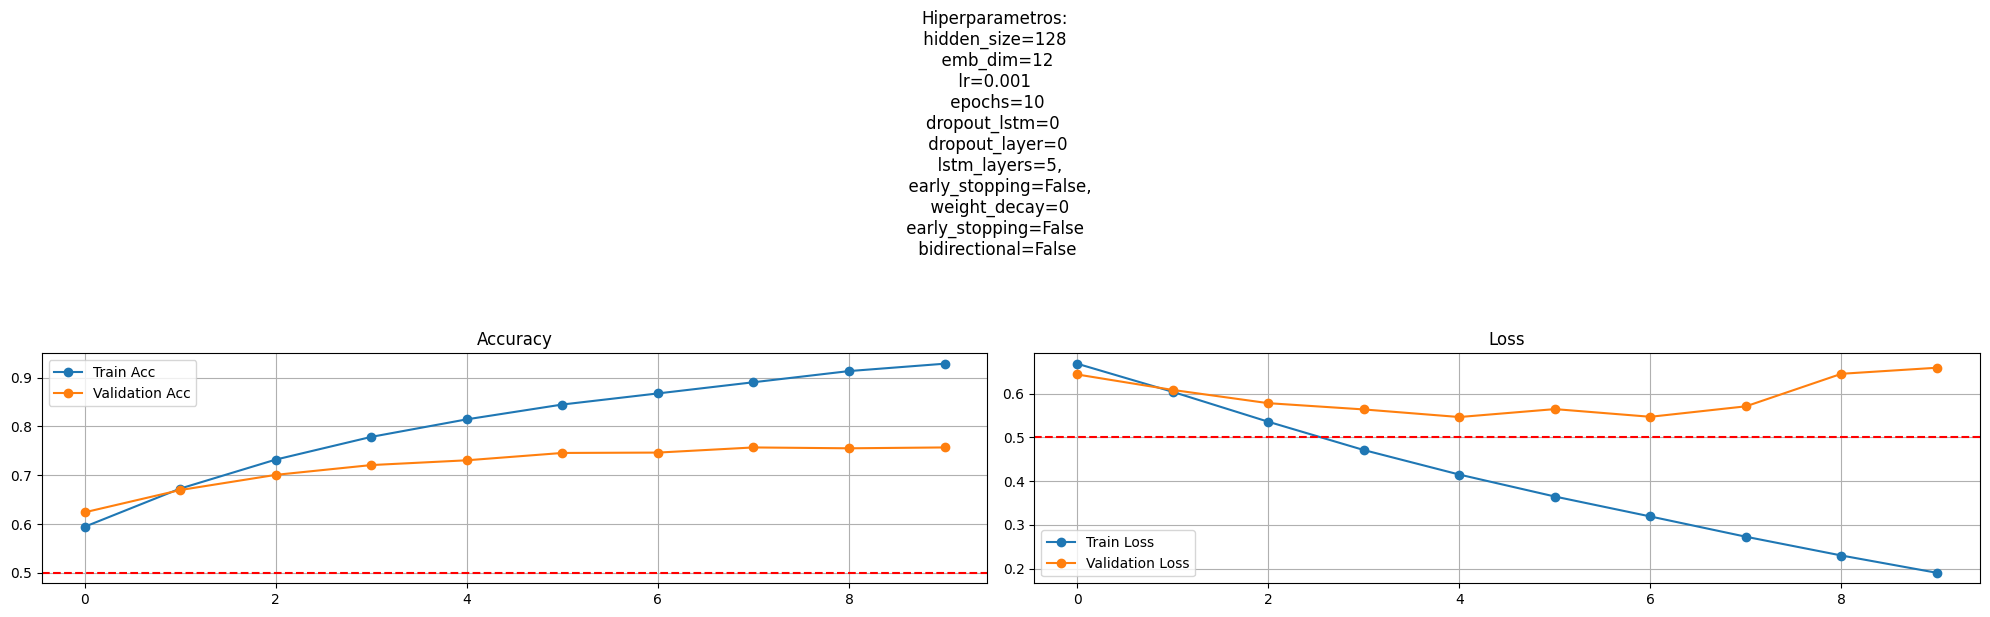

Processing model 14 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 581/581 [00:12<00:00, 45.47it/s]


Validation loss decreased (inf --> 0.236855).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 45.96it/s]


Validation loss decreased (0.236855 --> 0.213307).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 47.68it/s]


Validation loss decreased (0.213307 --> 0.196895).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 47.36it/s]


Validation loss decreased (0.196895 --> 0.191787).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 46.97it/s]


Validation loss decreased (0.191787 --> 0.190413).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 45.90it/s]


Validation loss decreased (0.190413 --> 0.181001).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 46.22it/s]


100%|██████████| 581/581 [00:14<00:00, 39.68it/s]


100%|██████████| 581/581 [00:13<00:00, 43.30it/s]


100%|██████████| 581/581 [00:13<00:00, 44.54it/s]


[0.5873663855615835, 0.6552076059515497, 0.7275608314980931, 0.7730568834935811, 0.8113014986302841, 0.8424021056024064, 0.8696352795831767, 0.8933770210023098, 0.9127141859590696, 0.9280764892302734] [0.5933817999498621, 0.6588117322637252, 0.6926548007019303, 0.7162196039107546, 0.7317623464527451, 0.7332664828277764, 0.7382802707445475, 0.7352719979944848, 0.7468037102030584, 0.740787164702933] [0.24094414949519705, 0.2165763621281018, 0.18280406729694898, 0.15684851711029235, 0.13445528912103114, 0.11536027025271098, 0.09827066253928432, 0.08315179664833974, 0.07080757571384311, 0.060163885338164594] [0.23685503510698194, 0.21330714694434597, 0.19689536395092164, 0.191786955981966, 0.1904128852390474, 0.1810011780189891, 0.18984483086293744, 0.18989845785883167, 0.19844826292847434, 0.20455778918920026]
Processing model 15 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding

100%|██████████| 581/581 [00:13<00:00, 43.39it/s]


Validation loss decreased (inf --> 0.685860).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 45.35it/s]


Validation loss decreased (0.685860 --> 0.685645).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 46.66it/s]


100%|██████████| 581/581 [00:13<00:00, 44.40it/s]


Validation loss decreased (0.685645 --> 0.685631).  Saving model ...


100%|██████████| 581/581 [00:14<00:00, 41.27it/s]


100%|██████████| 581/581 [00:13<00:00, 43.03it/s]


100%|██████████| 581/581 [00:13<00:00, 42.02it/s]


100%|██████████| 581/581 [00:13<00:00, 42.62it/s]


100%|██████████| 581/581 [00:13<00:00, 42.26it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5602943546221195, 0.5612612128699576, 0.5614223559112639, 0.5613686415641618, 0.5613686415641618, 0.5611000698286512, 0.5611537841757533, 0.5613686415641618, 0.5613686415641618] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6865506583565073, 0.685958397060171, 0.6857854820364724, 0.685606645224632, 0.6858989334763019, 0.685822910983468, 0.6859538340732686, 0.6859812337437102, 0.6859943475862789] [0.6858603454405262, 0.6856453154356249, 0.6859195780369544, 0.6856305825133477, 0.6856429870090177, 0.6860768919990908, 0.6866837244841361, 0.685748805442164, 0.6865367105891628]
Processing model 16 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmRNN(
  (embedding): Embedding(21387, 12)
  (lstm): LSTM(12, 128, num_la

100%|██████████| 581/581 [00:11<00:00, 48.90it/s]


Validation loss decreased (inf --> 0.246372).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 44.70it/s]


Validation loss decreased (0.246372 --> 0.246250).  Saving model ...


100%|██████████| 581/581 [00:12<00:00, 47.21it/s]


100%|██████████| 581/581 [00:13<00:00, 43.01it/s]


100%|██████████| 581/581 [00:13<00:00, 44.25it/s]


100%|██████████| 581/581 [00:13<00:00, 43.58it/s]


100%|██████████| 581/581 [00:13<00:00, 44.50it/s]


epochs_count: 5
Early stopping triggered after 5 epochs.
[0.5609389267873449, 0.5611537841757533, 0.5613686415641618, 0.5613149272170597, 0.5614223559112639, 0.561476070258366, 0.5615297846054681] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.24675458636320807, 0.2462236952812454, 0.24627899148993565, 0.2461357192872108, 0.24626382834016763, 0.24617968489401518, 0.2462238036929638] [0.2463724228643602, 0.24624972598206613, 0.2463757493082554, 0.2466087545598707, 0.24625123460446635, 0.24632452392289717, 0.2462558609343344]


In [ ]:
best_modelRNN_g2, modelsRNN_g2 = eval_models(params_models_g2, SarcasmRNN, training_model, training_params, print_plots='best_model')

In [ ]:
[best_modelRNN_g2['params'], best_modelRNN_g2['best_epoch_vl_acc']]

[{'vocab_size': 21387,
  'output_size': 1,
  'embedding_dim': 12,
  'hidden_dim': 128,
  'n_layers': 5,
  'bidirectional': False,
  'lr': 0.001,
  'criterion': BCELoss()},
 [0.623965906242166,
  0.6695913762847832,
  0.7006768613687641,
  0.7207320130358486,
  0.7305088994735522,
  0.7455502632238656,
  0.7463023314113812,
  0.7568312860366007,
  0.7550764602657307,
  0.7568312860366007]]

Este es el segundo mejor modelo encontrado a partir de la búsqueda de hiperparámetros utilizando la funcion que confeccionamos. A diferencia del modelo base el número de n_layers aumenta de 3 a 5 y la direccionalidad es unidireccional. Este modelo performa un poco peor que el anterior (best_modelRNN_g1) alcanzando un accuracy de 0.756 en validación. En este caso también se observa el sobreajuste.

## Modelo GRU

Total models to evaluate: 16
Processing model 1 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoc in Progress:  80%|████████  | 8/10 [16:12<04:03, 121.62s/it]


[0.6049309770639738, 0.682924209056239, 0.7399151313315787, 0.7848203255089434, 0.8172637911586185, 0.8489552559488639, 0.8772627168716765, 0.9040661760756298, 0.928882204436805] [0.6450238154926047, 0.6863875658059664, 0.7034344447229882, 0.7119578841814991, 0.7327651040360993, 0.7422913010779644, 0.7440461268488343, 0.7468037102030584, 0.7392830283279017] [0.6607481534632882, 0.5935784213103854, 0.5235231978347502, 0.4596429036837231, 0.40065525546541725, 0.3469886832747115, 0.29375772860394905, 0.24080350656517607, 0.18624069589461087] [0.6418912391508779, 0.5989777275150822, 0.5665061721397985, 0.5541948012767299, 0.5545022110304525, 0.5874372101839511, 0.5564365255976876, 0.6334328449541523, 0.731892611711256]


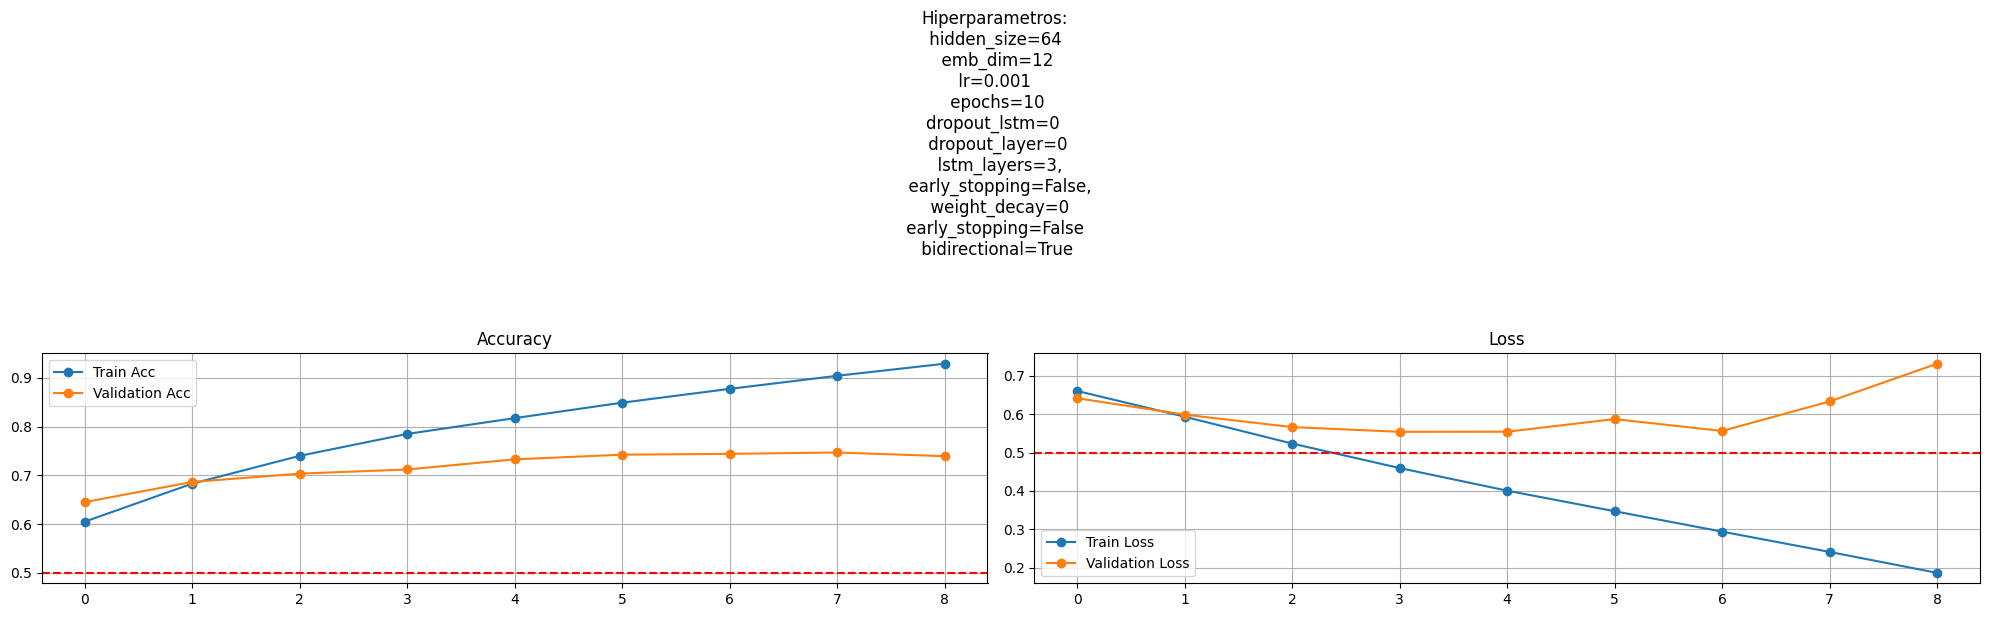

Processing model 2 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [04:49<00:00, 28.99s/it]


[0.6149218456249664, 0.6798087769243165, 0.7227265402589031, 0.7663963044529194, 0.8043186335070097, 0.8389106730407692, 0.8680775635172154, 0.8955255948863942, 0.9179244776279745, 0.9358113552129774] [0.6392579593883179, 0.6758586111807471, 0.693406868889446, 0.7189771872649787, 0.7237402857859112, 0.7307595888693909, 0.7322637252444222, 0.7325144146402607, 0.7372775131611933, 0.7445475056405114] [0.23142542973442864, 0.20580113267529238, 0.18302508788552013, 0.16004468832107296, 0.1390568537384323, 0.11867128628371812, 0.09940154123538383, 0.08211149522640362, 0.06671116727110954, 0.05338940593869251] [0.2249101778912929, 0.2069146921557765, 0.2022013290514869, 0.19237641635681352, 0.19095063533994458, 0.1836228138136287, 0.1906010474889509, 0.20031415046222747, 0.2040536404256859, 0.2078128700414973]


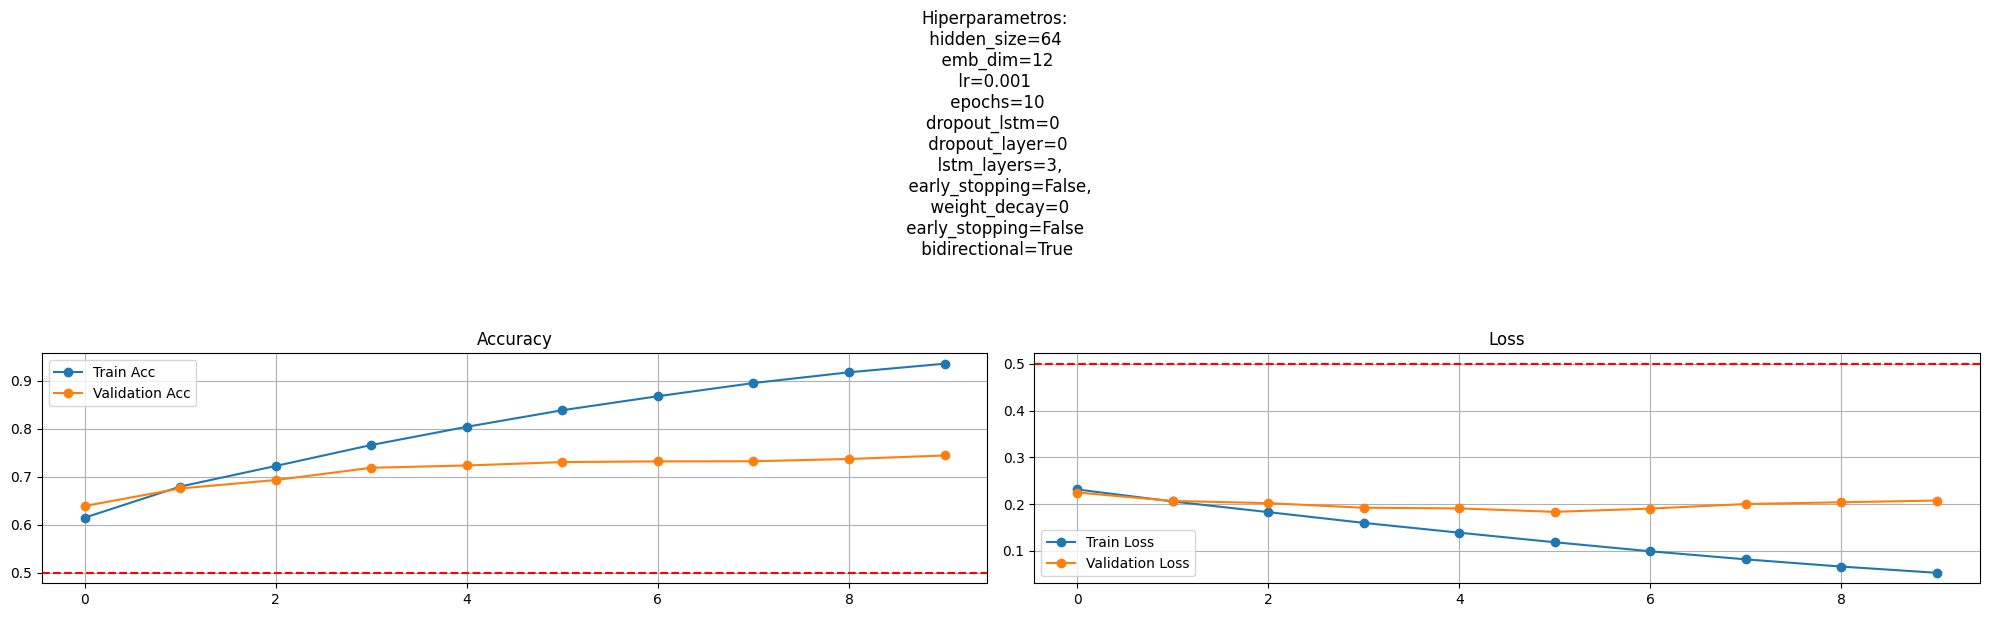

Processing model 3 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  50%|█████     | 5/10 [01:51<01:51, 22.26s/it]


[0.5412794757479723, 0.5346188967073106, 0.5234463125100715, 0.5320943223935113, 0.5307514637159585, 0.5318257506580008] [0.5582852845324643, 0.5582852845324643, 0.5577839057407872, 0.48383053396841313, 0.5582852845324643, 0.43920782150915016] [0.7028877861323332, 0.6993886843811009, 0.7090063198708421, 0.7020857418260558, 0.7057745356157602, 0.7017296165894723] [0.6873453014319942, 0.6874914645187317, 0.6909344628933938, 0.6951607417675757, 0.6888413309089599, 0.7122522621385513]
Processing model 4 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  70%|███████   | 7/10 [07:11<03:04, 61.62s/it]


[0.6310361497555997, 0.766181447064511, 0.8447655368748993, 0.8766718590535532, 0.889187301928345, 0.8896170167051619, 0.8863404415319331, 0.8882741580276092] [0.6289796941589371, 0.7290047630985209, 0.7495612935572825, 0.7508147405364753, 0.7377788919528704, 0.715467535723239, 0.7395337177237403, 0.734018551015292] [0.23039970085306954, 0.167520754109818, 0.11633528730384814, 0.09613439301294338, 0.08702594555815019, 0.08594951297440237, 0.08867626465783293, 0.08941378381156175] [0.2344312276090345, 0.1881482057994412, 0.17839202549188368, 0.19486649863181577, 0.20890867271490635, 0.22179316356778145, 0.2135421778526037, 0.2106474013698678]
Processing model 5 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (

Epoc in Progress: 100%|██████████| 10/10 [19:42<00:00, 118.24s/it]


[0.6110544126336145, 0.6803996347424397, 0.7323951227372831, 0.7773003169146478, 0.8094752108288124, 0.8406295321480367, 0.867862706128807, 0.8917655905892464, 0.9149701885373583, 0.9363484986839985] [0.642015542742542, 0.6786161945349711, 0.6994234143895713, 0.718225119077463, 0.7297568312860366, 0.7315116570569065, 0.7485585359739283, 0.7465530208072199, 0.7422913010779644, 0.7427926798696415] [0.6579103463693248, 0.5944371679461146, 0.5291103175913405, 0.4685028539313302, 0.41620516215359693, 0.3617880374141897, 0.3127169735639928, 0.26601128435329807, 0.21786668837686005, 0.17151259927146406] [0.6349813856424824, 0.5946583550783896, 0.5609522459487761, 0.5739740755769515, 0.5541338993897361, 0.5435259789228439, 0.5398252823900792, 0.5950790349273912, 0.5932750283710418, 0.7010901025947063]
Processing model 6 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (g

Epoc in Progress:  90%|█████████ | 9/10 [02:21<00:15, 15.71s/it]


[0.6118601278401461, 0.6847504968577107, 0.7350808400923887, 0.7808454638233873, 0.8168877907289037, 0.8472363968415964, 0.8753827147231026, 0.8993930278777461, 0.9179781919750766, 0.9335553526346887] [0.6422662321383805, 0.6826272248683881, 0.7041865129105039, 0.7229882175983956, 0.735773376786162, 0.7447981950363499, 0.7450488844321885, 0.7508147405364753, 0.7480571571822512, 0.7473050889947356] [0.23200792515339416, 0.20399524984486953, 0.17699471818805768, 0.15263518672468535, 0.13108020057186817, 0.11215222087366548, 0.09459493090775306, 0.07939459331391344, 0.06672201429336634, 0.05577584031008331] [0.22043174529267895, 0.20133399230337912, 0.1936153153017644, 0.18308482391218986, 0.178242452622902, 0.1791771001392795, 0.18404354843040627, 0.1850363161835459, 0.19600435974256647, 0.2027388096997334]


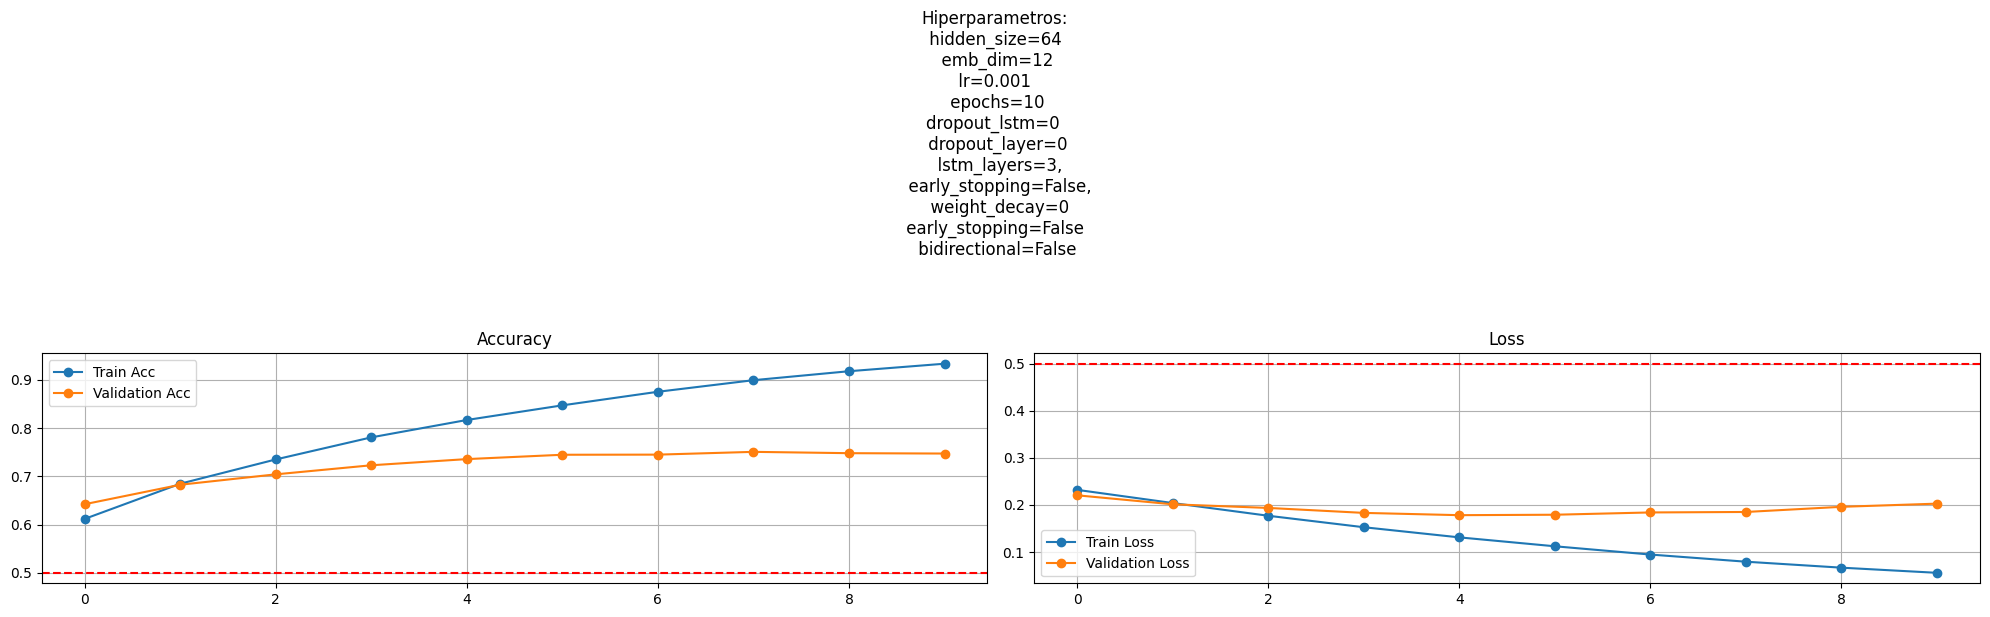

Processing model 7 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  60%|██████    | 6/10 [01:35<01:03, 16.00s/it]


[0.5287640328731804, 0.5340280388891873, 0.5335983241123704, 0.5380566149218456, 0.5412794757479723, 0.5470269108878981, 0.5366600418971907] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.43645023815492606] [0.6996994585876005, 0.6957523822784424, 0.6970529661941857, 0.6954979873975665, 0.6936559939753784, 0.6916551500712738, 0.697961689272764] [0.6942750609690144, 0.6856380047336701, 0.6865714605777494, 0.6856559327533168, 0.6935712502848718, 0.6862623552160878, 0.6951370691099474]
Processing model 8 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  60%|██████    | 6/10 [01:35<01:03, 15.99s/it]


[0.6212601385830155, 0.7771928882204436, 0.8508352580974379, 0.8809690068217221, 0.8957941666219047, 0.90610732126551, 0.9109416125047] [0.6929054900977689, 0.7463023314113812, 0.7450488844321885, 0.7505640511406367, 0.7575833542241163, 0.756580596640762, 0.7405364753070945] [0.22886938463236092, 0.15760926128382732, 0.11137064888419362, 0.09196027257301798, 0.08210538792353374, 0.07340237610971814, 0.07043696783736297] [0.20296047345524834, 0.1788505333806238, 0.18365128620737983, 0.1815179556968712, 0.19751477644087806, 0.1973490900089664, 0.1970719981097406]
Processing model 9 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  90%|█████████ | 9/10 [06:47<00:45, 45.26s/it]


[0.5969812536928614, 0.6728796261481441, 0.7325025514314873, 0.7773003169146478, 0.8101734973411399, 0.8396626739001988, 0.8653381318150077, 0.8907450179943063, 0.9123381855293549, 0.9331256378578718] [0.62847831536726, 0.6776134369516169, 0.7071947856605666, 0.7202306342441714, 0.7277513161193282, 0.7305088994735522, 0.7473050889947356, 0.7415392328904488, 0.7432940586613186, 0.742541990473803] [0.6651530337107981, 0.6012805924973676, 0.5333062677600913, 0.46895322488322727, 0.41408134404435215, 0.3615392946130027, 0.31613372549696755, 0.2674559287649937, 0.22049330223653074, 0.17726761823048792] [0.6508990689631431, 0.6036981281734282, 0.5805459786807338, 0.5681281334930851, 0.548633624228739, 0.5620115166229587, 0.582848169510403, 0.6432946009501335, 0.707460648109836, 0.7658167870775345]
Processing model 10 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru

Epoc in Progress: 100%|██████████| 10/10 [07:16<00:00, 43.69s/it]


[0.6067572648654456, 0.6712144813879787, 0.7209539668045335, 0.7648923027340603, 0.799108341838105, 0.828167803620347, 0.8581404093033249, 0.881882150722458, 0.9024547456625664, 0.9185153354460976] [0.6297317623464528, 0.6645775883680121, 0.6941589370769616, 0.706944096264728, 0.7252444221609425, 0.7269992479318125, 0.7347706192028077, 0.7372775131611933, 0.729506141890198, 0.7337678616194535] [0.23473886160657656, 0.2102602303233286, 0.18688030424247304, 0.16344908274799944, 0.14259229253547942, 0.12437426586428628, 0.10710872981613967, 0.09261564756847802, 0.07846816791271191, 0.06754712127477713] [0.2276641078774006, 0.2132113407696447, 0.20045899948285473, 0.19414622426754044, 0.1922222994748623, 0.19223886379791844, 0.1905283017023917, 0.19678450832443853, 0.20428457717982032, 0.20266658452249342]
Processing model 11 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387,

Epoc in Progress:  50%|█████     | 5/10 [04:03<04:03, 48.72s/it]


[0.5337057528065746, 0.5369823279798034, 0.5304291776333458, 0.5279046033195467, 0.5393994735993984, 0.5381103292689478] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.7060665834996458, 0.6998044563242573, 0.7001234691032239, 0.6996482383979167, 0.6988644858440721, 0.6977708928556328] [0.6861591166065585, 0.728260398872437, 0.6876988718586583, 0.6979620370172686, 0.686422890713138, 0.712483414238499]
Processing model 12 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  80%|████████  | 8/10 [05:22<01:20, 40.26s/it]


[0.5360691840790676, 0.5341891819304936, 0.5355857549551485, 0.5381640436160499, 0.5453080517806306, 0.5468120534994897, 0.541118332706666, 0.5412257614008702, 0.5322554654348176] [0.5582852845324643, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.2529459504888308, 0.2529874755367765, 0.25142661232033203, 0.25084498860647264, 0.25039947994707373, 0.24983585132173744, 0.24940736827772372, 0.24964497844959496, 0.2505078858178167] [0.24804752752665551, 0.24787547102858942, 0.25527564964948163, 0.2464012643021922, 0.25960466241644276, 0.24681350564764393, 0.24729076027870178, 0.24640602906865458, 0.2496054792596448]
Processing model 13 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=5, batch_first=True)
  (dropout): Drop

Epoc in Progress: 100%|██████████| 10/10 [03:06<00:00, 18.65s/it]


[0.5995058280066605, 0.6686899070741795, 0.7233173980770263, 0.7689745931138207, 0.8062523500026857, 0.8377826717516249, 0.8629209861954128, 0.8921415910189612, 0.9156684750496857, 0.9343073534941183] [0.6259714214088744, 0.669089997493106, 0.7039358235146653, 0.7259964903484583, 0.7352719979944848, 0.7440461268488343, 0.7458009526197041, 0.751566808723991, 0.7445475056405114, 0.7402857859112559] [0.6627796191767038, 0.6043229432914425, 0.5414747155164072, 0.4787425599902509, 0.4200798666774714, 0.366978910288384, 0.3159106119749058, 0.26704084859734556, 0.22118310284081097, 0.1789839414049344] [0.642430154065932, 0.606101528050438, 0.5736696734543769, 0.5504030616533372, 0.5643361057004621, 0.5800925748002145, 0.5387811848232823, 0.5786570207245888, 0.6300766945125595, 0.7854311732995894]
Processing model 14 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru)

Epoc in Progress: 100%|██████████| 10/10 [03:01<00:00, 18.12s/it]


[0.6031584036096042, 0.6744373422141053, 0.7337379814148359, 0.7791266047161197, 0.8117312134071011, 0.842670677337917, 0.8681312778643175, 0.8873610141268733, 0.9077187516785733, 0.921093624106999] [0.6257207320130358, 0.6713462020556531, 0.7014289295562798, 0.724993732765104, 0.7337678616194535, 0.738029581348709, 0.7400350965154174, 0.7417899222862873, 0.7440461268488343, 0.7478064677864127] [0.2365506799208728, 0.20835655696831143, 0.17948868144912686, 0.1545835789517466, 0.13432133713939104, 0.1164121837924249, 0.10090590384909033, 0.08806786686101874, 0.07566232425312988, 0.06543220029446567] [0.22730679713910626, 0.21484779133912055, 0.19867479933365698, 0.18621722044002625, 0.18843781233074203, 0.184453422383916, 0.18422119349481597, 0.19162159947858703, 0.20013647412340488, 0.20417626607682435]


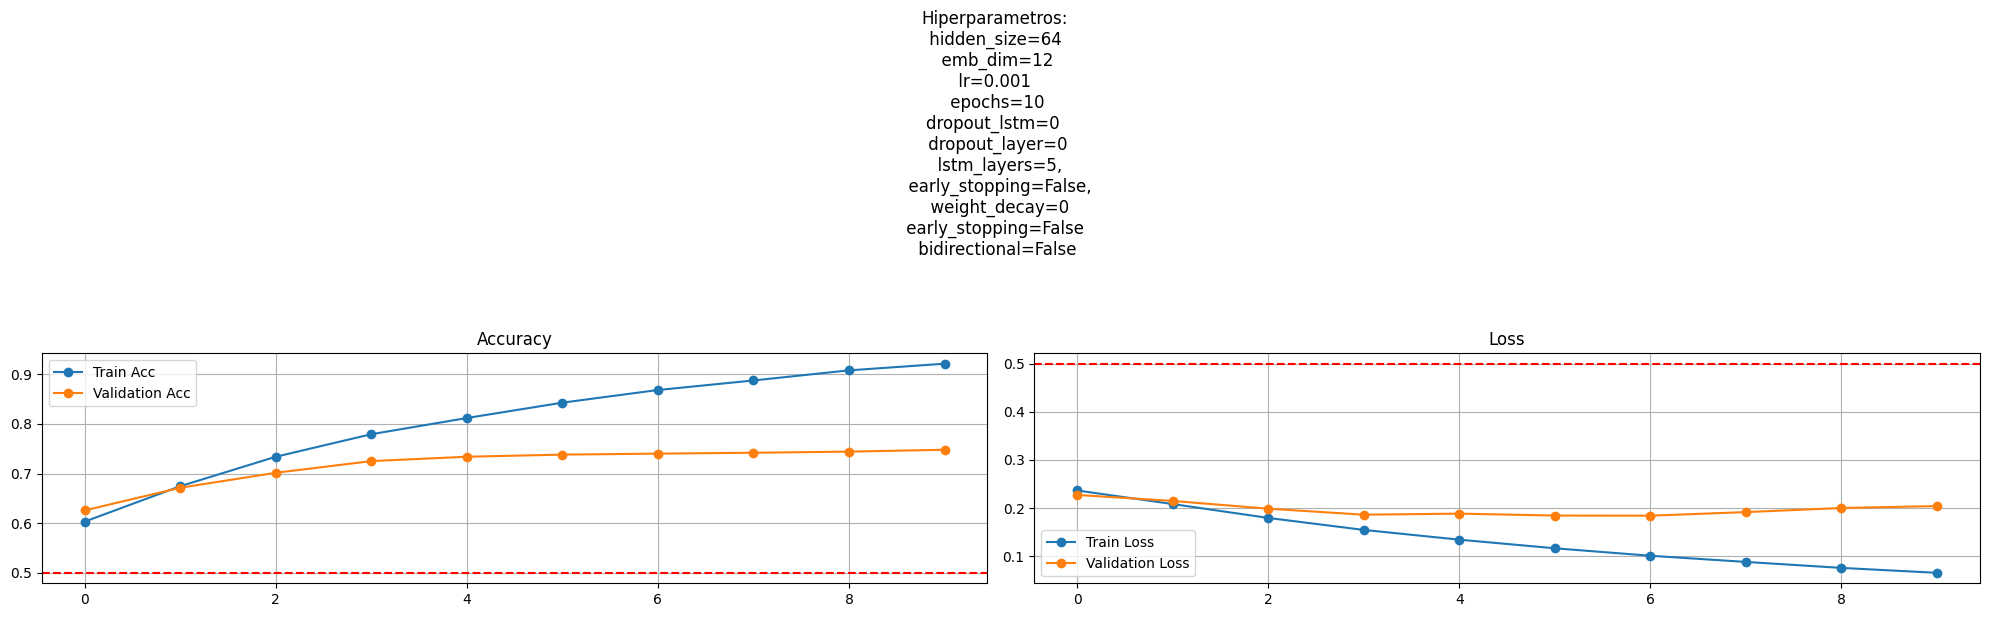

Processing model 15 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  60%|██████    | 6/10 [02:04<01:23, 20.79s/it]


[0.546489767416877, 0.5428909061610356, 0.5375731857979267, 0.531449750228286, 0.5453080517806306, 0.5400440457646237, 0.5413331900950744] [0.5580345951366257, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.6940855620855308, 0.6914142093231674, 0.6956497709845512, 0.6945257318204529, 0.692115660275937, 0.6931874296546188, 0.6925919200590268] [0.6983307542339448, 0.6857954600164967, 0.6965529779272694, 0.7006321212937755, 0.6869293835855299, 0.6862223153152773, 0.688254871676045]
Processing model 16 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 64, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 64, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [02:58<00:00, 17.81s/it]

[0.5393457592522963, 0.5397217596820111, 0.5390234731696836, 0.5379491862276414, 0.5439114787559757, 0.5431594778965462, 0.5427834774668314, 0.5497126282430037, 0.548423483912553, 0.5426223344255251] [0.5582852845324643, 0.5582852845324643, 0.5565304587615943, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.2514818652105003, 0.2520280658634517, 0.25095498113028974, 0.25194006232406924, 0.24928063895431526, 0.2501239615288946, 0.24919329055307654, 0.2487979456141155, 0.24901439157184757, 0.2504269542259111] [0.2635054761363614, 0.25642305480376365, 0.2470609693517608, 0.24827600787243537, 0.24944116439550154, 0.24684304047015407, 0.24704913134055753, 0.24959063938548487, 0.2463020750832173, 0.2514692868196195]


In [ ]:
best_modelGRU_g1, modelsGRU_g1 = eval_models(params_models_g1, SarcasmGRU, training_gru_model, training_params, print_plots='best_model')

In [ ]:
[best_modelGRU_g1['params'], best_modelGRU_g1['best_epoch_vl_acc']]

[{'vocab_size': 21387,
  'output_size': 1,
  'embedding_dim': 12,
  'hidden_dim': 64,
  'n_layers': 5,
  'bidirectional': False,
  'lr': 0.001,
  'criterion': MSELoss()},
 [0.6257207320130358,
  0.6713462020556531,
  0.7014289295562798,
  0.724993732765104,
  0.7337678616194535,
  0.738029581348709,
  0.7400350965154174,
  0.7417899222862873,
  0.7440461268488343,
  0.7478064677864127]]

Aplicamos la misma función de búsqueda de hiperparámetros pero para la arquitectura GRU. Este es el primer mejor modelo encontrado, se diferencia del modelo GRU base en la cantidad de hidden_dim (64), en el n_layers (aumenta de 3 a 5), en la direccionalidad que en este casos es unidireccional y en la función de pérdida (criterion). En esta caso se utilizo MSELoss como funcion de pérdida. Vemos que el accuracy en validación alcanza un 0.747, al igual que en los otros modelos se observa sobreajuste

Total models to evaluate: 16
Processing model 1 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  90%|█████████ | 9/10 [04:10<00:27, 27.82s/it]


[0.593919535908041, 0.6690659075038943, 0.7251436858784982, 0.7670408766181447, 0.8050169200193371, 0.8348820970081109, 0.8648009883439867, 0.8967610248697427, 0.9277542031476608, 0.9512273728312832] [0.6136876410127852, 0.6653296565555277, 0.6939082476811231, 0.7029330659313111, 0.7177237402857859, 0.7347706192028077, 0.7372775131611933, 0.7420406116821259, 0.7410378540987717, 0.7377788919528704] [0.6680939808975194, 0.6127315019473767, 0.546110360532127, 0.4826967371771955, 0.4278298892375729, 0.3704473928976387, 0.31398972117449453, 0.2576337140726756, 0.1917646718620228, 0.13313620684351035] [0.6535135613333795, 0.6084629713046935, 0.6069803629671374, 0.5734448365626796, 0.5601574071953374, 0.570489358998114, 0.6020002448030056, 0.6826475649591415, 0.7175506759555109, 0.8081010837228068]


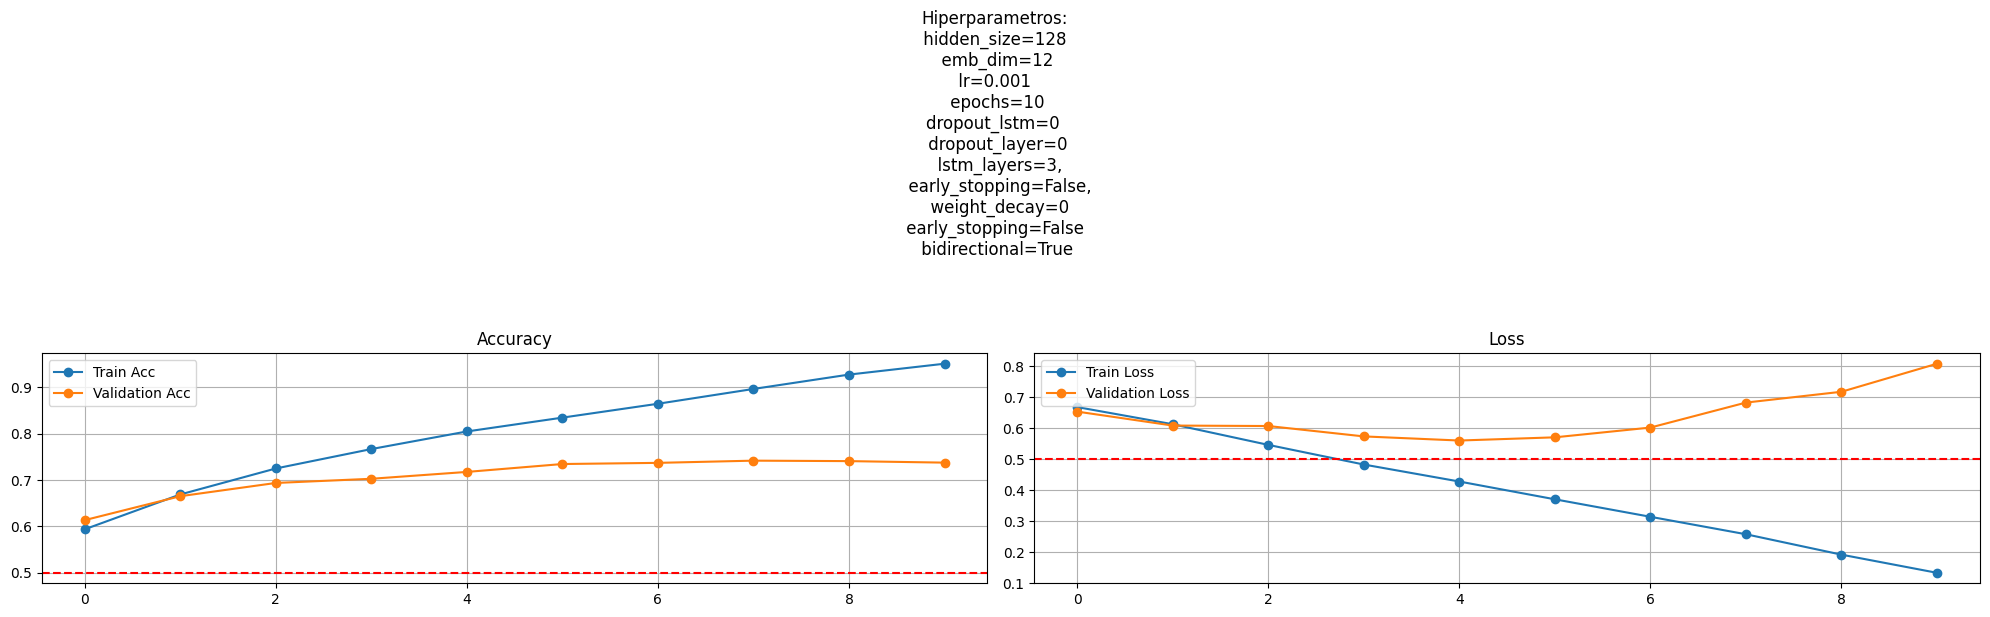

Processing model 2 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [05:35<00:00, 33.50s/it]


[0.6066498361712414, 0.6828167803620347, 0.7277219745393995, 0.7737551700059085, 0.8108717838534673, 0.8459472525111458, 0.8768330020948595, 0.9042810334640382, 0.9265724875114143, 0.9411290755760864] [0.6392579593883179, 0.6731010278265229, 0.6991727249937327, 0.7189771872649787, 0.7239909751817498, 0.7352719979944848, 0.7355226873903233, 0.7332664828277764, 0.7297568312860366, 0.7355226873903233] [0.2329632829419512, 0.20486727451806225, 0.18233686218778772, 0.15860997312245392, 0.13723280267363572, 0.11531726084970156, 0.09559042359223002, 0.07713550687551166, 0.06102665060074766, 0.050711334564782384] [0.21886460987790937, 0.20548256234295906, 0.19692272771029704, 0.19172949698423186, 0.18798374949443725, 0.1870846944230218, 0.19517871695420436, 0.2098830016029458, 0.21348686966924899, 0.21900585317803967]
Processing model 3 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embeddin

Epoc in Progress: 100%|██████████| 10/10 [05:58<00:00, 35.87s/it]


[0.5260246011709727, 0.5288714615673846, 0.5260783155180748, 0.5291400333028952, 0.5258634581296664, 0.5341891819304936, 0.5200623086426385, 0.5230703120803567, 0.5277434602782404, 0.529999462856529] [0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606] [0.7200711332582155, 0.711902535515685, 0.7109128946691701, 0.7051422589822398, 0.7098112415118389, 0.7048608419612025, 0.7142271425145423, 0.7111091494765421, 0.703991229685982, 0.7104088121355093] [0.7062093014678648, 0.7980242049501788, 0.7183330832950531, 0.7690032819105733, 0.7598538922686731, 0.6859222376538862, 0.7207430798199869, 0.696491668301244, 0.7864049896597862, 0.7356289327144623]
Processing model 4 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru

Epoc in Progress:  50%|█████     | 5/10 [03:52<03:52, 46.41s/it]


[0.5252726003115432, 0.5245743137992158, 0.5354783262609443, 0.517430305634635, 0.5277434602782404, 0.5286028898318741] [0.5058912008022061, 0.5582852845324643, 0.5139132614690398, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.2649576842477112, 0.2616693070494985, 0.25853496520634156, 0.26741121965821146, 0.2623976253601442, 0.2570925339569118] [0.24942839986854984, 0.25389959554999103, 0.2500352920784104, 0.27996854279791156, 0.2594157323962258, 0.2722726300839455]
Processing model 5 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [03:30<00:00, 21.09s/it]


[0.606972122253854, 0.6787882043293764, 0.7355105548692056, 0.7745071708653382, 0.8115163560186925, 0.8483643981307407, 0.8745769995165709, 0.9019176021915454, 0.9293656335607241, 0.9517108019552022] [0.6212083228879418, 0.6698420656806217, 0.6961644522436701, 0.7224868388067185, 0.729506141890198, 0.731260967661068, 0.7410378540987717, 0.7420406116821259, 0.7450488844321885, 0.7350213085986462] [0.6572483640016664, 0.595300539635545, 0.529796837529299, 0.4693162616169186, 0.4120206241968782, 0.3536035870418286, 0.29993743862373284, 0.24399058039263274, 0.18793590166149163, 0.13277596100145334] [0.6367736602983167, 0.5949372086794146, 0.5710601717714341, 0.5629076638048695, 0.5575925606873727, 0.5424749913715547, 0.6140082822211327, 0.6577921017043052, 0.6745226284669291, 0.8383727782676297]
Processing model 6 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gr

Epoc in Progress:  90%|█████████ | 9/10 [03:18<00:22, 22.04s/it]


[0.610839555245206, 0.6823333512381157, 0.7369608422409626, 0.7833163237900843, 0.8181769350593544, 0.8489015416017618, 0.8798410055325777, 0.9044958908524466, 0.925498200569372, 0.9395713595101252] [0.6435196791175734, 0.6826272248683881, 0.704687891702181, 0.7247430433692654, 0.7280020055151667, 0.7285033843068438, 0.7360240661820004, 0.7435447480571572, 0.7412885434946102, 0.7325144146402607] [0.2326235620628741, 0.2035600585596902, 0.17698558378906956, 0.15318513583398316, 0.1317501740174275, 0.11172467374952956, 0.09312474609091365, 0.07635882360181048, 0.06200909251892192, 0.051301751295208815] [0.22141518864420154, 0.20483469662647094, 0.1944325513416721, 0.18753923704066583, 0.18593531750863598, 0.19014241438238852, 0.19551422338812582, 0.2006040157209481, 0.21026591037309939, 0.21926994820035273]
Processing model 7 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21

Epoc in Progress:  50%|█████     | 5/10 [01:45<01:45, 21.16s/it]


[0.5281194607079551, 0.5375194714508245, 0.5400977601117258, 0.5381103292689478, 0.5295697480797121, 0.5352097545254337] [0.5582852845324643, 0.5582852845324643, 0.44146402607169716, 0.5582852845324643, 0.5322135873652545, 0.5582852845324643] [0.7020271366106253, 0.7002811995615442, 0.6992531794278839, 0.6984605893826116, 0.7061142644455429, 0.700141938028155] [0.6881340035507756, 0.6884069139918974, 0.695878648469525, 0.709451479777213, 0.6931969821453094, 0.6964245794280883]
Processing model 8 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 3, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  50%|█████     | 5/10 [01:39<01:39, 19.94s/it]


[0.5335446097652683, 0.5321480367406134, 0.5263468872535855, 0.5308051780630606, 0.5239834559810925, 0.5290863189557931] [0.5582852845324643, 0.5580345951366257, 0.5487590874905991, 0.5575332163449486, 0.46377538230132864, 0.5582852845324643] [0.2542999462190881, 0.2553610489054514, 0.2551080381398357, 0.25546247839106956, 0.25546506734600166, 0.25634732049939557] [0.24570831175773375, 0.2532097077177417, 0.24698844515988905, 0.25899605008382953, 0.25627483800053596, 0.24739653160495143]
Processing model 9 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress:  90%|█████████ | 9/10 [09:07<01:00, 60.80s/it]


[0.6022452597088682, 0.6556910350754687, 0.7033893753021432, 0.7514637159585326, 0.7839608959553097, 0.8130203577375517, 0.8361712413385616, 0.8594832679808777, 0.8827415802760917, 0.9011118869850137] [0.6174479819503635, 0.6558034595136626, 0.6758586111807471, 0.6986713462020556, 0.7059413386813738, 0.718225119077463, 0.7320130358485836, 0.735773376786162, 0.7317623464527451, 0.7377788919528704] [0.6672102914619774, 0.6269666615636337, 0.5777285026190818, 0.5214039160390729, 0.4704210491732353, 0.4260855559484068, 0.38268068994486804, 0.34356919188764135, 0.30113173467259396, 0.26317023370485504] [0.6585022903257801, 0.6205358644646983, 0.6036572937042483, 0.6247265624903864, 0.5593917081432958, 0.5679033124639142, 0.5876493463593144, 0.587927759414719, 0.6107011064887047, 0.7061266556622521]
Processing model 10 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (

Epoc in Progress: 100%|██████████| 10/10 [08:37<00:00, 51.77s/it]


[0.6053069774936886, 0.6672933340495246, 0.714400816458076, 0.756083149809314, 0.7896009024010313, 0.8186066498361713, 0.8462695385937584, 0.8677015630875007, 0.8837621528710319, 0.8985873126712145] [0.6342441714715468, 0.6568062170970168, 0.6738530960140386, 0.706944096264728, 0.7086989220355979, 0.7224868388067185, 0.7081975432439208, 0.7320130358485836, 0.7332664828277764, 0.7410378540987717] [0.23514755183058228, 0.21266768908644296, 0.18955387219966177, 0.16853365428399505, 0.148761316928724, 0.13189854654331215, 0.11597736700471625, 0.10276693943086466, 0.09185709034472626, 0.08220364243471787] [0.22501113866606065, 0.2100754320140808, 0.20358325312695197, 0.20660129153440077, 0.19794456348303827, 0.19711727931374504, 0.2072798338748755, 0.19476695106394828, 0.19864844858285882, 0.20049745481341116]


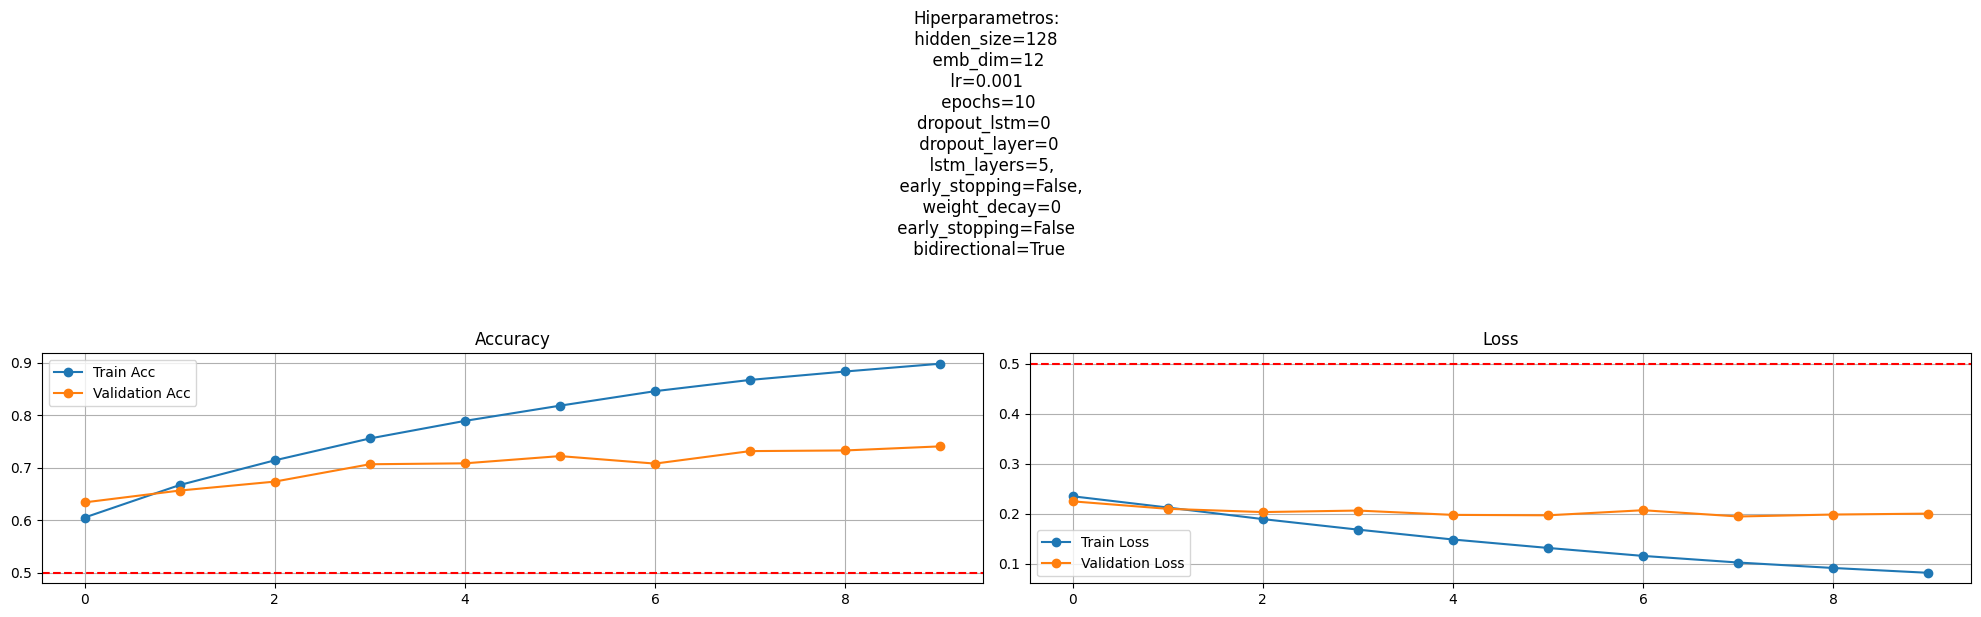

Processing model 11 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=5, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [07:28<00:00, 44.82s/it]


[0.5266691733361981, 0.5276897459311382, 0.5258097437825643, 0.5311811784927755, 0.5286028898318741, 0.5363377558145781, 0.5287103185260783, 0.5293011763442015, 0.5238223129397862, 0.52951603373261] [0.4429681624467285, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643] [0.7173371316028339, 0.7062316999583154, 0.7101491610687899, 0.7054706286645387, 0.7028621142784618, 0.7001957967236202, 0.7038895215922502, 0.7052817679108112, 0.7044092650667936, 0.7043325602495322] [0.6937907967836626, 0.6882146866090836, 0.7303120469854724, 0.6861285341362799, 0.7053840093074306, 0.6857814836886621, 0.6866014263322276, 0.6991606422009007, 0.7349020401316304, 0.6915106263852888]
Processing model 12 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': True}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gr

Epoc in Progress:  50%|█████     | 5/10 [04:38<04:38, 55.65s/it]


[0.523714884245582, 0.5282806037492614, 0.5337594671536767, 0.5251114572702369, 0.5338131815007788, 0.5252726003115432] [0.5582852845324643, 0.43645023815492606, 0.43645023815492606, 0.5582852845324643, 0.5354725495111556, 0.5582852845324643] [0.2632412725799876, 0.25919563914432786, 0.2564613593937813, 0.2563645128744194, 0.25419229217732836, 0.2553846498826285] [0.24933426731055783, 0.25421090484146147, 0.2621040882602815, 0.2661030276888801, 0.24988341836198683, 0.26488076691185275]
Processing model 13 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [03:22<00:00, 20.30s/it]


[0.6203469946822796, 0.6799162056185207, 0.7293871192995649, 0.7664500188000215, 0.8047483482838266, 0.8375141000161143, 0.8654455605092121, 0.8971907396465596, 0.9213621958425096, 0.9411827899231885] [0.6550513913261469, 0.6743544748057158, 0.695663073451993, 0.715467535723239, 0.724993732765104, 0.7322637252444222, 0.7375282025570319, 0.7365254449736777, 0.7332664828277764, 0.731260967661068] [0.6554085588701416, 0.599248367517212, 0.5426372884165195, 0.48586291131177173, 0.42801749270261874, 0.3729275103639202, 0.32101843727948126, 0.26648441075688795, 0.21701374978929913, 0.17032127408070327] [0.6292909638535592, 0.599858308751737, 0.574097621344751, 0.5503561008841761, 0.5703163931687032, 0.5430781108237082, 0.5855360841078143, 0.684956813291196, 0.686682277389111, 0.7682330413691459]
Processing model 14 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru

Epoc in Progress: 100%|██████████| 10/10 [03:14<00:00, 19.43s/it]


[0.6065961218241392, 0.6846430681635065, 0.7327711231669979, 0.7779448890798732, 0.8110329268947736, 0.8375141000161143, 0.8658215609389268, 0.8906375893001021, 0.9098673255626578, 0.9260353440403932] [0.6517924291802457, 0.6856354976184508, 0.7059413386813738, 0.731260967661068, 0.7370268237653548, 0.7385309601403861, 0.7528202557031838, 0.7460516420155427, 0.7483078465780898, 0.7518174981198296] [0.2336659532251949, 0.2046463417206697, 0.1796435338161283, 0.15657991964030185, 0.1360631031392979, 0.11834528229540782, 0.10076627184968705, 0.08533267148332782, 0.07304487671869808, 0.06232219062130032] [0.22064246105090266, 0.20189214365616923, 0.18952651111589325, 0.18096873777047282, 0.18224761424766434, 0.18235519870875344, 0.17907882349625712, 0.18537395922166686, 0.1870194195259002, 0.20358344035283213]


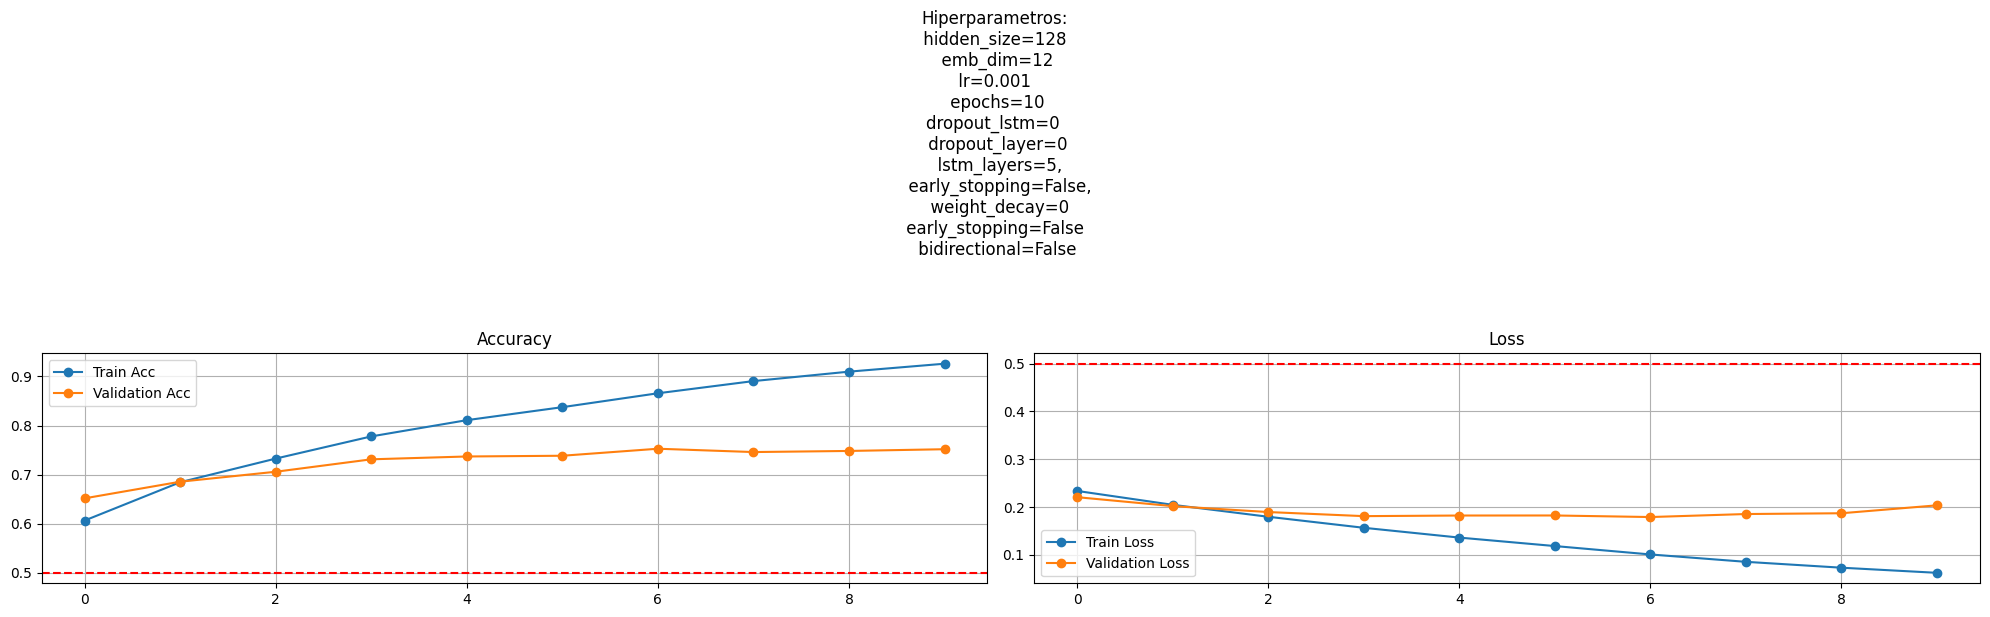

Processing model 15 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru): GRU(12, 128, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoc in Progress: 100%|██████████| 10/10 [03:11<00:00, 19.16s/it]


[0.5308051780630606, 0.5279583176666488, 0.531933179352205, 0.5271526024601171, 0.5261857442122791, 0.5301606058978353, 0.535854326690659, 0.5338131815007788, 0.5372508997153139, 0.5260783155180748] [0.43645023815492606, 0.5582852845324643, 0.44196540486337427, 0.43645023815492606, 0.5582852845324643, 0.43645023815492606, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.5582852845324643] [0.7028119040848672, 0.7101753109908966, 0.7001403370125159, 0.7015963857432446, 0.7004320395793029, 0.7002927976918508, 0.69759494640741, 0.6993773900703391, 0.6981561824089484, 0.6989513626402298] [0.7101627511362876, 0.687130807868896, 0.7078987783001315, 0.7091492496190532, 0.6864078886085941, 0.6984370855554458, 0.689328640218704, 0.689409060824302, 0.6911724978877652, 0.685941013597673]
Processing model 16 of 16
{'vocab_size': 21387, 'output_size': 1, 'embedding_dim': 12, 'hidden_dim': 128, 'n_layers': 5, 'bidirectional': False}
SarcasmGRU(
  (embedding): Embedding(21387, 12)
  (gru)

Epoc in Progress:  50%|█████     | 5/10 [01:57<01:57, 23.42s/it]

[0.529999462856529, 0.5307514637159585, 0.531449750228286, 0.5333297523768599, 0.5287103185260783, 0.5284954611376699] [0.5582852845324643, 0.5582852845324643, 0.5582852845324643, 0.43645023815492606, 0.5557783905740787, 0.43645023815492606] [0.25580761883016706, 0.25234010079538965, 0.25545654298413845, 0.253069946051875, 0.2541421037840556, 0.25901993770607573] [0.24723964436881005, 0.2549478197770734, 0.2482890141827445, 0.2547727584117843, 0.2520816896951968, 0.25279914996316355]


In [ ]:
best_modelGRU_g2, modelsGRU_g2 = eval_models(params_models_g2, SarcasmGRU, training_gru_model, training_params, print_plots='best_model')

In [ ]:
[best_modelGRU_g2['params'], best_modelGRU_g2['best_epoch_vl_acc']]

[{'vocab_size': 21387,
  'output_size': 1,
  'embedding_dim': 12,
  'hidden_dim': 128,
  'n_layers': 5,
  'bidirectional': False,
  'lr': 0.001,
  'criterion': MSELoss()},
 [0.6517924291802457,
  0.6856354976184508,
  0.7059413386813738,
  0.731260967661068,
  0.7370268237653548,
  0.7385309601403861,
  0.7528202557031838,
  0.7460516420155427,
  0.7483078465780898,
  0.7518174981198296]]

Segundo mejor modelo encontrado para GRU. A diferencia del modelo base el n_layers aumenta de 3 a 5, es unidireccional y la función de pérdida el MSELoss. Solo difiere del modelo anterior (best_modelGRU_g1) en el numero de hidden_dim que pasa a ser mayor (128). Aca el accuracy en validación alcanza un 0.75 y consistentemente se observa sobreajuste  

# Mejores modelos

In [ ]:
import torch

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Cambiar a modo de evaluación
    total_loss = 0.0
    total_samples = 0
    test_losses = []
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Mover los datos a dispositivo
            inputs, labels = inputs.to(device), labels.to(device)

            # Inicializar el estado oculto
            hidden = model.init_hidden(batch_size)

            # Hacer la inferencia sobre el conjunto de datos
            outputs, hidden = model(inputs, hidden)  # Obtener las predicciones

            # Calcular la pérdida
            loss = criterion(outputs.squeeze(), labels.float())
            accuracy = acc(outputs,labels)
            test_losses.append(loss.item())
            test_acc += accuracy

    print(f'Valor de Loss en el conjunto de validación: {np.mean(test_losses):.8f}')
    print(len(test_loader.dataset))
    print(f'Valor de accuracy en el conjunto de validación: {np.mean(test_acc/len(test_loader.dataset)):.8f}')



## Modelo Base

In [ ]:
evaluate_model(base_model, test_loader, criterion, device)

Valor de Loss en el conjunto de validación: 0.67606569
3986
Valor de accuracy en el conjunto de validación: 0.76643251


# Modelos encontrados

  Evaluamos tres de los modelos encontrados en el set de datos de testeo.

In [ ]:
evaluate_model(best_modelGRU_g1['model'], test_loader, best_modelGRU_g1['params']['criterion'], device)

Valor de Loss en el conjunto de validación: 0.19664560
3986
Valor de accuracy en el conjunto de validación: 0.75439037


In [ ]:
evaluate_model(best_modelGRU_g2['model'], test_loader, best_modelGRU_g2['params']['criterion'], device)

Valor de Loss en el conjunto de validación: 0.21187948
3986
Valor de accuracy en el conjunto de validación: 0.73933768


In [ ]:
evaluate_model(best_modelRNN_g1['model'], test_loader, best_modelRNN_g1['params']['criterion'], device)

Valor de Loss en el conjunto de validación: 0.75828311
3986
Valor de accuracy en el conjunto de validación: 0.77320622


# LLMs

Esta sección se encuentra desarrolada en la notebook Bert_Anexo_TP2

# Conclusiones


*  Todos los modelos entrenados presentaron sobreajuste, ya que el modelo ajustó bien en los datos de entrenamiento pero no en los datos de validación y test. Esto se condice con los valores de accuracy altos encontrados en el entrenamiento de prácticamente todos los modelos, este accuracy cae cualitativamente en el set de validación. Posiblemente el sobreajuste, es decir, la incapacidad del modelo para predecir si un registro es o no sarcásmo en los datos de validación, puede estar vinculado a la diferencia que existe entre el data set de entrenamiento y el data set de validación, ya que un 20% de los tokens presentes en el entrenamiento no estan presentes en el set de validación.  

* En términos generales las redes RNN tienen una mejor perfomance que las GRU. El mejor modelo encontrado fue best_modelRNN_g1 con un accuracy de 0.77 para el conjuto de testo. En general, todos los modelos dejaban de aprender antes de las 10 épocas. En este punto, queremos resaltar la dificultad para seleccionar parametros de forma eficientemente, ya que el costo computacional es muy alto.

*  Los LLMs no performaron como esperabamos y su ajuste fue bastante malo. Si bien BERT es un modelo pre-entrenado para procesamiento de lenguaje natural, es un modelo que puede servir para análisis mas generales del lenguaje y no para este caso particular. Los resultados son muy poco satisfactorios comparados a las redes neuronales armadas específicamente para esta tarea, lo que nos da a entender que posiblemente para tareas específicas como la asignada sea conveniente entrenar redes neuronales propias a modelos básicos de procesamiento del lenguaje natural.







